In [1]:
import sys
import os
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D, StandardScaler2D, seed_everything
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import matplotlib.pyplot as plt
from keras import backend as K
import scipy.io as scio
from scipy import stats
from echo.src.base_objective import BaseObjective
from echo.src.pruners import KerasPruningCallback
sys.path.append('/glade/work/fanda/optimization/echo_opt')
sys.path.append('/glade/work/fanda/util/goes16ci/goes16ci')
#from models_test import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
import optuna
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2023-08-30 08:30:21.587312: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.
2023-08-30 08:31:15.667597: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-30 08:31:15.669078: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-30 08:31:15.716083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-30 08:31:15.716125: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-08-30 08:31:15.811895: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


so.10
2023-08-30 08:31:15.863356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2023-08-30 08:31:15.877362: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2023-08-30 08:31:16.004757: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusparse.so.11
2023-08-30 08:31:16.007628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2023-08-30 08:31:16.008890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0


In [2]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

2023-04-13 12:12:13.786853: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-13 12:12:13.798884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-04-13 12:12:13.798908: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-13 12:12:13.819239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-13 12:12:13.819324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-04-13 12:12:13.827293: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.

In [ ]:
!pip install shap==0.41.0

In [ ]:
!pip install tensorflow==2.4.0

In [21]:
# Install CBI's SHAP fork
!pip install git+https://github.com/conrad-blucher-institute/shap.git

  Cloning https://github.com/conrad-blucher-institute/shap.git to /glade/scratch/fanda/pip-req-build-p240xvda
  Running command git clone --quiet https://github.com/conrad-blucher-institute/shap.git /glade/scratch/fanda/pip-req-build-p240xvda
  Resolved https://github.com/conrad-blucher-institute/shap.git to commit c78a7a625eccc892c716f402e81ca8ef01156747
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [14]:
!pip install -U pip tensorflow==2.4.1 git+https://github.com/janesser/shap.git@bugfix/1694

  Cloning https://github.com/janesser/shap.git (to revision bugfix/1694) to /glade/scratch/fanda/pip-req-build-99u3uikp
  Running command git clone --quiet https://github.com/janesser/shap.git /glade/scratch/fanda/pip-req-build-99u3uikp
  Running command git checkout -b bugfix/1694 --track origin/bugfix/1694
  Switched to a new branch 'bugfix/1694'
  Branch bugfix/1694 set up to track remote branch bugfix/1694 from origin.
  Resolved https://github.com/janesser/shap.git to commit 4a49dd103b811cdb332e60cd34fc273b061f2ae6
  Preparing metadata (setup.py) ... done
  Using cached tensorflow-2.4.1-cp37-cp37m-manylinux2010_x86_64.whl (394.3 MB)
  Created wheel for shap: filename=shap-0.38.2-cp37-cp37m-linux_x86_64.whl size=3150146 sha256=27e97ba2c406a150131d345668a827c6dbb22848bb3a74204dcbad9a581c765c
  Stored in directory: /glade/scratch/fanda/pip-ephem-wheel-cache-5inz7rrz/wheels/04/d3/b0/74d78aa53e126408f6ccce24aa2b8527a65db17f6262c793b8
Successfully built shap
  Attempting uninstall: shap

In [2]:
import tensorflow as tf

print('tf: %s' % tf.__version__)
tf.compat.v1.disable_eager_execution()
print('tf eager exec: %s' % tf.executing_eagerly())

import tensorboard
tensorboard.__version__

import shap
print('shap: %s' % shap.__version__)

tf: 2.4.1
tf eager exec: False
shap: 0.39.0


In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [2]:
#def main():
seed_everything(4835)
My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC'#GOESR_HRRR_PC/'
train_dir = My_dir+'/train_20/' 
test_dir = My_dir+'/test_21/'
onlyfiles = [f for f in listdir(train_dir) if isfile(join(train_dir, f))]
testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

config_file = open('/glade/work/fanda/optimization/benchmark_config_default_echo_best_resnet.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
print(config["dtype"])
# load data serial
logging.info("Split training and validation data")
train = []
label = []
test = []
test_label = []
lat_1 = []
lon_1 = []
date_1 = []
Type_1 = []
lat_train = []
lon_train = []
Type_train = []
benchmark_data = dict()
# load data serial
benchmark_data["config"] = config
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(train_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
    lat_1.append(processed_file.variables['lat_0'])
    lon_1.append(processed_file.variables['lon_0'])
    Type_1.append(processed_file.variables['Type'])
all_images = np.concatenate(train).astype(config["dtype"])
all_labels = np.concatenate(label).astype(config["dtype"])
lat_train = np.concatenate(lat_1).astype(config["dtype"])
lon_train = np.concatenate(lon_1).astype(config["dtype"])
Type_train = np.concatenate(Type_1).astype(config["dtype"])
all_images = np.moveaxis(all_images,1,-1)
delete_row =[]
for i in range(len(all_labels)):
    if np.sum(np.isnan(all_images[i,:,:,:]))>0 or np.max(all_images[i,:,:,:])>60000:
        delete_row.append(i)
    elif Type_train[i] > 1:
        if lon_train[i] > -91-0.5 or lon_train[i] < -104+0.5 \
        or lat_train[i] > 48-0.5 or lat_train[i] <34+0.5:
            delete_row.append(i)
lat_1 = []
lon_1 = []
Type_1 = []
all_images = np.delete(all_images, delete_row, 0)
all_labels = np.delete(all_labels, delete_row, 0)
delete_row =[]
for file in testfiles:
    processed_file = nc.Dataset(os.path.join(test_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    if file.endswith("RM.nc"):
        half_size=int(np.shape(processed_file.variables['label'])[0]/2)
        test.append(processed_file.variables['predictor'][:half_size,:,:,:])
        test_label.append(processed_file.variables['label'][:half_size])
        lat_1.append(processed_file.variables['lat_0'][:half_size])
        lon_1.append(processed_file.variables['lon_0'][:half_size])
        date_1.append(processed_file.variables['date'][:half_size])
        Type_1.append(processed_file.variables['Type'][:half_size])
    else:
        test.append(processed_file.variables['predictor'])
        test_label.append(processed_file.variables['label'])
        lat_1.append(processed_file.variables['lat_0'])
        lon_1.append(processed_file.variables['lon_0'])
        date_1.append(processed_file.variables['date'])
        Type_1.append(processed_file.variables['Type'])
test_images = np.concatenate(test).astype(config["dtype"])
test_labels = np.concatenate(test_label).astype(config["dtype"])
lat_0 = np.concatenate(lat_1).astype(config["dtype"])
lon_0 = np.concatenate(lon_1).astype(config["dtype"])
date_0 = np.concatenate(date_1).astype(config["dtype"])
Type_0 = np.concatenate(Type_1).astype(config["dtype"])
test_images = np.moveaxis(test_images,1,-1)
for i in range(len(test_labels)):
    if np.sum(np.isnan(test_images[i,:,:,:]))>0 or np.max(test_images[i,:,:,:])>60000:
        delete_row.append(i)
    elif Type_0[i] > 1:
        if lon_0[i] > -91-0.5 or lon_0[i] < -104+0.5 \
        or lat_0[i] > 48-0.5 or lat_0[i] <34+0.5:
            delete_row.append(i)
test_images = np.delete(test_images, delete_row, 0)
test_labels = np.delete(test_labels, delete_row, 0)
lat_0= np.delete(lat_0, delete_row, 0)
lon_0= np.delete(lon_0, delete_row, 0)
date_0= np.delete(date_0, delete_row, 0)
Type_0= np.delete(Type_0, delete_row, 0)
#print(np.shape(all_images))
#print(np.shape(test_images))
num = np.shape(all_images)[0]
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]

train_val_split = int(num*0.7)#25000
num_ch = np.arange(7,14)#np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
#scaler = MinMaxScaler2D()
#train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
#val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
#test_data_scaled = 1.0 - scaler.transform(test_data)
scaler = StandardScaler2D()
train_data_scaled = scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))
#for i in range(num_ch):
#    for j in range(num):
#        all_images[j,:,:,i] = (all_images[j,:,:,i] - np.min(np.squeeze(all_images[j,:,:,i])))\
#        /(np.max(np.squeeze(all_images[j,:,:,i]))-np.min(np.squeeze(all_images[j,:,:,i])))
#train_val_split = 28000 #1300 #14000

float32
(45077, 32, 32, 7)
(19320, 32, 32, 7)
(30221, 32, 32, 7)


In [3]:
print(np.sum(train_label)/np.shape(train_label))
print(np.sum(val_label)/np.shape(val_label))
print(np.sum(test_label)/np.shape(test_label))

[0.57801096]
[0.58178054]
[0.57817412]


In [2]:
# Load test data and model at (i+1)*10 lead time
lead_time=10 #min
test_data_mat = scio.loadmat('test_data/test_lead'+str(lead_time)+'.mat')
my_model = tf.keras.models.load_model("/glade/work/fanda/echo_resnet_lead_time/"+str(lead_time)+"min/goes16_resnet_gpus_01.h5",compile=False)
                                      #custom_objects={'Functional':tf.keras.models.Model})

2023-08-30 08:31:17.174365: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 08:31:17.174841: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-30 08:31:17.175614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-30 08:31:17.175652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-08-30 08:31:17.175704: I tensorflow/stream_executor/platform/default/dso_load

In [ ]:
Res_target_preds = np.zeros(6)
Log_target_preds = np.zeros(6)
#T = [0.49,0.46,0.41,0.40,0.40,0.31]
for i in range(6):
    my_model = tf.keras.models.load_model("/glade/work/fanda/echo_resnet_lead_time/"+str(10*(i+1))+"min/goes16_resnet_gpus_01.h5",compile=False)
    load_data = scio.loadmat('test_data/test_lead'+str(10*(i+1))+'.mat')
    #binary_threshold = T[i]
    preds = my_model.predict(load_data["test_data_scaled"]).reshape(load_data["test_label"].shape)
    Res_target_preds[i] = preds[0][index[10]]
    
    with open('echo_log_lead_time/'+str(10*(i+1))+'min/Logistic_regression_optimal.pkl', 'rb') as f:
        log = pickle.load(f)
    test_data_scaled_flatten = load_data["test_data_scaled"].reshape((-1,7168))
    log_preds = log.predict_proba(test_data_scaled_flatten)[:,1]
    Log_target_preds[i] = log_preds[index[10]]
    
    

In [3]:
T = [0.54,0.48,0.45,0.5,0.48,0.5]
binary_threshold = T[int(lead_time/10-1)]
preds = my_model.predict(test_data_mat["test_data_scaled"]).reshape(test_data_mat['test_label'].shape)
binary_preds = np.where(preds >= binary_threshold, 1, 0)

2023-08-30 08:31:21.257896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-30 08:31:21.258791: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2023-08-30 08:31:21.623412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-08-30 08:31:22.186404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-08-30 08:31:22.215528: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


In [4]:
#print(preds[test_label==1])
#np.where((dists >= r) & (dists <= r + dr))
ind=[]
indices = (np.where((test_data_mat["test_label"][0,:]==1) & (binary_preds[0,:]==1)))[0]
ind = np.argsort(preds[0,indices])[-100:]
best_hit_indices = indices[ind]

indices = (np.where((test_data_mat["test_label"][0,:]==0) & (binary_preds[0,:]==1)))[0]
ind = np.argsort(preds[0,indices])[-100:]
worst_false_alarm_indices = indices[ind]

indices = (np.where((test_data_mat["test_label"][0,:]==1) & (binary_preds[0,:]==0)))[0]
ind = np.argsort(-preds[0,indices])[-100:]
worst_miss_indices = indices[ind]

indices = (np.where((test_data_mat["test_label"][0,:]==0) & (binary_preds[0,:]==0)))[0]
ind = np.argsort(-preds[0,indices])[-100:]
best_correct_null_indices = indices[ind]

print(indices.shape)
print(indices[ind])
print(preds[0,best_hit_indices])
print(preds[0,worst_false_alarm_indices])
print(preds[0,worst_miss_indices])
print(preds[0,best_correct_null_indices])

(7703,)
[ 2728 25550 11060 19347 30001 24400 21080 18134 22302 23794 26583  4537
 10317  9142  4158 13011  1681 25735 27432 11964  4683 11968 21169  7474
 16306 29458 23933  4294 23806  9269  9660 28010 16937  7940  9606 24612
 19474  9237  7720  3281 23336 13166 28904 28635 14840  6036 25248  2702
 16951 18733 24662 19479 15281   422 21421 29914   103 17035  6238 13022
  3179  8530 28997 10760   377 11242 22538 14756 16097   614 21099  8688
 18292 17579  1866  8484  3437  5518  1487 22253  5245 10047 14593 22694
  1621  4694 11177 29461 15156 24523 29884 14012 19849 11993 11781  4994
 22264  7682  8563 25426]
[0.999579   0.99958295 0.9995851  0.99958676 0.9995994  0.9996007
 0.99961025 0.9996214  0.9996228  0.9996239  0.9996257  0.9996263
 0.9996283  0.9996371  0.9996371  0.99963784 0.999642   0.9996426
 0.9996513  0.99965286 0.9996562  0.9996655  0.9996661  0.99967
 0.9996728  0.99967587 0.99968076 0.99968326 0.99968445 0.999686
 0.9996896  0.9996929  0.9997002  0.9997048  0.9997217 

In [5]:
import scipy.io as scio
scio.savemat('test_lead10_all_indices.mat',{'best_hit_indices':best_hit_indices, 
                                            'worst_false_alarm_indices':worst_false_alarm_indices, 
                                            'worst_miss_indices':worst_miss_indices,
                                            'best_correct_null_indices':best_correct_null_indices})

In [5]:
import scipy.io as scio
test_lead10_all_indices = scio.loadmat("test_lead10_all_indices.mat")
print(test_lead10_all_indices["best_hit_indices"])

[[ 8409 12452 12988 15449 29203 11162   976   852  1282  4654  5047 13765
  14748 12089 12295 11805 18642 28946 25990 24704 12014 23555 14814 25339
  12871 19747 17627 21956  4162 29219 28419 28947 21824 11393 24925 26478
  19604 26111 20303 16546  7943 11357 27362  5878  3168 25136 18874 10083
   5335  8423 13616  2672 28190 29997  1218  3202 25118 22388 12119   653
  29132 16829 12269 19852 21051 22019 16426  6441 29650  1940 25797 23567
  11261 14914 24556  8033  6300  5576 18516 15350 29176 23198 29480 11795
   9276  3042 29736 12646 10210 23195 24128 22011 21480 16947 22676  5416
  15432  4332 10287  2004]]


In [6]:
best_hit_indices

NameError: name 'best_hit_indices' is not defined

In [49]:
import tensorflow as tf 
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [12]:
tf.config.experimental_run_functions_eagerly(False)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
shap.maskers.Partition(X_train[0])

In [41]:

# since we have two inputs we pass a list of inputs to the explainer
#explainer = shap.GradientExplainer(my_model, x_train)
import shap

X_train = test_data_scaled

# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 10000, replace=False)]

#background=np.zeros((1,X_train.shape[1]*X_train.shape[2],1))

# explain predictions of the model on three images
#X = best_correct_null_matrix_norm[0]
#masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape)#, partition_scheme=1)
#e = shap.DeepExplainer(my_model,best_hits_matrix_norm[0])#, background)
e = shap.PartitionExplainer(my_model, background)
#explainer = shap.KernelExplainer(pipe_model.predict_proba, X_train, link="logit")
#shap_values = explainer.shap_values(X_test, nsamples="auto")
# we explain the model's predictions on the first three samples of the test set
#shap_values = explainer.shap_values([x_test[:3], x_test[:3]])

ValueError: The passed masker must have a .clustering attribute defined! Try shap.maskers.Partition(data) for example.

In [13]:
X.shape

(100, 32, 32, 7)

In [37]:
X = best_hits_matrix_norm[0]
shap_values = e.shap_values(X[:100,:,:,:])#,check_additivity=True)

In [23]:
print(np.shape(background))
print(np.shape(X))

(5000, 32, 32, 7)
(100, 32, 32, 7)


In [33]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [25]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.
#shap.explainers._deep.deep_tf.op_handlers['LeakyRelu'] = shap.explainers._deep.deep_tf.passthrough

In [11]:
masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=0)

TypeError: __init__() got an unexpected keyword argument 'partition_scheme'

In [ ]:
!pip install git+https://github.com/conrad-blucher-institute/shap.git

In [13]:
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
X = best_hits_matrix_norm[0]
#Xplot = worst_false_alarm_matrix_denorm
# Evaluate 
masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
#masker_blur_32x32 = shap.maskers.Image("blur(32, 32)", X[0].shape, partition_scheme=1)
shap_values = e.shap_values(X)#, tolerance=1e-2)

TypeError: __init__() got an unexpected keyword argument 'partition_scheme'

In [6]:
sys.path.append('/storage/home/dxf424/work/script/course_repository/')
from ai2es_xai_course.plotting import image_plotting, feature_map_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding, cnn, saliency

# Best hits
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(test_data_mat['test_data_scaled'][test_lead10_all_indices['best_hit_indices']][0])
# Worst false alarms
pmm_worst_false_alarm_matrix_denorm = utils.run_pmm_many_variables(test_data_mat['test_data_scaled'][test_lead10_all_indices['worst_false_alarm_indices']][0])
# Worst misses
pmm_worst_miss_matrix_denorm = utils.run_pmm_many_variables(test_data_mat['test_data_scaled'][test_lead10_all_indices['worst_miss_indices']][0])
# Best correst nulls
pmm_best_correct_null_matrix_denorm = utils.run_pmm_many_variables(test_data_mat['test_data_scaled'][test_lead10_all_indices['best_correct_null_indices']][0])

best_hits_matrix_norm=test_data_mat['test_data_scaled'][test_lead10_all_indices['best_hit_indices']]
worst_false_alarm_matrix_norm=test_data_mat['test_data_scaled'][test_lead10_all_indices['worst_false_alarm_indices']]
worst_miss_matrix_norm=test_data_mat['test_data_scaled'][test_lead10_all_indices['worst_miss_indices']]
best_correct_null_matrix_norm=test_data_mat['test_data_scaled'][test_lead10_all_indices['best_correct_null_indices']]

In [11]:
print(int(lead_time/10-1))

1


In [7]:
#binary_threshold = 0.50
#i=4
T = [0.54,0.48,0.45,0.5,0.48,0.5]
binary_threshold = 0.5#T[int(lead_time/10-1)]#0.5#T[int(lead_time/10-1)]

mean_cases = np.where(np.abs(preds - binary_threshold)<0.01)[1]

In [9]:
mean_cases = np.array([   13,    51,    79,   214,   289,   293,   328,   469,   519,
         792,   916,   927,  1140,  1466,  1515,  1620,  1664,  1673,
        1785,  1960,  1977,  2058,  2137,  2186,  2335,  2575,  2619,
        2667,  2685,  2885,  2888,  3386,  3439,  3449,  3694,  3764,
        3930,  4124,  4464,  4471,  4506,  4621,  4626,  4639,  4699,
        4729,  4757,  4817,  4970,  5322,  5365,  5594,  5595,  5723,
        5856,  6075,  6147,  6513,  6640,  6652,  6887,  7129,  7272,
        7360,  7466,  7592,  7873,  8017,  8105,  8188,  8712,  8832,
        8876,  9042,  9374,  9411,  9496,  9773,  9846, 10025, 10279,
       10281, 10325, 10568, 10607, 10652, 10689, 10883, 10969, 10973,
       11140, 11295, 11605, 11778, 11826, 11934, 12091, 12116, 12150,
       12229, 12264, 12435, 12444, 12455, 12597, 12852, 13135, 13458,
       13472, 14086, 14148, 14408, 14413, 14438, 14623, 14682, 14737,
       14776, 14875, 15063, 15127, 15282, 15378, 15457, 15529, 15724,
       15822, 15852, 16084, 16265, 16362, 16427, 16589, 16622, 16720,
       17036, 17206, 17455, 17668, 17703, 18021, 18188, 18379, 18515,
       18604, 18829, 19016, 19035, 19173, 19278, 19625, 19840, 19891,
       19893, 19969, 20600, 20683, 20756, 20985, 21005, 21380, 21473,
       21493, 21574, 21609, 21701, 21827, 21982, 22029, 22034, 22151,
       22286, 22497, 22578, 22609, 22692, 22744, 22762, 22819, 22885,
       22932, 23094, 23352, 23359, 23526, 23644, 23659, 23703, 23768,
       23893, 24035, 24115, 24124, 24206, 24219, 24247, 24455, 24711,
       24785, 24823, 24829, 24863, 24879, 24976, 25015, 25184, 25249,
       25315, 25334, 25578, 25673, 25840, 26146, 26380, 26508, 26685,
       26754, 26867, 26947, 27007, 27018, 27035, 27256, 27338, 27498,
       27709, 27750, 27880, 27890, 27906, 27926, 27993, 28022, 28032,
       28146, 28201, 28310, 28455, 28467, 28505, 28705, 28748, 29197,
       29352, 29499, 29728, 30049])

In [10]:
mean_cases.shape

(174,)

In [36]:
mean_inputs = test_data_mat['test_data_scaled'][mean_cases]
print(np.shape(mean_inputs))

(178, 32, 32, 7)


In [71]:
mean_inputs_mean = np.mean(mean_inputs,axis=(1,2))

In [45]:
print(mean_inputs_mean.max)

(247, 7)


In [47]:
k= 5
idx = np.argpartition(mean_inputs_mean[:,0], k)
print(idx)
# [4 0 7 3 1 2 6 5]mean_inputs_mean[:,0]

[ 59 196  70  19  38  95 125 111  93 221  10  67 159  75 217 185 180 240
  65  62 174  80  48  90 191 190 103  60 148 168  96 118 160 216 215 205
 182 150  63  36 183  41 146  81 219  79  46  25 220  49 173 106  20 107
  54 197 126 127  66 156 153 149 244 199  72 200 204  57 206 210  52  71
 123  73 192  51  50  47 189 211  44  43  82 188 186  85 212  40  88 214
  37  91  92  35  94  31 218  97  29 178 100  28 102  26 104  22 222 227
 108 109 172  17 112 113 171 228 166 117  15 119 165 161 232   1 124  13
 239  11 128   9 158 131 132 157 134 135 241 155   6 151   5 242 245 143
 145   0 144 147 142 141 140 139 152 138 154 137 136 133 130 129 122 121
 162 163 164 120 116 167 115 169 170 114 110 105 101 175 176 177  99 179
  98 181  89  87 184  86  84 187  83  78  77  76  74 193 194 195  69  68
 198  64  61 201 202 203  58  56  55 207 208 209  53  45  42 213  39  34
  33  32  30  27  24  23  21 223 224 225 226  18  16 229 230 231  14 233
 234 235 236 237 238  12   8   7   4 243   3   2 24

In [115]:
K = mean_inputs_mean[:,4]
middle_five = sorted(range(len(K)), key=lambda x: K[x])[200:215]
print(K[middle_five])

[0.8187499  0.83106196 0.832211   0.8385748  0.8437968  0.8479377
 0.84838235 0.85182214 0.85457385 0.8644498  0.8880808  0.8934839
 0.92047614 0.9343348  0.9381331 ]


In [116]:
mean_index = mean_cases[middle_five]

In [117]:
mean_index

array([14776, 15529, 16265, 16362, 22885, 16084, 24785,  7129, 24219,
        8188, 25578, 27709,  9496, 18021, 11295])

In [104]:
best_hits_inputs_mean = np.mean(X,axis=(1,2))

In [107]:
best_hits_inputs_mean[:,4]

array([ 0.6727146 ,  0.6273606 ,  1.2592493 ,  1.4683425 ,  0.6569601 ,
       -0.10568185,  1.0713943 ,  1.0378652 ,  1.5928843 ,  0.33576876,
        1.0100644 ,  0.18227631,  0.55728257,  0.58641416,  1.265121  ,
        1.5987964 ,  1.535202  ,  0.9648275 ,  1.0328257 ,  1.0899454 ,
        1.6207447 ,  0.8319785 ,  1.3837538 ,  0.5292369 ,  1.513068  ,
        1.1789384 ,  1.0573952 ,  0.34578365,  1.395262  ,  1.3081164 ,
        0.5476856 ,  0.651067  ,  1.3872368 ,  1.5084448 ,  1.3611679 ,
        1.2011999 ,  0.76864266,  1.3734667 ,  1.5779338 ,  1.2033417 ,
        1.4347246 ,  1.1897465 ,  1.0599673 ,  1.4262075 ,  0.47548142,
        0.75940114,  0.7239928 ,  1.4911747 ,  1.1706002 ,  0.5489392 ,
        0.6240257 ,  0.45430782,  0.7246074 ,  1.4244525 ,  0.94744676,
        0.14129262,  0.8623568 ,  0.92484975,  0.35380897,  1.1818408 ,
        0.7360791 ,  1.5619442 ,  0.6024811 ,  0.90628237,  0.8383435 ,
        0.83621013,  1.6269832 ,  1.4535787 ,  1.4841931 ,  1.37

(array([ 1.,  3.,  3., 11., 18., 11., 11., 14., 13., 15.]),
 array([-0.10568185,  0.06758465,  0.24085115,  0.41411766,  0.58738416,
         0.76065063,  0.93391716,  1.1071837 ,  1.2804501 ,  1.4537166 ,
         1.6269832 ], dtype=float32),
 <BarContainer object of 10 artists>)

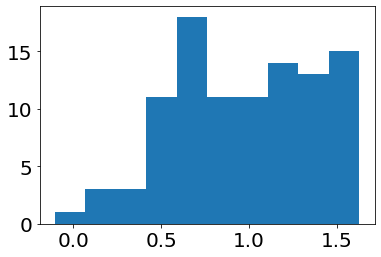

In [109]:
plt.hist(best_hits_inputs_mean[:,4])

In [77]:
K[warm_five]

array([1.6481295, 1.7884483, 1.8732684, 1.9558783, 2.086031 ],
      dtype=float32)

In [74]:
np.where(mean_inputs_mean[:,0]==sorted_array[:5])

(array([], dtype=int64),)

In [58]:
mean_inputs_mean[3,0]

0.5862392

In [48]:
idx.shape

(247,)

In [20]:
mean_cases

array([  225,   411,   832,   862,   991,  1075,  1127,  1278,  1419,
        1450,  1758,  1875,  1969,  2063,  2694,  2823,  2914,  3088,
        3188,  3573,  3659,  3842,  4047,  4373,  4428,  4554,  4662,
        4888,  5120,  5204,  5213,  5396,  5432,  5569,  5595,  5597,
        5601,  5962,  6234,  6356,  6772,  7101,  7228,  7268,  7440,
        7467,  7767,  7904,  8289,  8309,  8757,  8829,  8857,  8875,
        8876,  8966,  9009,  9177,  9380,  9712,  9796,  9940, 10279,
       10326, 10435, 10478, 10490, 10597, 10830, 11430, 11677, 11851,
       11905, 11930, 12000, 12169, 12444, 12903, 12959, 13083, 13113,
       13135, 13424, 13511, 13520, 13661, 13832, 13836, 13877, 13982,
       14297, 14314, 14383, 14639, 14727, 14820, 15276, 15801, 15802,
       16161, 16242, 16890, 17105, 17313, 17485, 17508, 17938, 18483,
       18643, 18728, 18842, 18876, 19110, 19460, 19605, 20270, 20434,
       20527, 20541, 20558, 20633, 20665, 20666, 20730, 21087, 21124,
       21309, 22115,

In [8]:
pmm_mean_matrix_denorm = utils.run_pmm_many_variables(test_data_mat['test_data_scaled'][mean_cases[:5]])

In [20]:
mean_cases

array([  225,   411,   832,   862,   991,  1075,  1127,  1278,  1419,
        1450,  1758,  1875,  1969,  2063,  2694,  2823,  2914,  3088,
        3188,  3573,  3659,  3842,  4047,  4373,  4428,  4554,  4662,
        4888,  5120,  5204,  5213,  5396,  5432,  5569,  5595,  5597,
        5601,  5962,  6234,  6356,  6772,  7101,  7228,  7268,  7440,
        7467,  7767,  7904,  8289,  8309,  8757,  8829,  8857,  8875,
        8876,  8966,  9009,  9177,  9380,  9712,  9796,  9940, 10279,
       10326, 10435, 10478, 10490, 10597, 10830, 11430, 11677, 11851,
       11905, 11930, 12000, 12169, 12444, 12903, 12959, 13083, 13113,
       13135, 13424, 13511, 13520, 13661, 13832, 13836, 13877, 13982,
       14297, 14314, 14383, 14639, 14727, 14820, 15276, 15801, 15802,
       16161, 16242, 16890, 17105, 17313, 17485, 17508, 17938, 18483,
       18643, 18728, 18842, 18876, 19110, 19460, 19605, 20270, 20434,
       20527, 20541, 20558, 20633, 20665, 20666, 20730, 21087, 21124,
       21309, 22115,

In [38]:
pmm_mean_matrix_denorm.shape

(32, 32, 7)

In [83]:
best_hits_matrix_norm.shape

(1, 100, 32, 32, 7)

In [14]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [12]:
print(np.shape(best_hits_matrix_norm[0]))
print(np.shape(pmm_best_hits_matrix_denorm))

(100, 32, 32, 7)
(32, 32, 7)


In [7]:
def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]
  print(np.shape(pmm_matrix_denorm))
  print(np.shape(input_times_grad_matrix))
        
  #plot_storm_xai(pmm_matrix_denorm, input_times_grad_matrix)
  return input_times_grad_matrix

In [12]:
input_times_grad_matrix = input_times_grad(best_hits_matrix_norm[0][:100,:,:,:], pmm_best_hits_matrix_denorm)

Have computed saliency maps for 0 of 100 examples...
Have computed saliency maps for all 100 examples!
(32, 32, 7)
(32, 32, 7)


0.22246349033028406
(32, 32, 7)
pass


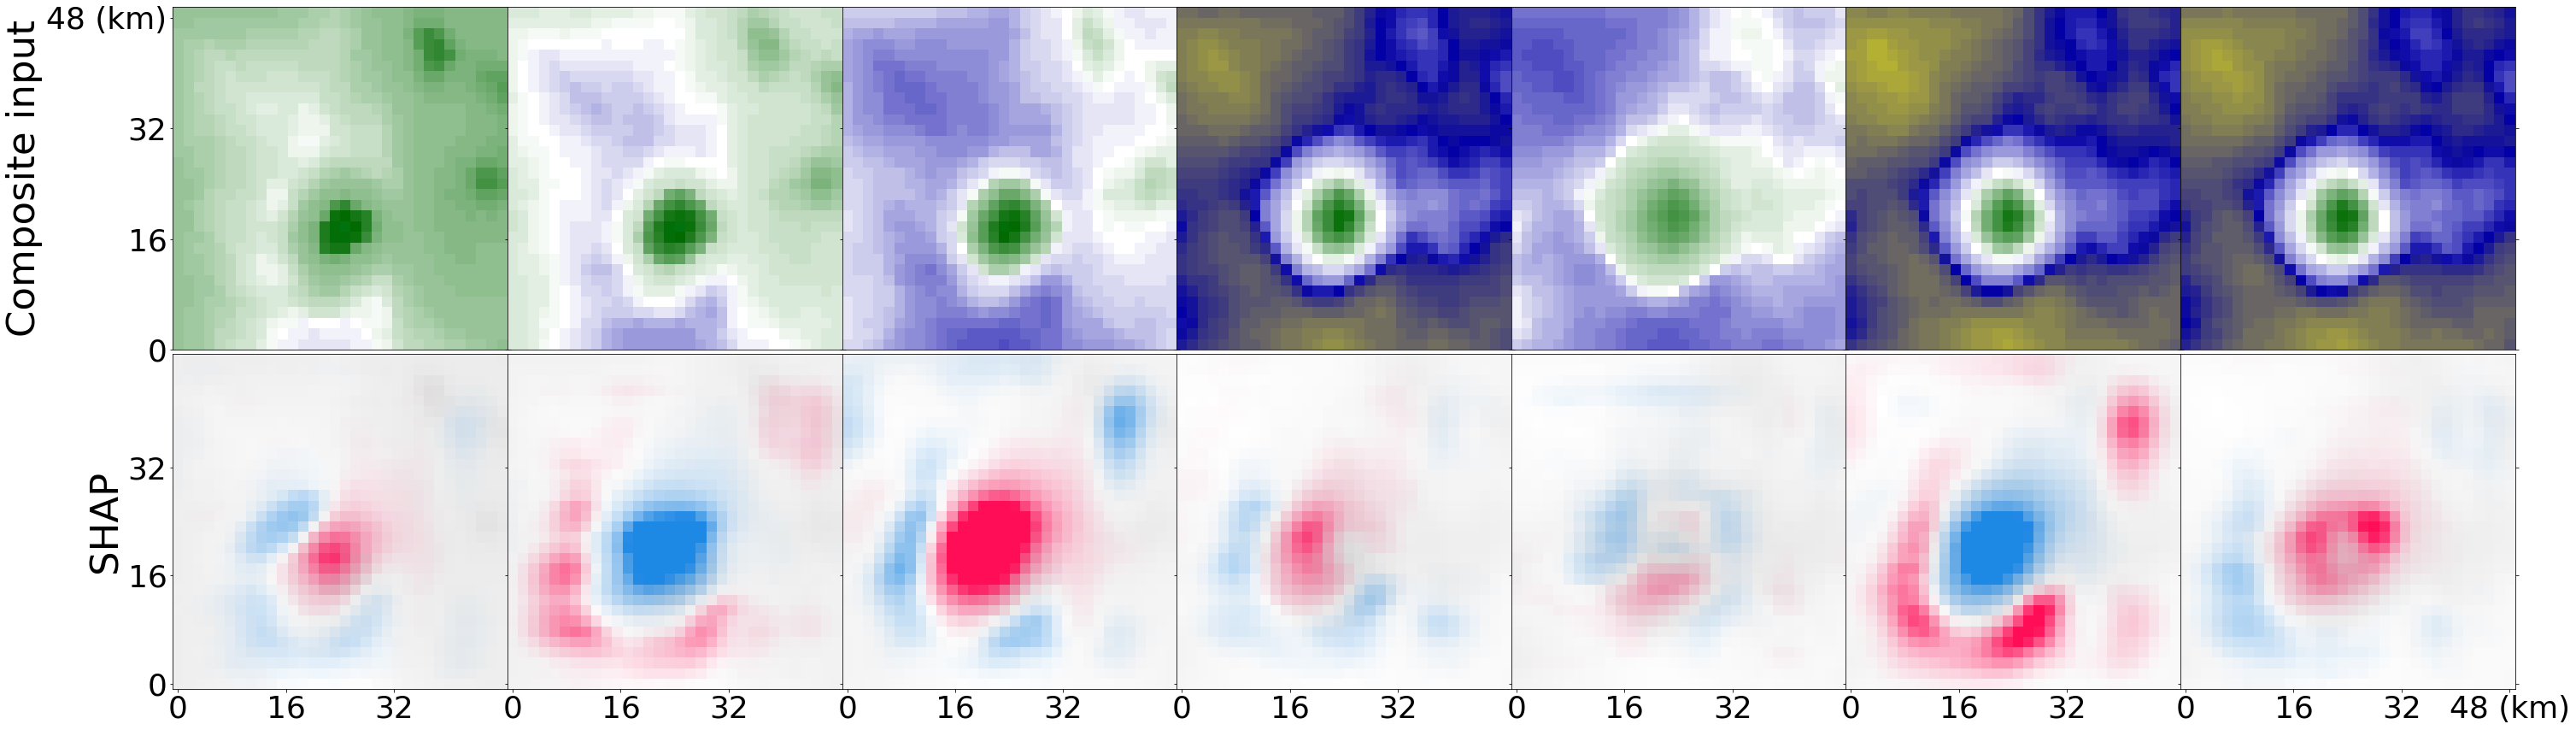

In [16]:
import copy
plot_storm_xai(pmm_best_hits_matrix_denorm,input_times_grad_matrix)

In [ ]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(my_model, best_hits_matrix_norm[0][:10,:,:,:])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
#shap_values = explainer.shap_values(x_test[:10])

In [ ]:
input_times_grad_matrix = input_times_grad(best_hits_matrix_norm[0][:10,:,:,:], pmm_best_hits_matrix_denorm)#[0:101,:,:,:]

In [ ]:
  matrix_norm, pmm_matrix_denorm = best_hits_matrix_norm[0][:10,:,:,:], pmm_best_hits_matrix_denorm
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
'''
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]
  print(np.shape(pmm_matrix_denorm))
  print(np.shape(input_times_grad_matrix))
'''

In [44]:
train_mean = np.mean(train_data_scaled,axis=0)

In [35]:
pmm_marker = utils.run_pmm_many_variables(test_data_scaled[mean_cases])

NameError: name 'test_data_scaled' is not defined

In [93]:
pmm_marker = utils.run_pmm_many_variables(test_data_scaled[mean_cases])#np.mean(test_data_scaled[mean_cases],axis=0)
print(pmm_marker.shape)
print(np.max(pmm_marker))
print(np.min(pmm_marker))

(32, 32, 7)
1.532833456993103
-1.3355859518051147


In [10]:
binary_threshold = 0.5#4
mean_cases = np.where(np.abs(preds - binary_threshold)<0.01)

pmm_marker = np.mean(test_data_scaled[mean_cases],axis=0)
print(np.max(pmm_marker))
print(np.min(pmm_marker))

NameError: name 'test_data_scaled' is not defined

In [12]:
mean_cases = np.array([   13,    51,    79,   214,   289,   293,   328,   469,   519,
         792,   916,   927,  1140,  1466,  1515,  1620,  1664,  1673,
        1785,  1960,  1977,  2058,  2137,  2186,  2335,  2575,  2619,
        2667,  2685,  2885,  2888,  3386,  3439,  3449,  3694,  3764,
        3930,  4124,  4464,  4471,  4506,  4621,  4626,  4639,  4699,
        4729,  4757,  4817,  4970,  5322,  5365,  5594,  5595,  5723,
        5856,  6075,  6147,  6513,  6640,  6652,  6887,  7129,  7272,
        7360,  7466,  7592,  7873,  8017,  8105,  8188,  8712,  8832,
        8876,  9042,  9374,  9411,  9496,  9773,  9846, 10025, 10279,
       10281, 10325, 10568, 10607, 10652, 10689, 10883, 10969, 10973,
       11140, 11295, 11605, 11778, 11826, 11934, 12091, 12116, 12150,
       12229, 12264, 12435, 12444, 12455, 12597, 12852, 13135, 13458,
       13472, 14086, 14148, 14408, 14413, 14438, 14623, 14682, 14737,
       14776, 14875, 15063, 15127, 15282, 15378, 15457, 15529, 15724,
       15822, 15852, 16084, 16265, 16362, 16427, 16589, 16622, 16720,
       17036, 17206, 17455, 17668, 17703, 18021, 18188, 18379, 18515,
       18604, 18829, 19016, 19035, 19173, 19278, 19625, 19840, 19891,
       19893, 19969, 20600, 20683, 20756, 20985, 21005, 21380, 21473,
       21493, 21574, 21609, 21701, 21827, 21982, 22029, 22034, 22151,
       22286, 22497, 22578, 22609, 22692, 22744, 22762, 22819, 22885,
       22932, 23094, 23352, 23359, 23526, 23644, 23659, 23703, 23768,
       23893, 24035, 24115, 24124, 24206, 24219, 24247, 24455, 24711,
       24785, 24823, 24829, 24863, 24879, 24976, 25015, 25184, 25249,
       25315, 25334, 25578, 25673, 25840, 26146, 26380, 26508, 26685,
       26754, 26867, 26947, 27007, 27018, 27035, 27256, 27338, 27498,
       27709, 27750, 27880, 27890, 27906, 27926, 27993, 28022, 28032,
       28146, 28201, 28310, 28455, 28467, 28505, 28705, 28748, 29197,
       29352, 29499, 29728, 30049])

In [55]:
np.mean(preds[0][mean_cases[:4]])

0.69552916

In [6]:
mean_cases = np.array([  225,   411,   832,   862,   991,  1075,  1127,  1278,  1419,
        1450,  1758,  1875,  1969,  2063,  2694,  2823,  2914,  3088,
        3188,  3573,  3659,  3842,  4047,  4373,  4428,  4554,  4662,
        4888,  5120,  5204,  5213,  5396,  5432,  5569,  5595,  5597,
        5601,  5962,  6234,  6356,  6772,  7101,  7228,  7268,  7440,
        7467,  7767,  7904,  8289,  8309,  8757,  8829,  8857,  8875,
        8876,  8966,  9009,  9177,  9380,  9712,  9796,  9940, 10279,
       10326, 10435, 10478, 10490, 10597, 10830, 11430, 11677, 11851,
       11905, 11930, 12000, 12169, 12444, 12903, 12959, 13083, 13113,
       13135, 13424, 13511, 13520, 13661, 13832, 13836, 13877, 13982,
       14297, 14314, 14383, 14639, 14727, 14820, 15276, 15801, 15802,
       16161, 16242, 16890, 17105, 17313, 17485, 17508, 17938, 18483,
       18643, 18728, 18842, 18876, 19110, 19460, 19605, 20270, 20434,
       20527, 20541, 20558, 20633, 20665, 20666, 20730, 21087, 21124,
       21309, 22115, 22453, 22494, 22603, 22619, 22627, 23060, 23128,
       23573, 23754, 23878, 23918, 23962, 23965, 23970, 24022, 24232,
       24559, 24711, 25004, 25073, 25323, 25552, 25763, 26045, 26081,
       26154, 26189, 26198, 26228, 26409, 26465, 26597, 26639, 27435,
       27793, 28736, 28789, 28865, 28890, 28914, 28986, 29018, 29188,
       29388, 29493, 29666])

In [9]:
X = best_hits_matrix_norm[0]
print(X[0].shape)

(32, 32, 7)


In [10]:
import shap
#“auto”, “permutation”, “partition”, “tree”, “kernel”, “sampling”, “linear”, “deep”, or “gradient”
def m(X):
  return my_model.predict(X) #np.log(p/(1-p))

def explain_multiband(data, masker):
  # Initialize PartitionShap explainer
  explainer = shap.PartitionExplainer(m, masker)#, model_output='probability', link = shap.links.logit)#shap.Explainer(m, masker, link = shap.links.logit)#shap.links.identity)#, algorithm='Partition')

  # Explain batch (calculate SHAP values)
  shap_values = explainer(data, max_evals=10000)#, batch_size=50)

  return shap_values

In [61]:
shap.links.logit

CPUDispatcher(<function logit at 0x2ae50bf3d440>)

In [62]:
p = 0.99
print(np.log(p/(1-p)))

4.595119850134589


In [72]:
p = 0.1
print(np.log(p/(1-p)))

-2.197224577336219


In [ ]:
print(len(masker_uniform_0.shape))

In [90]:
X.shape

(100, 32, 32, 7)

In [25]:
for i in range(7):
    print(np.max(pmm_best_hits_matrix_denorm[:,:,i]))

2.2406740188598633
1.9089752435684204
1.7023955583572388
1.6887876987457275
1.8931742906570435
1.7192940711975098
1.7096126079559326


In [ ]:
np.ones_like(X[0])*0.1


In [5]:
best_hits_matrix_norm[0].shape

(100, 32, 32, 7)

In [9]:
X = best_hits_matrix_norm[0]
np.zeros_like(X[0]).shape

(32, 32, 7)

In [13]:
local_max = np.max(best_hits_matrix_norm[0][0,:,:,:],axis=(0,1))
warm_bg = np.zeros_like(X[0])
for i in range(np.shape(warm_bg)[-1]):
    warm_bg[:,:,i]=local_max[i]

In [22]:
np.zeros_like(X[0]).shape

(32, 32, 7)

In [25]:
X[i,:,:,:].reshape(1,X[i,:,:,:].shape[0],X[i,:,:,:].shape[1],X[i,:,:,:].shape[2]).shape

(1, 32, 32, 7)

In [11]:
local_max

array([1.4025277, 1.3175728, 1.2767711, 1.2929566, 1.1732979, 1.2757545,
       1.3116593], dtype=float32)

In [11]:
import shap
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
shap_values = np.zeros((100,32,32,7))#100
X = best_hits_matrix_norm[0]
# Evaluate 
for i in range(100):
    local_max = np.max(X[:,:,:,:],axis=(0,1,2))#np.max(X[i,:,:,:],axis=(0,1))
    warm_bg = np.zeros_like(X[0])
    for j in range(np.shape(warm_bg)[-1]):
        warm_bg[:,:,j]=local_max[j]
    masker_uniform_0  = shap.maskers.Image(warm_bg, X[0].shape, partition_scheme=1)
    results = explain_multiband(X[i,:,:,:].reshape(1,X[i,:,:,:].shape[0],X[i,:,:,:].shape[1],X[i,:,:,:].shape[2]), masker_uniform_0) #[:3,:,:,:]
    shap_values[i,:,:,:] = np.squeeze(results.values)
#shap_values = np.mean(shap_values_all,axis=4)

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:17, 17.95s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.09s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.64s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.13s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.14s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.40s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.13s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.32s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.01s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.65s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:14, 14.98s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.59s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.12s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.50s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.04s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.54s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.19s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.75s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.13s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.54s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.33s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.12s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.31s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.10s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.58s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.24s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.36s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.11s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.47s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.14s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.59s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.10s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.47s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.27s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.47s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.12s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.16s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.05s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.10s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.48s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.06s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.68s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.10s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.39s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.08s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.55s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.10s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.41s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.34s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.50s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.13s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:14, 14.97s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.50s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:14, 14.99s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.64s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.02s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.59s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.11s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.64s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:14, 14.98s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.61s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.08s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.44s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.09s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.18s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.47s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.26s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.34s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.55s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.67s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.05s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.47s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.26s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.53s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.11s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.42s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.05s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.01s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.52s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.31s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.51s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.08s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.50s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.11s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.55s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.23s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.41s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.06s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.24s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.59s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.16s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.72s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.04s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.50s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.14s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.66s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.20s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.60s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.06s/it]               


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.60s/it]               


In [27]:
np.squeeze(results.values).shape

(32, 32, 7)

In [29]:
shap_values.shape

6

In [ ]:
!pip list

In [39]:
X_new = np.zeros((100,32,32,7))
X_new[:,:,:,:5] = X[:,:,:,:5] 
X_new[:,:,:,6] = X[:,:,:,5]
X_new[:,:,:,5] = X[:,:,:,6]

In [ ]:
X_new[:,:,:,5]

In [63]:
my_model = tf.keras.models.load_model("/glade/work/fanda/goes16_resnet_gpus_seed2.h5",compile=False)

In [64]:
import shap
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
shap_values_all_old = np.zeros((5,32,32,7,5))#100
X = best_hits_matrix_norm[0]
#Xplot = worst_false_alarm_matrix_denorm
# Evaluate 
#pmm_best_correct_null_matrix_denorm
for i in range(5):
    pmm_marker = test_data_mat['test_data_scaled'][mean_cases[i+15]]#[mean_index[i+6]]#pmm_mean_matrix_denorm#test_data_mat['test_data_scaled'][mean_cases[i]]
    #np.mean(test_data['test_data_scaled'][mean_cases[:10]])#test_data['test_data_scaled'][mean_cases[i]]#np.mean(test_data_scaled[mean_cases],axis=0)#utils.run_pmm_many_variables(test_data_scaled[mean_cases])
    masker_uniform_0  = shap.maskers.Image(pmm_marker, X[0].shape, partition_scheme=1)

    #masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
    #masker_blur_32x32 = shap.maskers.Image("blur(32, 32)", X[0].shape, partition_scheme=1)
    results = explain_multiband(X[:5,:,:,:], masker_uniform_0) #[:3,:,:,:]
    shap_values_all_old[:,:,:,:,i] = np.squeeze(results.values)
shap_values_old = np.mean(shap_values_all_old,axis=4)

Partition explainer: 6it [00:21,  7.22s/it]                       
Partition explainer: 6it [00:21,  7.00s/it]                       
Partition explainer: 6it [00:21,  7.01s/it]                       
Partition explainer: 6it [00:21,  7.00s/it]                       
Partition explainer: 6it [00:21,  7.02s/it]                       


In [42]:
import shap
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
shap_values_all = np.zeros((5,32,32,7,5))#100
X = best_hits_matrix_norm[0]
#Xplot = worst_false_alarm_matrix_denorm
# Evaluate 
#pmm_best_correct_null_matrix_denorm
for i in range(5):
    pmm_marker = test_data_mat['test_data_scaled'][mean_cases[i+15]]#[mean_index[i+6]]#pmm_mean_matrix_denorm#test_data_mat['test_data_scaled'][mean_cases[i]]
    #np.mean(test_data['test_data_scaled'][mean_cases[:10]])#test_data['test_data_scaled'][mean_cases[i]]#np.mean(test_data_scaled[mean_cases],axis=0)#utils.run_pmm_many_variables(test_data_scaled[mean_cases])
    masker_uniform_0  = shap.maskers.Image(pmm_marker, X[0].shape, partition_scheme=1)

    #masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
    #masker_blur_32x32 = shap.maskers.Image("blur(32, 32)", X[0].shape, partition_scheme=1)
    results = explain_multiband(X_new[:5,:,:,:], masker_uniform_0) #[:3,:,:,:]
    shap_values_all[:,:,:,:,i] = np.squeeze(results.values)
shap_values = np.mean(shap_values_all,axis=4)

Partition explainer: 6it [00:15,  7.53s/it]               
Partition explainer: 6it [00:15,  7.54s/it]               
Partition explainer: 6it [00:15,  7.54s/it]               
Partition explainer: 6it [00:14,  7.48s/it]               
Partition explainer: 6it [00:15,  7.59s/it]               


In [90]:
a= shap_values_all

In [95]:
np.sum(a-shap_values_all)

0.0

In [15]:
0.47837808743720595
0.0012374653648656822

(5, 32, 32, 7)

In [82]:
np.sum(np.isnan(shap_values))

15174

In [ ]:
0.47682088130908423
0.002041978849638758

In [83]:
shap_values[np.isnan(shap_values)]=0

In [55]:
print(np.sum(shap_values_pmm))

0.47837808743720595


In [80]:
np.mean(preds[0][mean_cases[:4]])

0.72834206

In [84]:
np.sum(test_data_mat['test_label'][0][mean_cases[:100]])

45.0

Text(0, 0.5, 'probability')

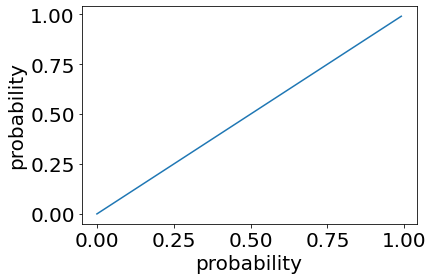

In [87]:
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
plt.xlabel('probability')
plt.ylabel('probability')

In [14]:
i=5
pmm_mean_matrix_denorm = utils.run_pmm_many_variables(test_data_mat['test_data_scaled'][mean_cases[i:i+5]])#mean_cases[:5]])

In [37]:
pmm_best_hits_matrix_denorm_new = utils.run_pmm_many_variables(test_data_mat['test_data_scaled'][test_lead10_all_indices['best_hit_indices']][0][:10,:,:,:])

0.522963324230644
0.0043
(32, 32, 7)
pass


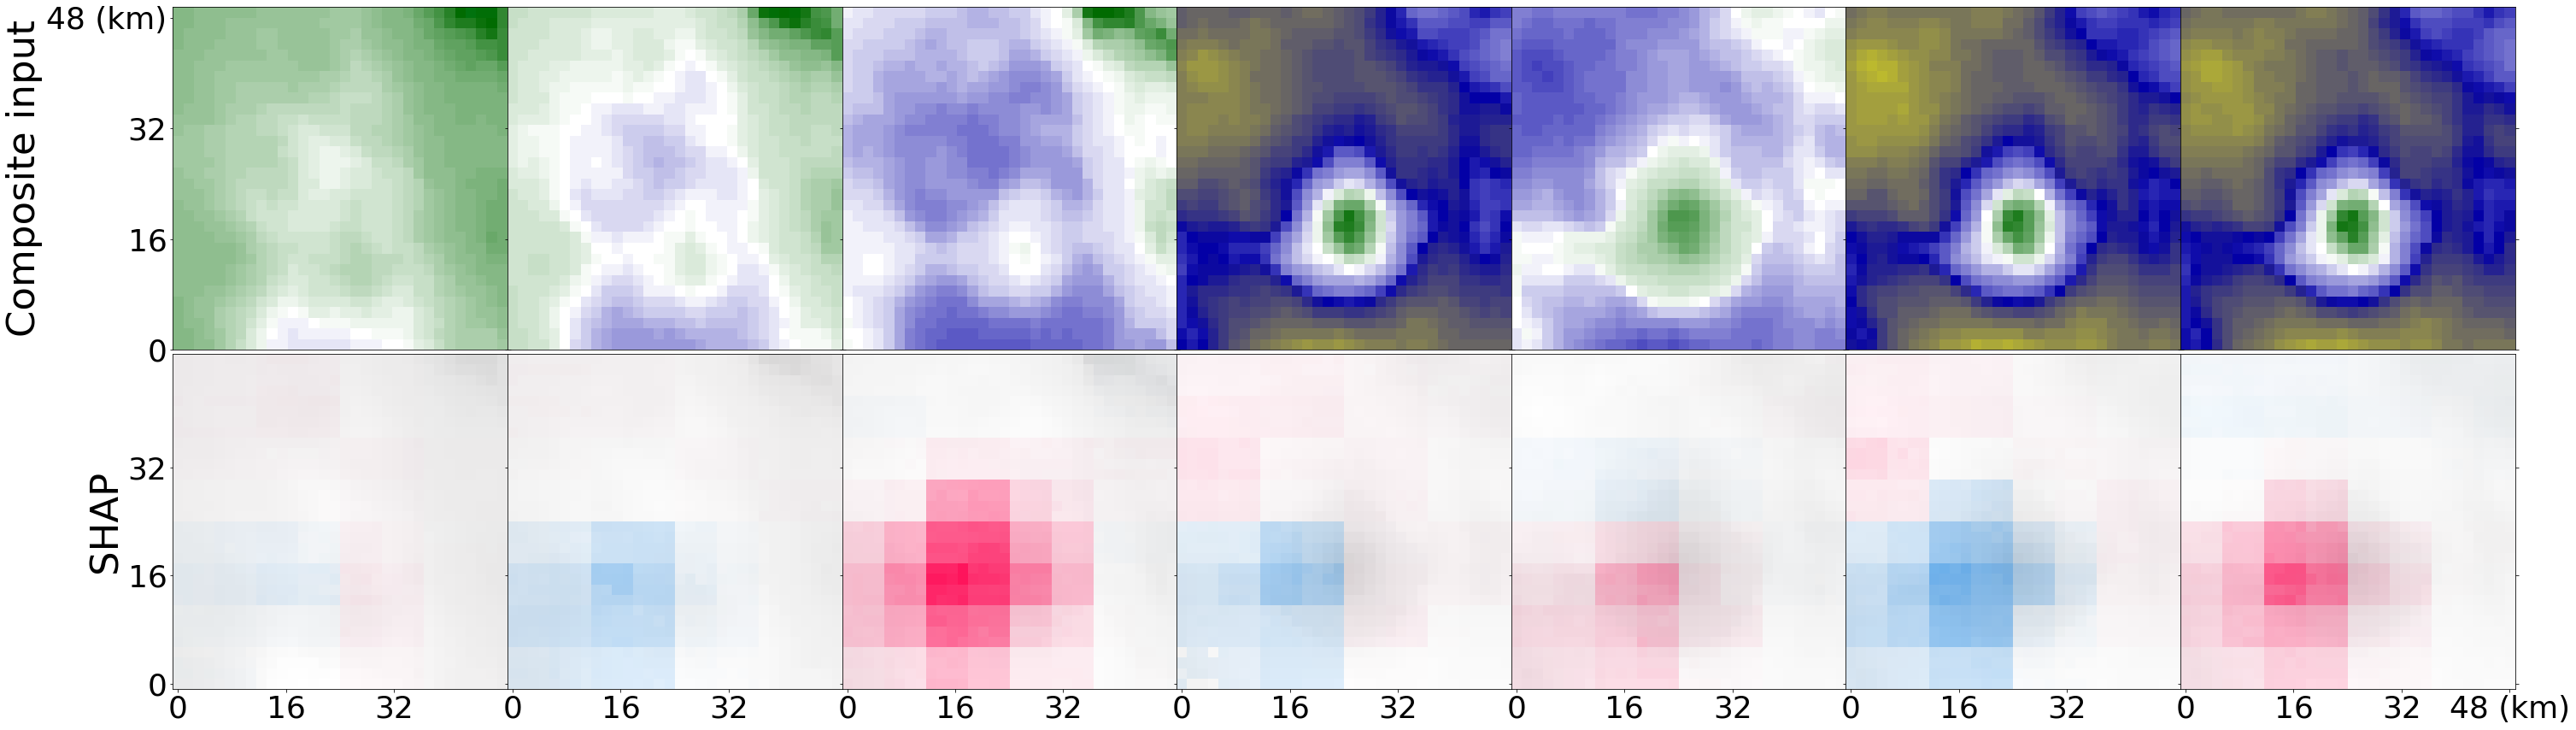

In [65]:
import copy
#test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(shap_values_old) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
#plot_storm_xai(pmm_best_hits_matrix_denorm,shap_values_pmm)
plot_storm_xai(pmm_best_hits_matrix_denorm,shap_values_pmm)

0.9091242429751489
0.00452132537954063
(32, 32, 7)
pass


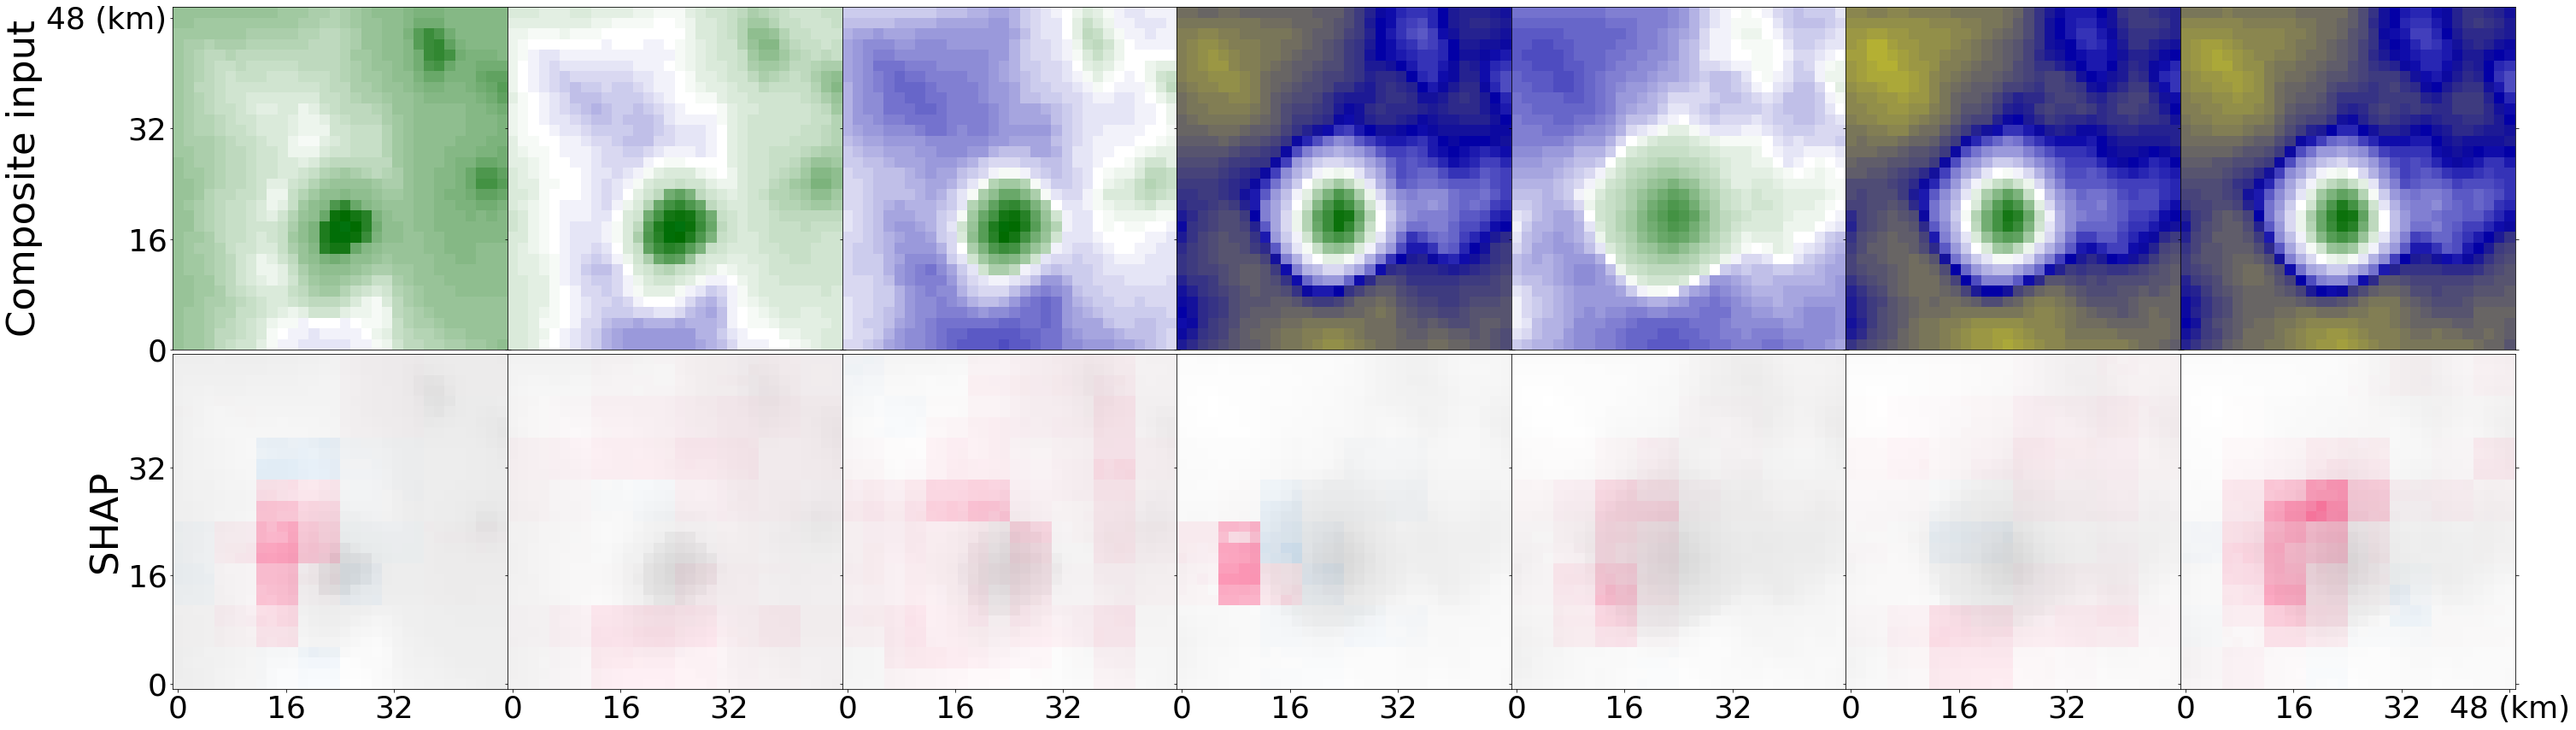

In [31]:
import copy
#test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(shap_values) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(pmm_best_hits_matrix_denorm,shap_values_pmm)

0.47682088130908423
0.002041978849638758
(32, 32, 7)
pass


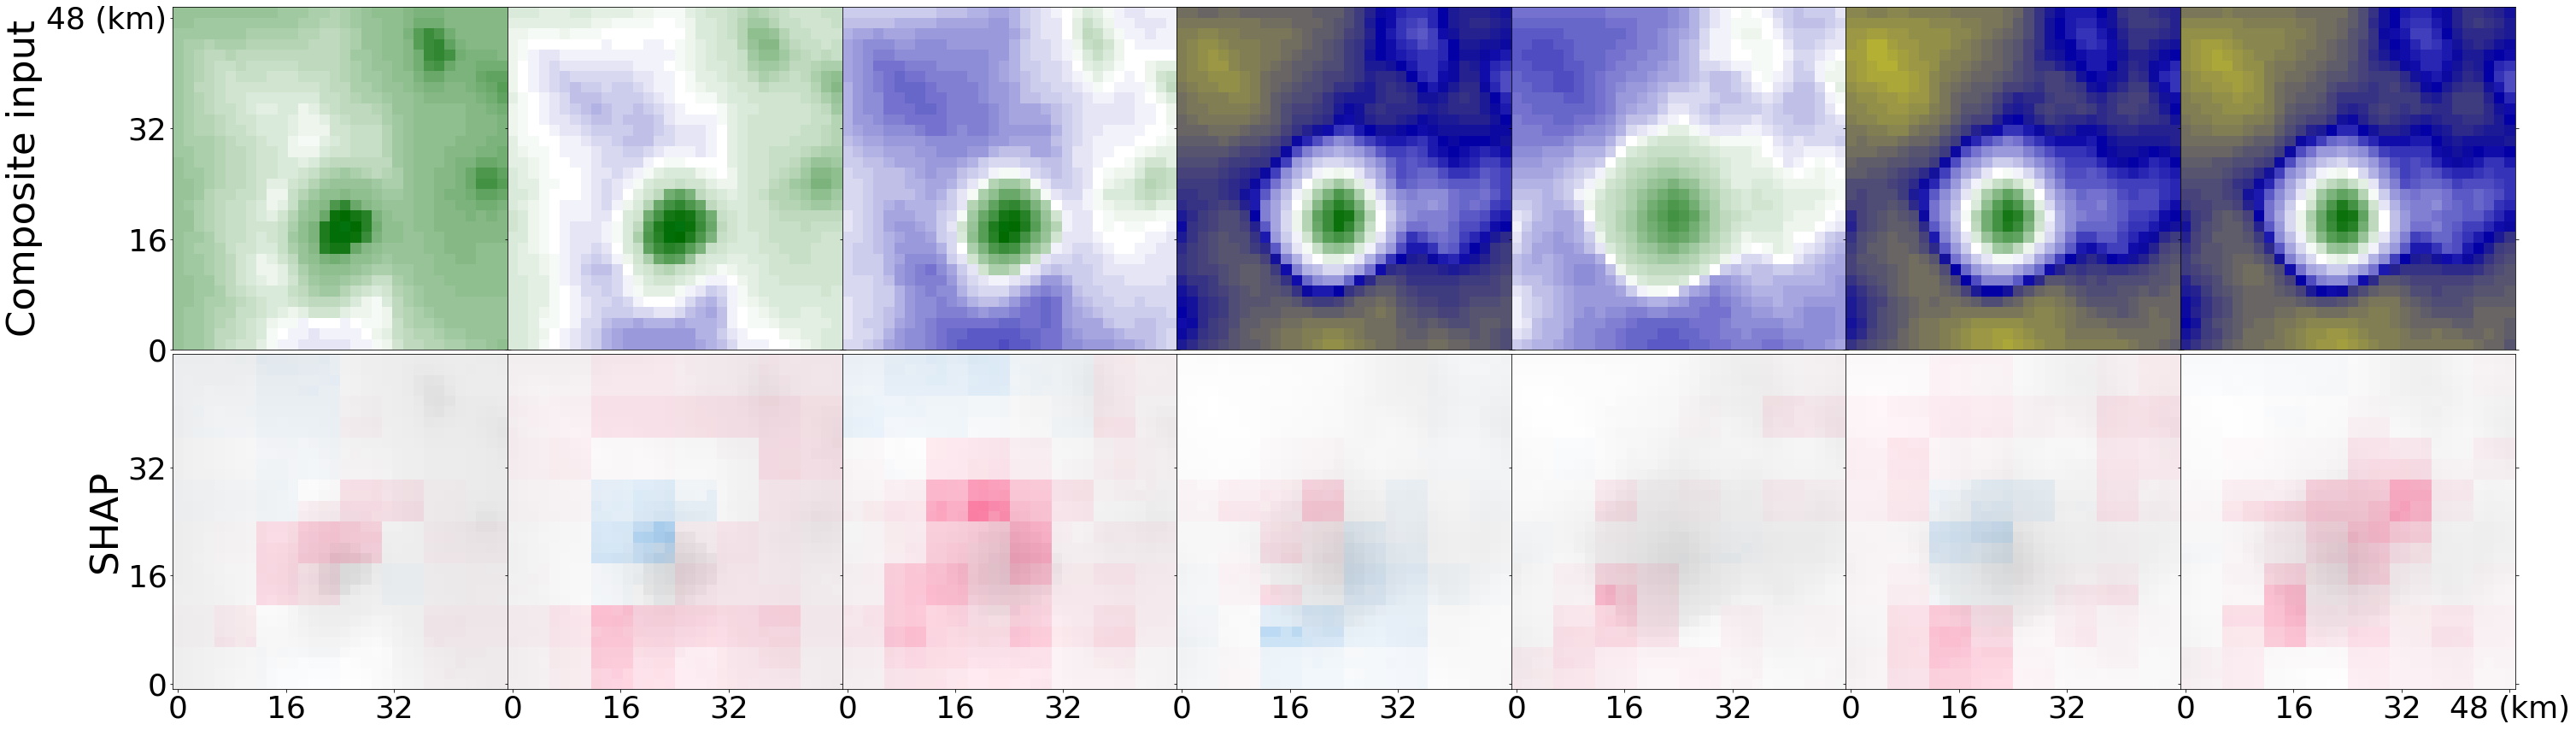

In [14]:
import copy
#test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(shap_values) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(pmm_best_hits_matrix_denorm,shap_values_pmm)

In [ ]:
import shap
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
shap_values_all = np.zeros((100,32,32,7,5))#100
X = best_hits_matrix_norm[0]
#Xplot = worst_false_alarm_matrix_denorm
# Evaluate 
#pmm_best_correct_null_matrix_denorm
for i in range(5):
    pmm_marker = test_data_mat['test_data_scaled'][mean_cases[i+5]]
    #np.mean(test_data['test_data_scaled'][mean_cases[:10]])#test_data['test_data_scaled'][mean_cases[i]]#np.mean(test_data_scaled[mean_cases],axis=0)#utils.run_pmm_many_variables(test_data_scaled[mean_cases])
    masker_uniform_0  = shap.maskers.Image(pmm_marker, X[0].shape, partition_scheme=1)

    #masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
    #masker_blur_32x32 = shap.maskers.Image("blur(32, 32)", X[0].shape, partition_scheme=1)
    results = explain_multiband(X, masker_uniform_0) #[:3,:,:,:]
    shap_values_all[:,:,:,:,i] = np.squeeze(results.values)
shap_values = np.mean(shap_values_all,axis=4)

In [34]:
print(np.sum(shap_values)/100)

0.230681127011776


In [36]:
print(np.sum(shap_values_pmm))

0.183706445708873


In [72]:
T = [0.54,0.48,0.45,0.5,0.48,0.5]

50

0.4452474257645278
0.0043
(32, 32, 7)
pass


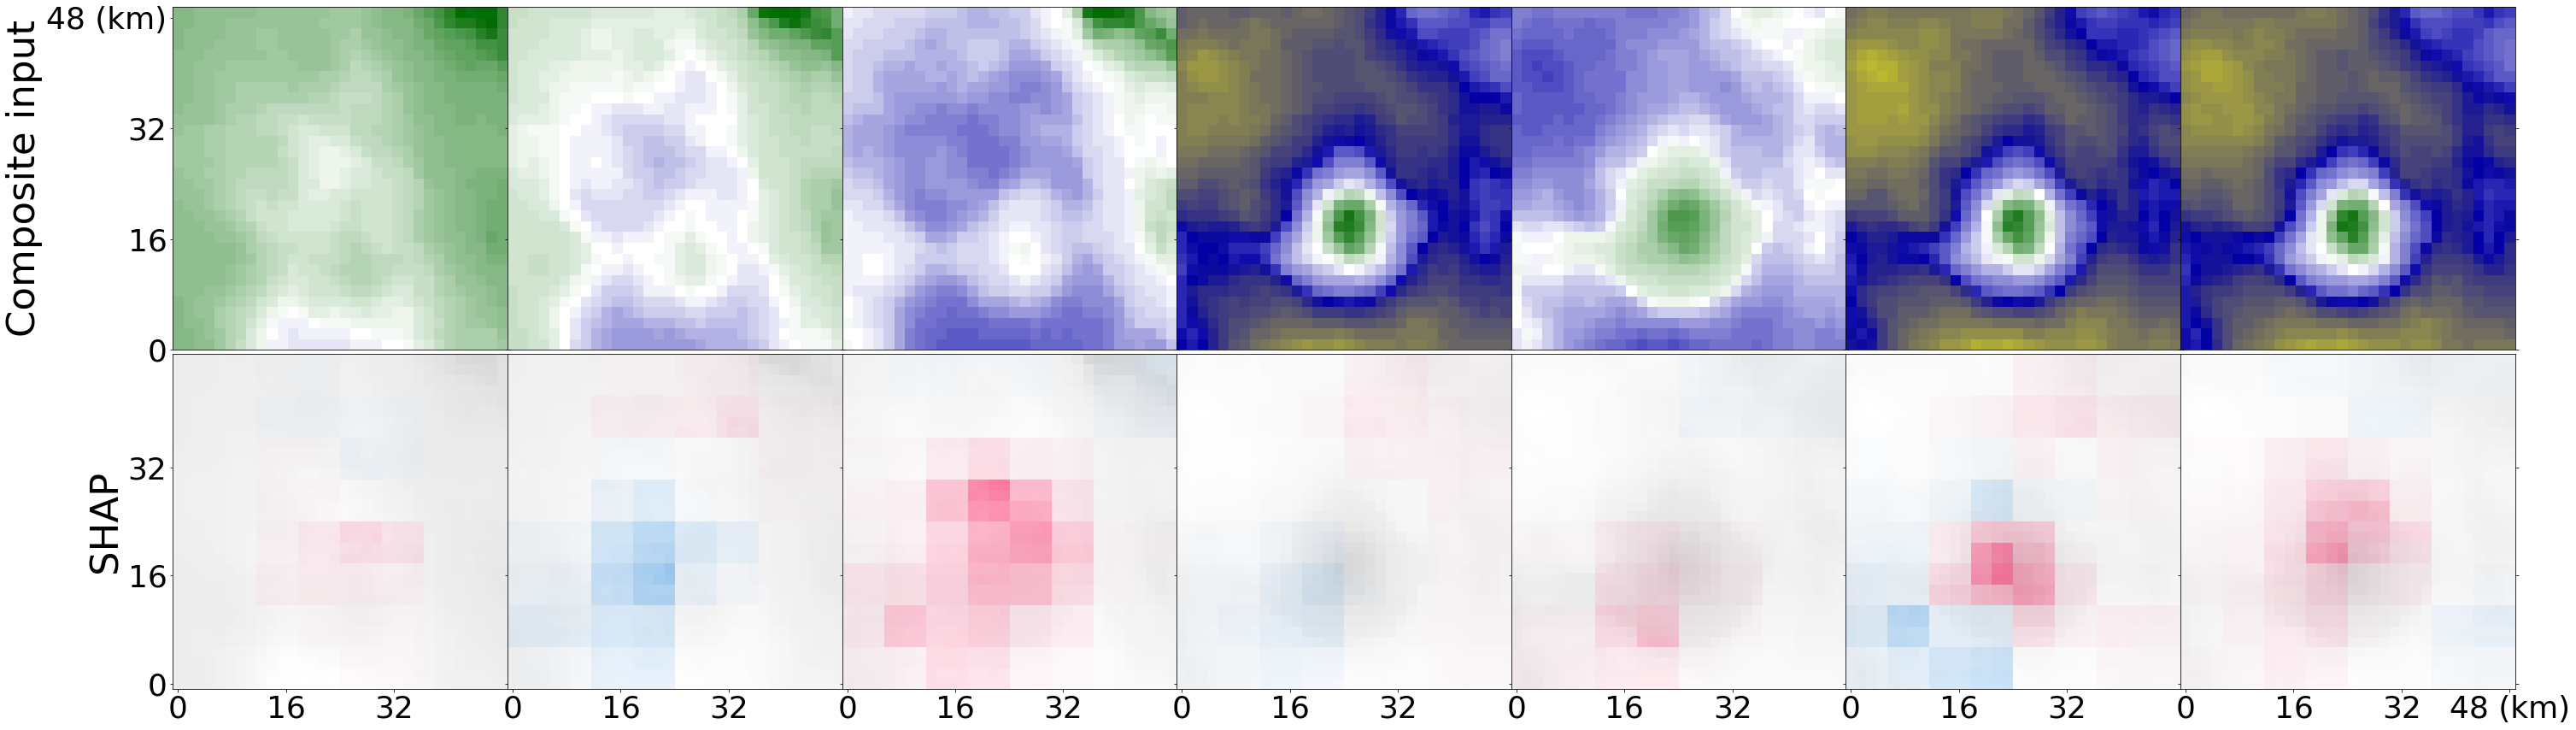

In [217]:
import copy
#test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(shap_values) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(pmm_best_hits_matrix_denorm,shap_values_pmm)

In [13]:
import scipy.io as scio
lead_time=10
scio.savemat('hits_shap_'+str(lead_time)+'min_best100@10min_new.mat',{'best_hits_matrix_norm':best_hits_matrix_norm[0], 'pmm_best_hits_matrix_denorm':pmm_best_hits_matrix_denorm,'shap_values':shap_values})

In [ ]:
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

In [52]:
import shap
X = best_hits_matrix_norm[0]
masker_blur = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
shap_values = explain_multiband(X[:10,:,:,:], masker_blur)

Partition explainer: 11it [00:30,  4.36s/it]                        


In [10]:
print(np.shape(shap_values))

(100, 32, 32, 7)


In [11]:
import scipy.io as scio
lead_time=10
scio.savemat('hits_shap_'+str(lead_time)+'min_best100@10min_warmbg.mat',{'best_hits_matrix_norm':best_hits_matrix_norm[0], 'pmm_best_hits_matrix_denorm':pmm_best_hits_matrix_denorm,'shap_values':shap_values})

In [35]:
import copy
#test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
#shap_values_pmm = utils.run_pmm_many_variables(test['shap_values']) #.values
#print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values[:,:,:,:,0])
plot_storm_xai(pmm_best_hits_matrix_denorm,shap_values_pmm)
#plt.savefig('plots/SHAP_hit.png')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [50]:
np.sum(shap_values_pmm[:,:,0]-shap_values_pmm[:,:,1])

0.0

In [46]:
np.shape(shap_values_pmm)

(32, 32, 7)

In [38]:
np.array(shap_values)[0].shape

(32, 1, 7, 1)

In [43]:
shap_values.values[:,:,:,:,0].shape

(10, 32, 32, 7)

In [24]:
print(np.sum(results.values,axis=(1,2,3)))

[[0.9655388 ]
 [0.96554273]
 [0.96554488]]


In [ ]:
import shap
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
shap_values_all = np.zeros((100,32,32,7,5))
X = best_correct_null_matrix_norm[0]
#Xplot = worst_false_alarm_matrix_denorm
# Evaluate 
#pmm_best_correct_null_matrix_denorm
for i in range(5):
    #pmm_marker = test_data_mat['test_data_scaled'][mean_cases[i]]
    #np.mean(test_data['test_data_scaled'][mean_cases[:10]])#test_data['test_data_scaled'][mean_cases[i]]#np.mean(test_data_scaled[mean_cases],axis=0)#utils.run_pmm_many_variables(test_data_scaled[mean_cases])
    #masker_uniform_0  = shap.maskers.Image(pmm_marker, X[0].shape, partition_scheme=1)

    masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
    #masker_blur_32x32 = shap.maskers.Image("blur(32, 32)", X[0].shape, partition_scheme=1)
    results = explain_multiband(X, masker_uniform_0) #[:3,:,:,:]
    shap_values_all[:,:,:,:,i] = np.squeeze(results.values)
shap_values = np.mean(shap_values_all,axis=4)

## Calculate deviation

In [11]:
# Calculate deviation term compared to warm background
import shap
import pickle
with open('scaler_lead_time/'+str(lead_time)+'min/std_scaler.bin', 'rb') as f:
    test_scaler = pickle.load(f)
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
Deviation_term = np.zeros((100,32,32,7))#100
X = best_hits_matrix_norm[0]
warm_bg_all = np.zeros((100,32,32,7))#100
# Evaluate 
for i in range(100):
    local_max = np.max(X[i,:,:,:],axis=(0,1))
    warm_bg = np.zeros_like(X[0])
    for j in range(np.shape(warm_bg)[-1]):
        warm_bg[:,:,j]=local_max[j]
        warm_bg_all[i,:,:,j] = local_max[j]
    Deviation_term[i,:,:,:] = test_scaler.reverse_transform(np.expand_dims(X[i,:,:,:], axis=0))\
    - test_scaler.reverse_transform(np.expand_dims(warm_bg, axis=0))

In [105]:
local_max[j]

1.3116593

In [104]:
np.round(warm_bg_all[0,:,:,1],8)==1.24053717

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [16]:
# Calculate deviation term compared to 0.5-probability samples
import shap
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
Deviation_term_2 = np.zeros((100,32,32,7))#100
X = best_hits_matrix_norm[0]
# Evaluate 
for i in range(100):
    Deviation_term_2[i,:,:,:] = test_scaler.reverse_transform(np.expand_dims(X[i,:,:,:], axis=0)) - \
    test_scaler.reverse_transform(np.expand_dims(pmm_mean_matrix_denorm, axis=0))

NameError: name 'pmm_mean_matrix_denorm' is not defined

In [31]:
Deviation_term_2.shape

(100, 32, 32, 7)

## Plot (composite input, deviation, shap, deviation_2, shap_2)

0.7429832391518941
-45.03708359465486
49.670859032971606
-74.39906311035156
-0.1049652099609375
0.0043
(32, 32, 7)


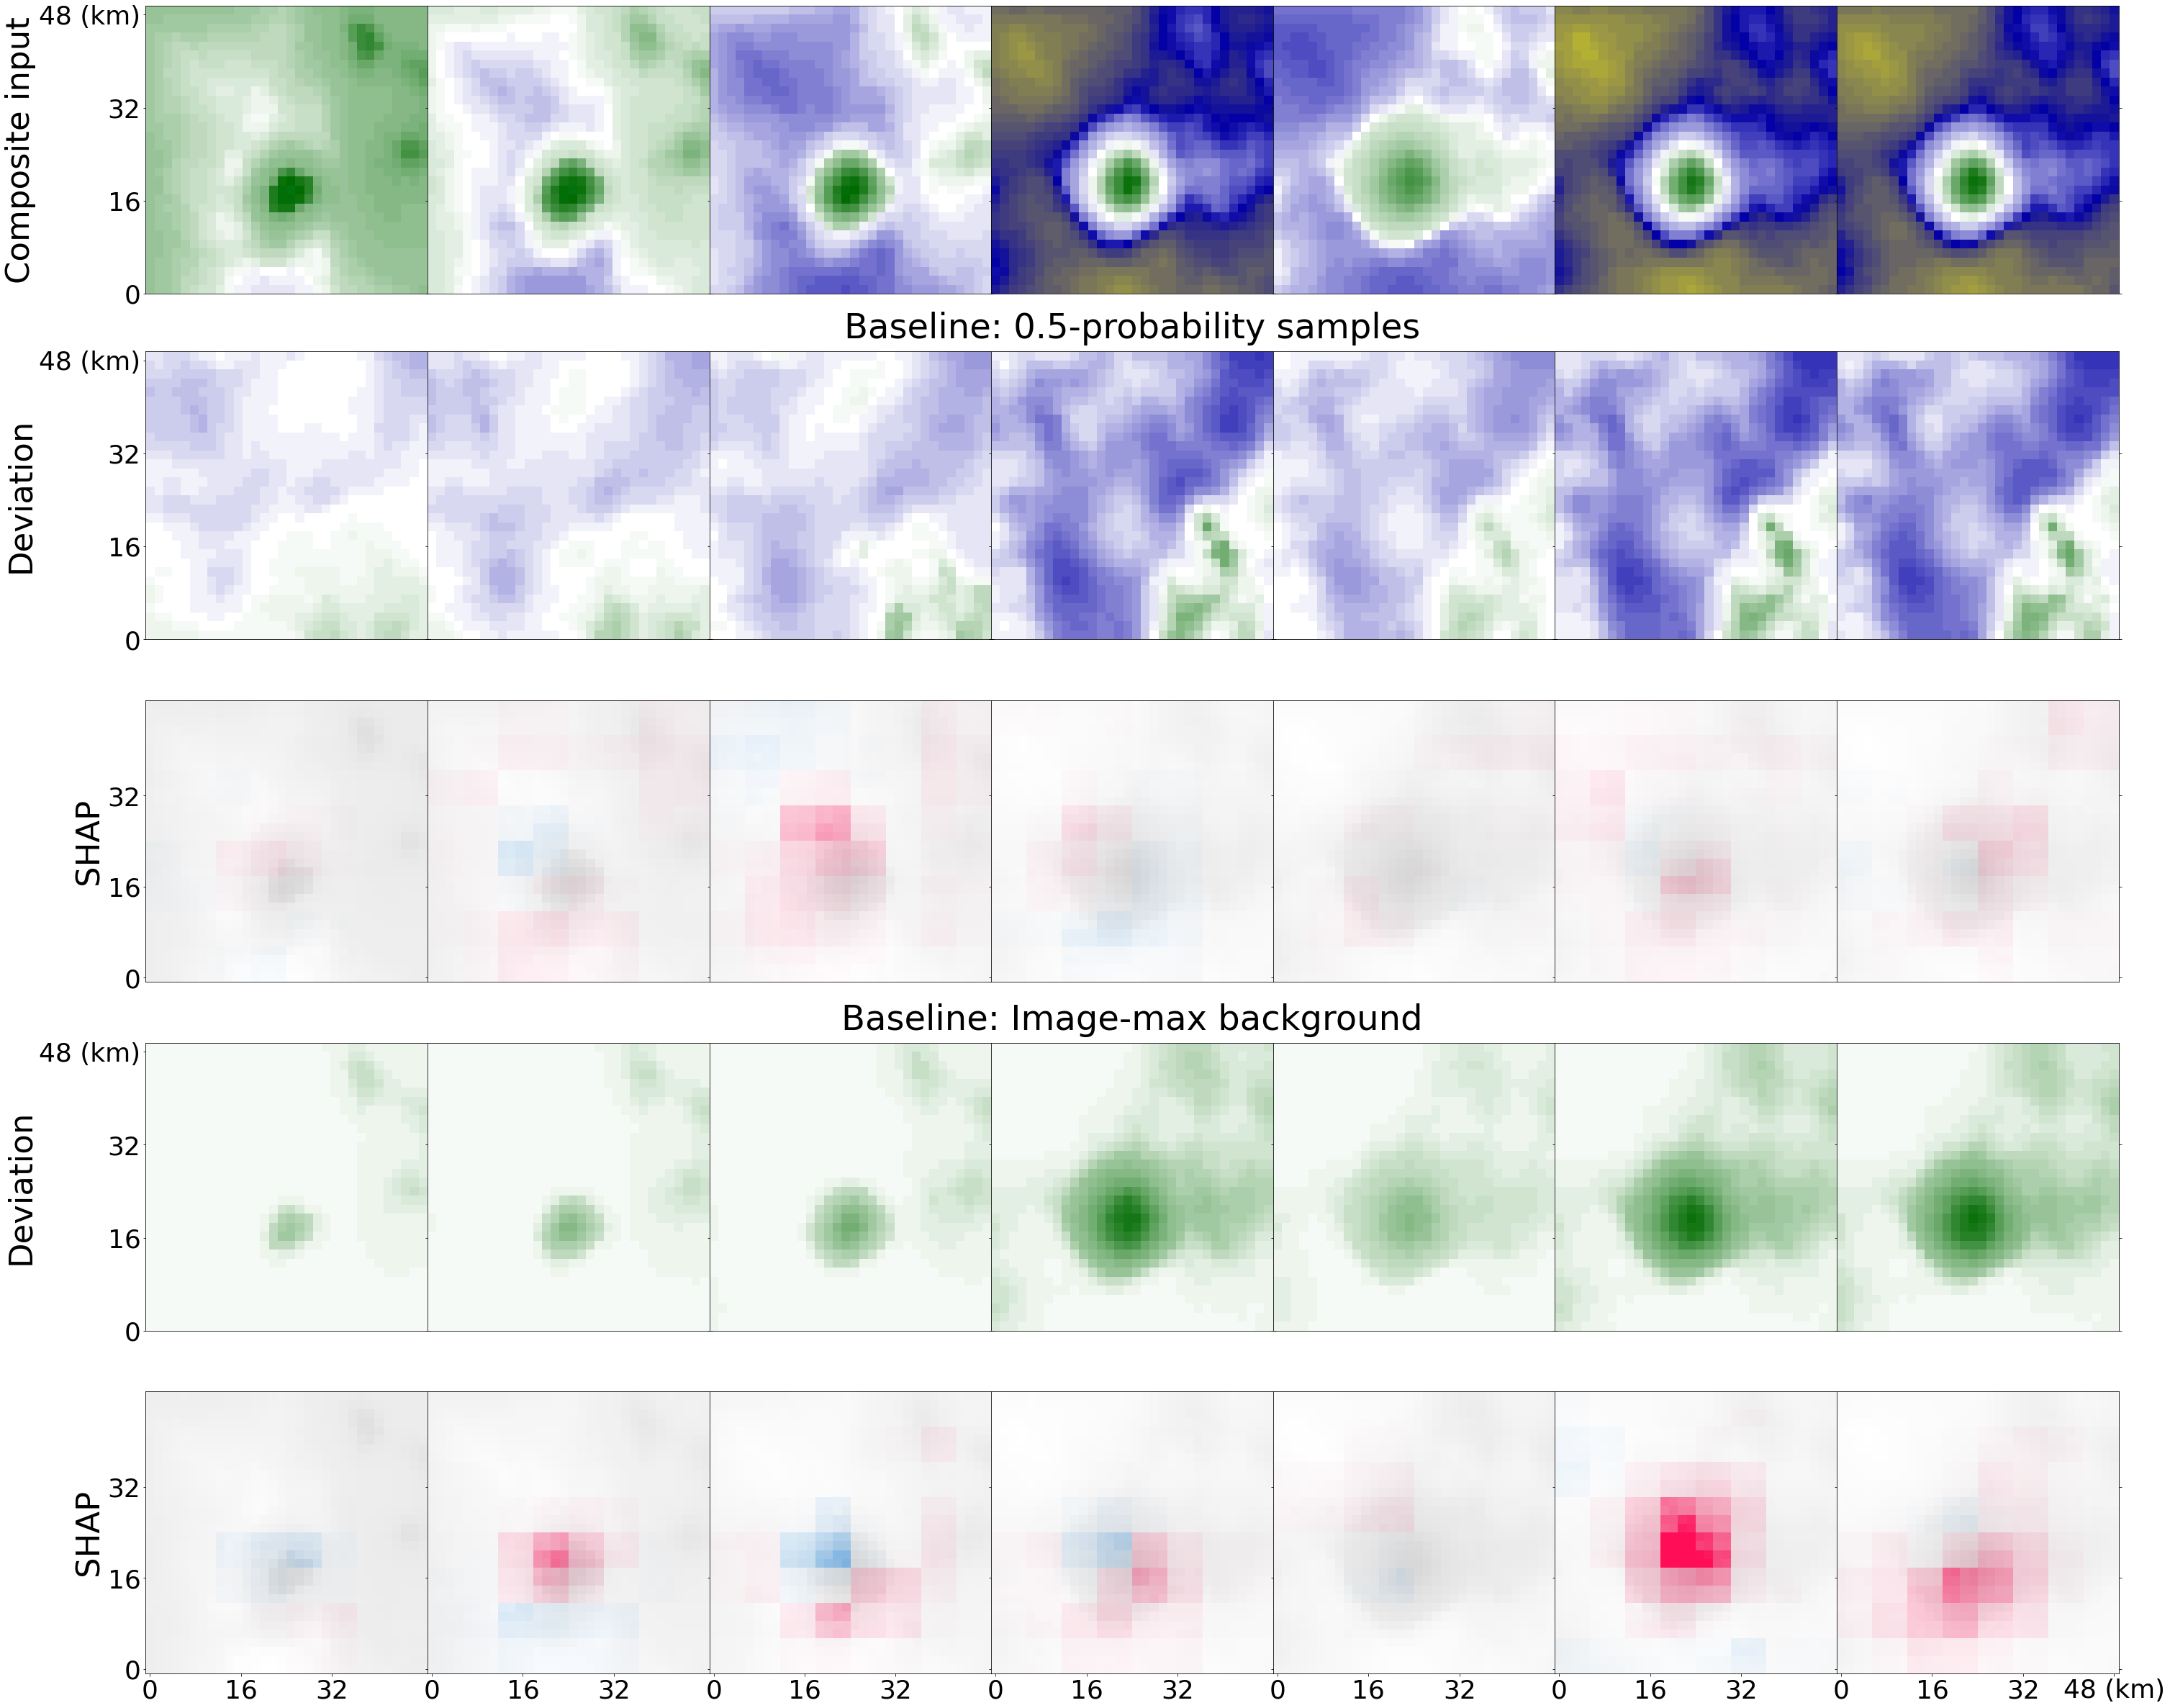

In [93]:
import copy
#test=scio.loadmat('hits_shap.mat')
meanbg = scio.loadmat('hits_shap_'+str(lead_time)+'min_best100@10min.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(shap_values) #.values
shap_values_pmm_2 = utils.run_pmm_many_variables(meanbg['shap_values']) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
Deviation_term_denorm = utils.run_pmm_many_variables(Deviation_term)
Deviation_term_denorm_2 = utils.run_pmm_many_variables(Deviation_term_2)
plot_storm_xai(pmm_best_hits_matrix_denorm,Deviation_term_denorm_2,shap_values_pmm_2, Deviation_term_denorm,shap_values_pmm)#,shap_values_pmm)#[:,:,:,0]

(32, 32, 7)


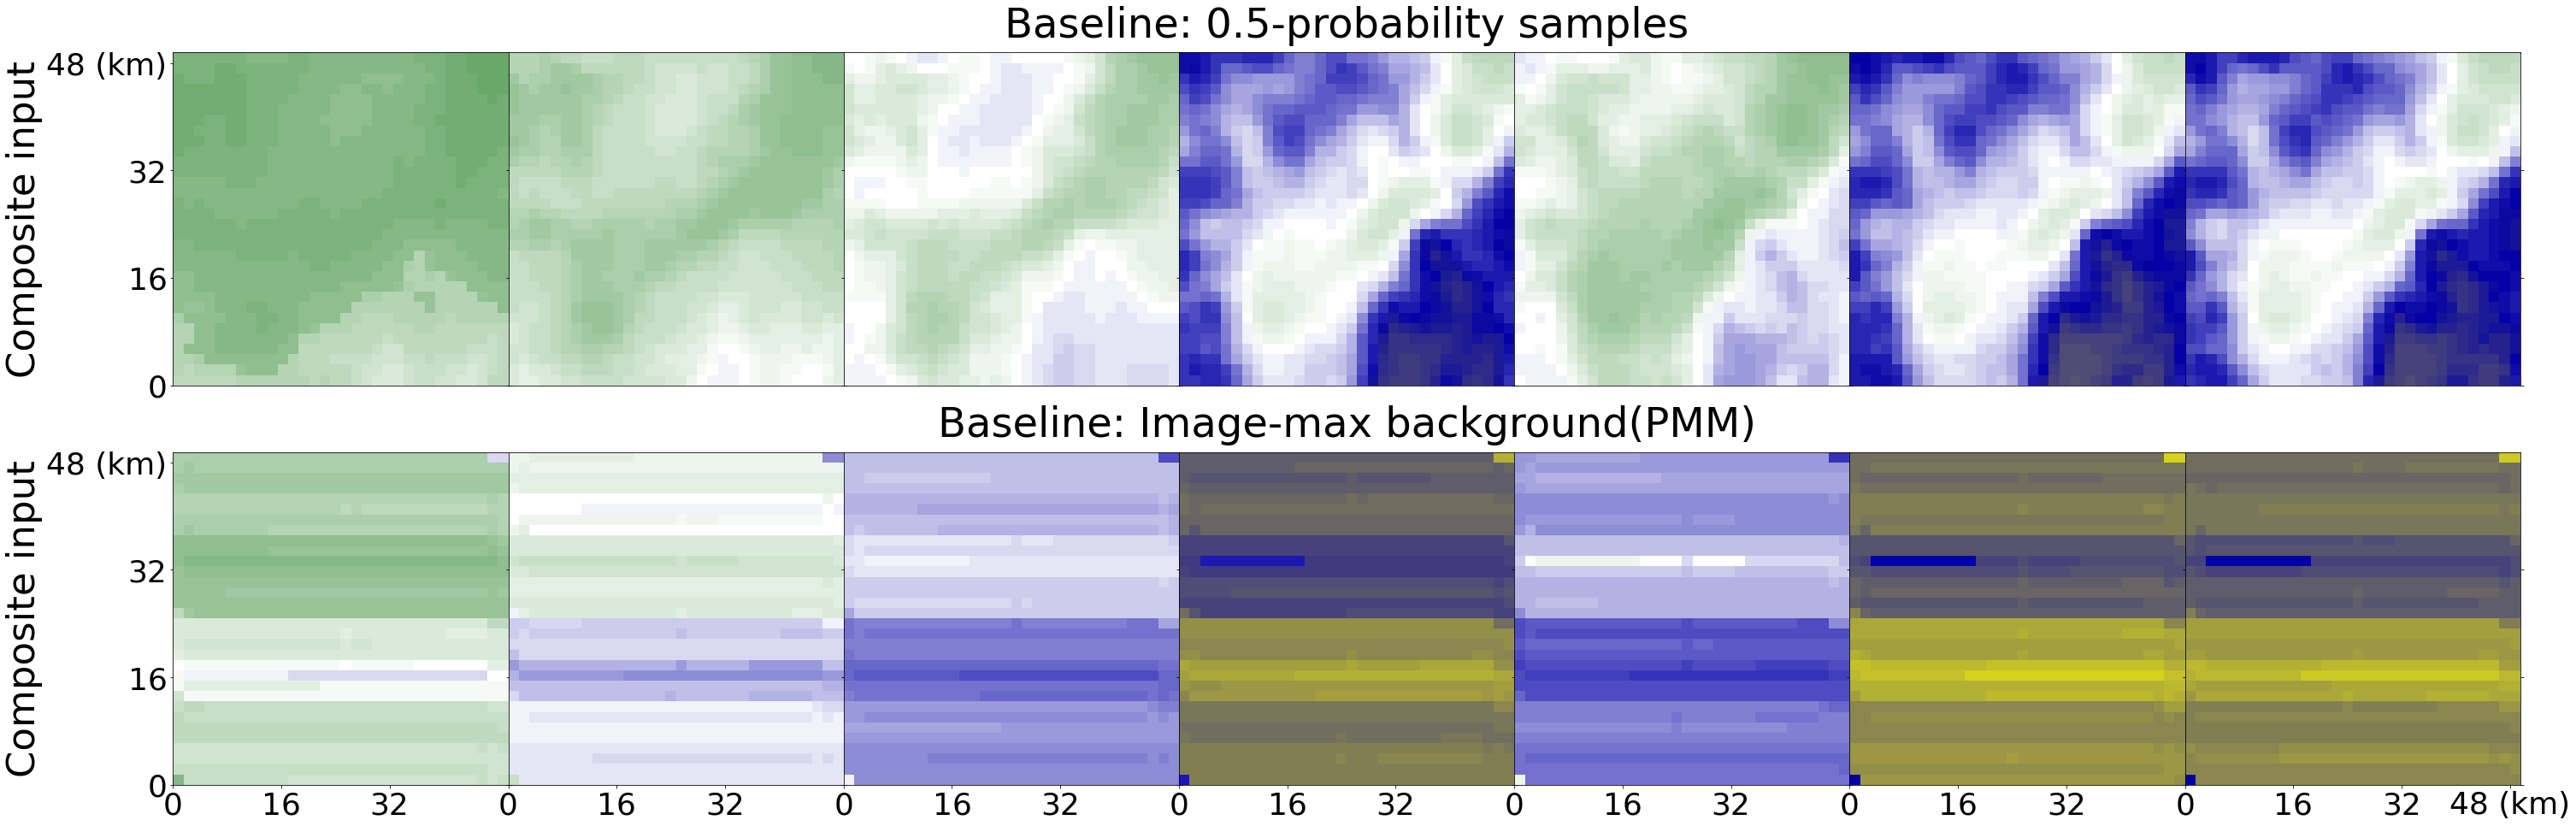

In [64]:
import copy
warm_bg = utils.run_pmm_many_variables(warm_bg_all) #.values
#pmm_mean_matrix_denorm
plot_storm_xai_bg(pmm_mean_matrix_denorm,warm_bg)#np.mean(warm_bg_all,axis=0))#warm_bg)#warm_bg_all[0])#warm_bg[0])

In [58]:
en_mean.shape

(32, 32)

In [56]:
from scipy.interpolate import interp1d
import numpy as np
max_percentile_level = 100#99
field_matrix = warm_bg_all[:,:,:,0]
# Pool values over all dimensions and remove extremes.
pooled_values = np.sort(np.ravel(field_matrix))
print(pooled_values.shape)
print(pooled_values)
max_pooled_value = np.percentile(pooled_values, max_percentile_level)
print(max_pooled_value)
pooled_values = pooled_values[pooled_values <= max_pooled_value]
print(pooled_values)
print(pooled_values.shape)
min_pooled_value = np.percentile(
    pooled_values, 100 - max_percentile_level
)
print(min_pooled_value)
pooled_values = pooled_values[pooled_values >= min_pooled_value]
print(pooled_values)
print(pooled_values.shape)
# Find ensemble mean at each location (e.g., grid point).
mean_field_matrix = np.mean(field_matrix, axis=0)
en_mean = mean_field_matrix
print(mean_field_matrix)
mean_field_flattened = np.ravel(mean_field_matrix)
print("mean_field_flattened")
print(mean_field_flattened)
print(mean_field_flattened.shape)

# At each location, replace ensemble mean with the same percentile from the
# pooled array.
pooled_value_percentiles = np.linspace(
    0, 100, num=len(pooled_values), dtype=float
)
print(pooled_value_percentiles)
mean_value_percentiles = np.linspace(
    0, 100, num=len(mean_field_flattened), dtype=float
)
print(mean_value_percentiles)
sort_indices = np.argsort(mean_field_flattened)
print(sort_indices)
unsort_indices = np.argsort(sort_indices)

interp_object = interp1d(
    pooled_value_percentiles, pooled_values, kind='linear',
    bounds_error=True, assume_sorted=True
)

mean_field_flattened = interp_object(mean_value_percentiles)
print(mean_field_flattened)
mean_field_flattened = mean_field_flattened[unsort_indices]
mean_field_matrix = np.reshape(
    mean_field_flattened, mean_field_matrix.shape
)

(102400,)
[0.61807144 0.61807144 0.61807144 ... 2.37496114 2.37496114 2.37496114]
2.3749611377716064
[0.61807144 0.61807144 0.61807144 ... 2.37496114 2.37496114 2.37496114]
(102400,)
0.618071436882019
[0.61807144 0.61807144 0.61807144 ... 2.37496114 2.37496114 2.37496114]
(102400,)
[[1.26938411 1.26938411 1.26938411 ... 1.26938411 1.26938411 1.26938411]
 [1.26938411 1.26938411 1.26938411 ... 1.26938411 1.26938411 1.26938411]
 [1.26938411 1.26938411 1.26938411 ... 1.26938411 1.26938411 1.26938411]
 ...
 [1.26938411 1.26938411 1.26938411 ... 1.26938411 1.26938411 1.26938411]
 [1.26938411 1.26938411 1.26938411 ... 1.26938411 1.26938411 1.26938411]
 [1.26938411 1.26938411 1.26938411 ... 1.26938411 1.26938411 1.26938411]]
mean_field_flattened
[1.26938411 1.26938411 1.26938411 ... 1.26938411 1.26938411 1.26938411]
(1024,)
[0.00000000e+00 9.76572037e-04 1.95314407e-03 ... 9.99980469e+01
 9.99990234e+01 1.00000000e+02]
[0.00000000e+00 9.77517107e-02 1.95503421e-01 ... 9.98044966e+01
 9.9902248

In [52]:
mean_field_flattened

array([0.61807144, 1.41821587, 1.41821587, ..., 1.01172507, 2.37496114,
       2.37496114])

In [50]:
mean_field_matrix#.shape

array([[0.61807144, 1.41821587, 1.41821587, ..., 1.41821587, 1.44081581,
        1.41821587],
       [1.40252769, 1.37730956, 1.37730956, ..., 1.41821587, 1.45106149,
        1.51057303],
       [1.45106149, 1.51375782, 1.51375782, ..., 1.51057303, 1.51463902,
        1.51057303],
       ...,
       [0.95537007, 0.94428343, 0.93140322, ..., 0.95252573, 0.95252573,
        1.00314903],
       [1.01172507, 1.00314903, 1.01172507, ..., 1.0604378 , 1.01172507,
        1.05309701],
       [1.01172507, 1.0048269 , 1.00314903, ..., 1.01172507, 2.37496114,
        2.37496114]])

In [24]:
warm_bg_all[10,:,:,0]#.shape

array([[0.92141306, 0.92141306, 0.92141306, ..., 0.92141306, 0.92141306,
        0.92141306],
       [0.92141306, 0.92141306, 0.92141306, ..., 0.92141306, 0.92141306,
        0.92141306],
       [0.92141306, 0.92141306, 0.92141306, ..., 0.92141306, 0.92141306,
        0.92141306],
       ...,
       [0.92141306, 0.92141306, 0.92141306, ..., 0.92141306, 0.92141306,
        0.92141306],
       [0.92141306, 0.92141306, 0.92141306, ..., 0.92141306, 0.92141306,
        0.92141306],
       [0.92141306, 0.92141306, 0.92141306, ..., 0.92141306, 0.92141306,
        0.92141306]])

In [21]:
warm_bg[:,:,0]#.shape

array([[0.61807144, 1.41821587, 1.41821587, ..., 1.41821587, 1.4370364 ,
        1.40415168],
       [1.40252769, 1.37730956, 1.37730956, ..., 1.40415168, 1.45106149,
        1.51057303],
       [1.45106149, 1.51057303, 1.51057303, ..., 1.51057303, 1.51375782,
        1.51057303],
       ...,
       [0.95252573, 0.94428343, 0.92812562, ..., 0.95252573, 0.95252573,
        0.99286836],
       [1.00958443, 0.99286836, 1.01172507, ..., 1.05644178, 1.01172507,
        1.05309701],
       [1.00958443, 1.0048269 , 1.00314903, ..., 1.00958443, 2.36131811,
        2.36131811]])

In [18]:
warm_bg.shape

(32, 32, 7)

In [33]:
np.shape(warm_bg_all)[-1]

7

In [ ]:
for i in range(np.shape(warm_bg_all)[0]):
    for j in range(np.shape(warm_bg_all)[-1]):
        print(np.max(warm_bg_all[i,:,:,j])-np.min(warm_bg_all[i,:,:,j]))

In [25]:
warm_bg.shape

(32, 32, 7)

In [112]:
warm_bg[:,:,0]

array([[0.61807144, 1.41821587, 1.41821587, ..., 1.41821587, 1.43703628,
        1.40415168],
       [1.40252769, 1.37730956, 1.37730956, ..., 1.40415168, 1.45106149,
        1.51057291],
       [1.45106149, 1.51057291, 1.51057291, ..., 1.51057291, 1.51375771,
        1.51057291],
       ...,
       [0.95252573, 0.94428343, 0.92812562, ..., 0.95252573, 0.95252573,
        0.99286842],
       [1.00958443, 0.99286842, 1.01172507, ..., 1.05644178, 1.01172507,
        1.05309701],
       [1.00958443, 1.0048269 , 1.00314903, ..., 1.00958443, 2.36131811,
        2.36131811]])

In [99]:
warm_bg

array([[[0.61807144, 0.7576437 , 0.8654682 , ..., 0.54291934,
         0.85458106, 0.89117879],
        [1.41821587, 1.38191879, 1.41869771, ..., 1.60380888,
         1.5868727 , 1.56753337],
        [1.41821587, 1.38191879, 1.41869771, ..., 1.60380888,
         1.5868727 , 1.56753337],
        ...,
        [1.41821587, 1.38191879, 1.41869771, ..., 1.60380888,
         1.5868727 , 1.56753337],
        [1.4370364 , 1.39340937, 1.42984223, ..., 1.61492264,
         1.59007919, 1.56845558],
        [1.40415168, 1.37383151, 1.40644574, ..., 1.59991884,
         1.57760775, 1.56270957]],

       [[1.40252769, 1.37232995, 1.3951726 , ..., 1.59758651,
         1.57667851, 1.56171441],
        [1.37730956, 1.37204278, 1.39257658, ..., 1.58884919,
         1.55665052, 1.55843568],
        [1.37730956, 1.37204278, 1.39257658, ..., 1.58884919,
         1.55665052, 1.55843568],
        ...,
        [1.40415168, 1.37383151, 1.40644574, ..., 1.59991884,
         1.57760775, 1.56270957],
        [1.4

0.7429925685200213
[25.42742851 28.64183071 30.73701534 49.46018999 27.72580015 52.18635383
  3.65674903]
0.0043
(32, 32, 7)
pass
3.6567490308837023


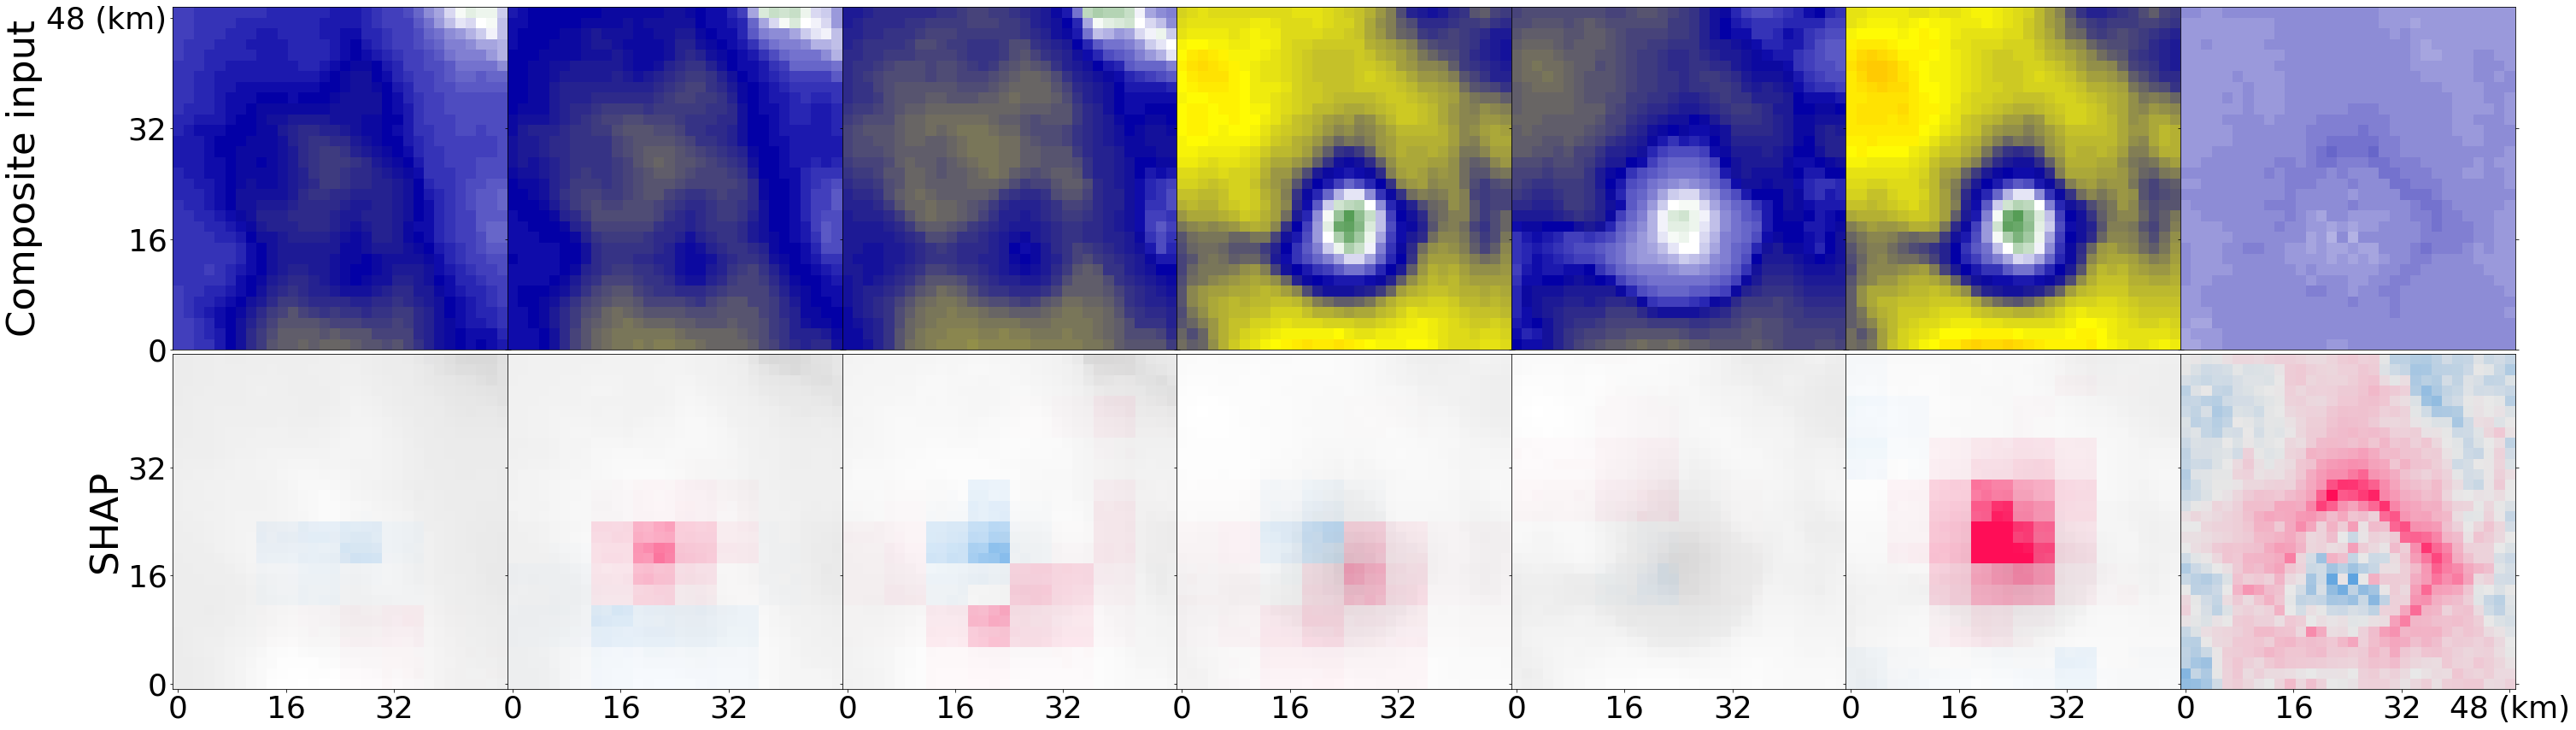

In [56]:
import copy
#test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(shap_values) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(pmm_best_hits_matrix_denorm,shap_values_pmm)#[:,:,:,0]

0.7429925685200213
[18.71509749 21.35187142 24.64490201 47.19637347 27.73741012 49.67085884
 49.33885367]
0.0043
(32, 32, 7)
pass


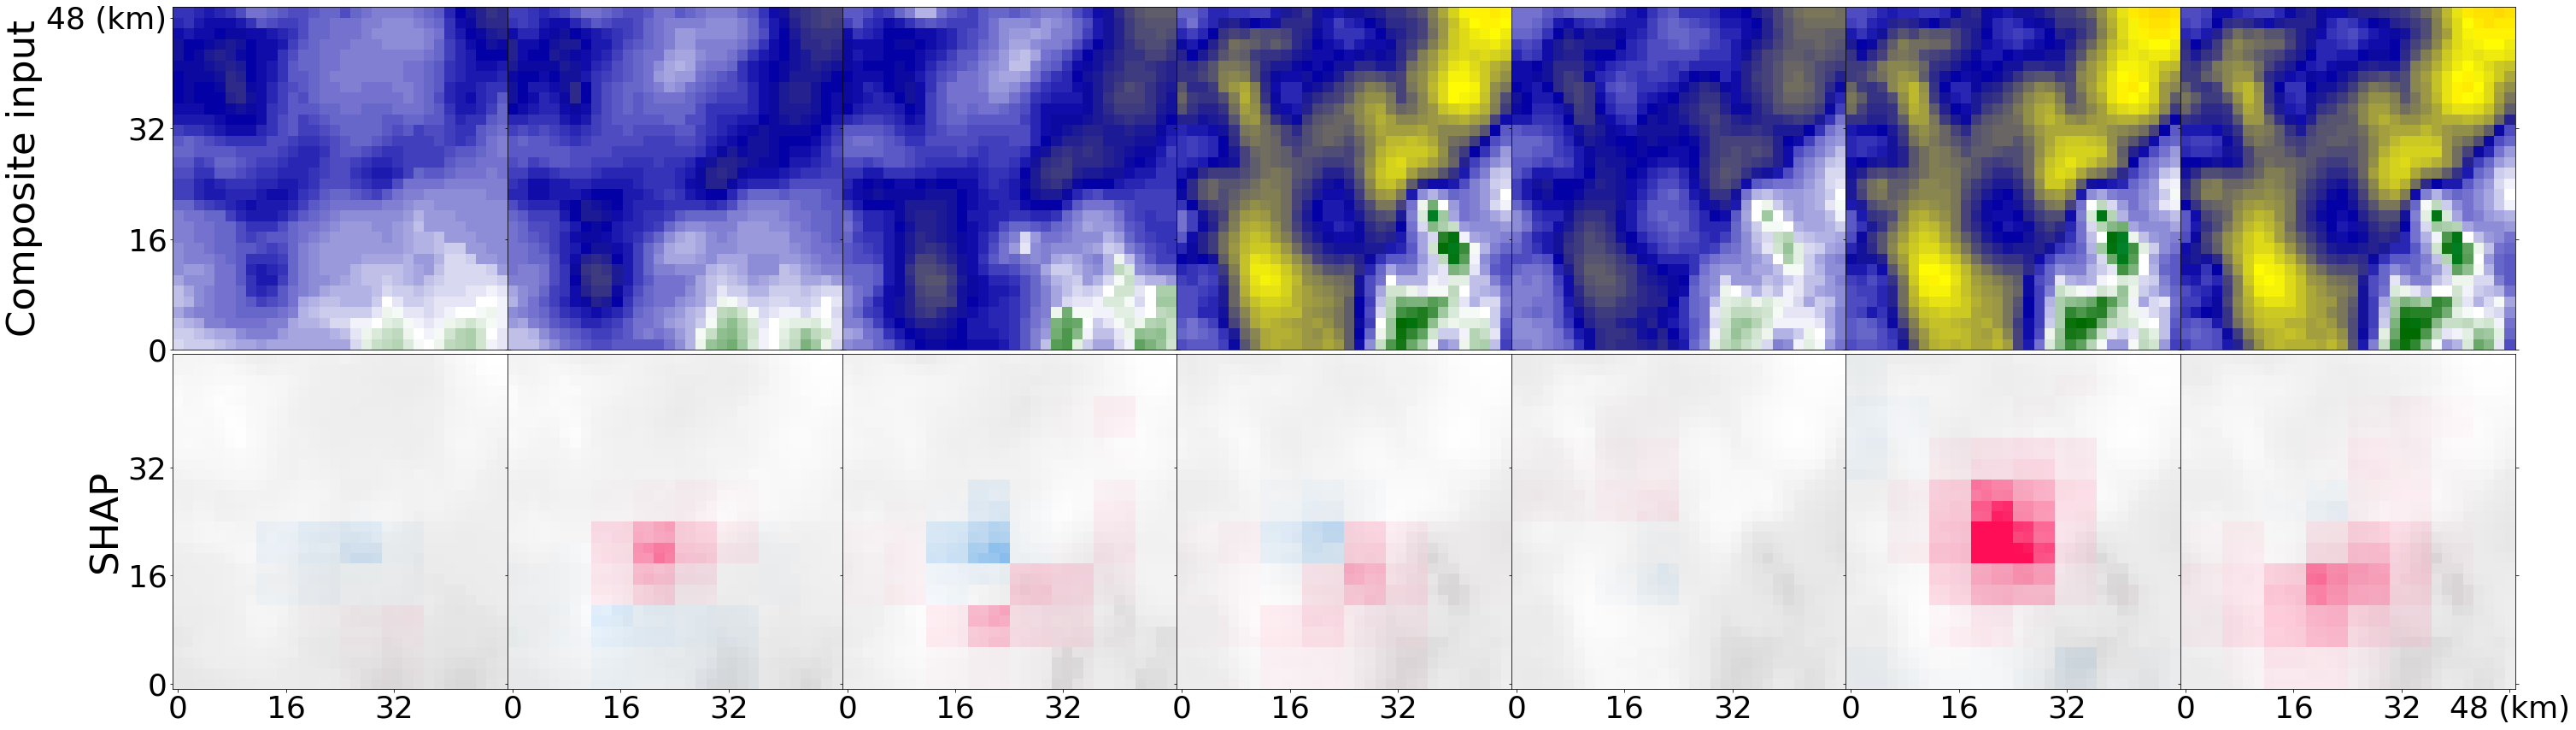

In [48]:
import copy
#test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(shap_values) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
Deviation_term_denorm = utils.run_pmm_many_variables(Deviation_term)
plot_storm_xai(Deviation_term_denorm,shap_values_pmm)#[:,:,:,0]

0.7429925685200213
0.0043
(32, 32, 7)
pass


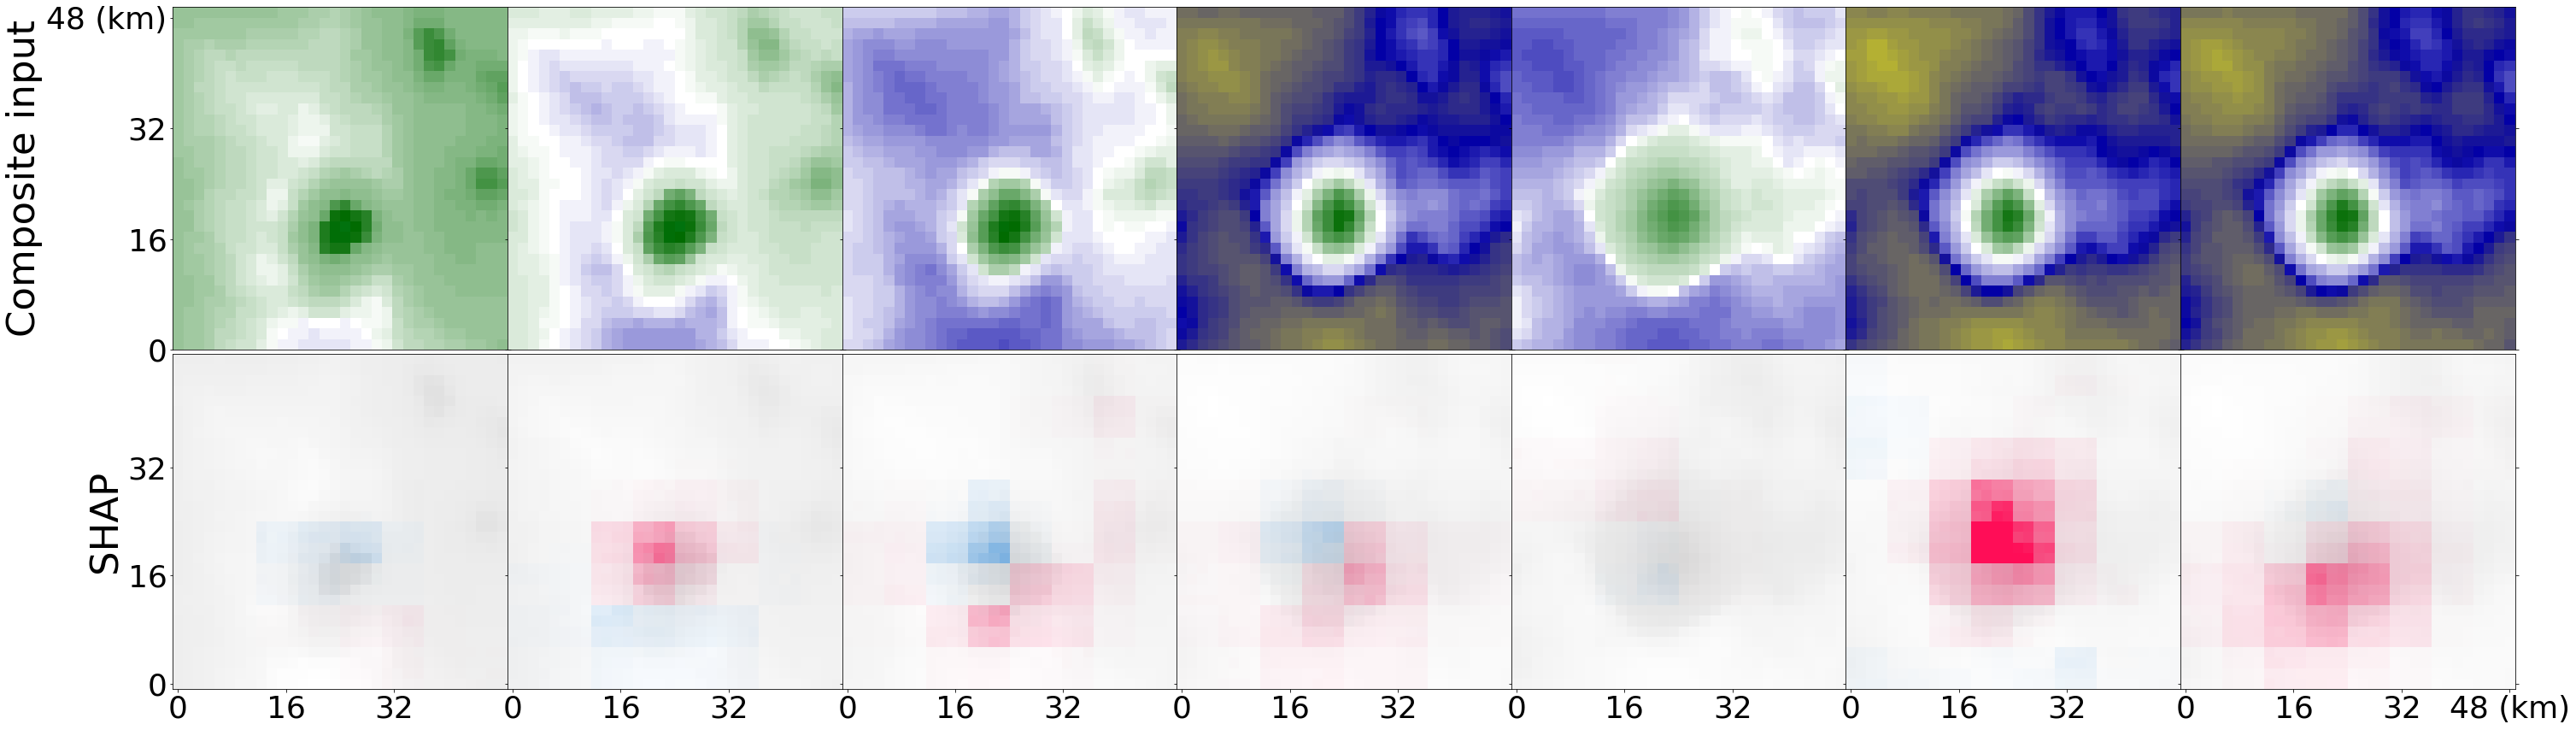

In [13]:
import copy
#test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(shap_values) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
Deviation_term_denorm = utils.run_pmm_many_variables(Deviation_term)
plot_storm_xai(pmm_best_hits_matrix_denorm,shap_values_pmm)#[:,:,:,0]

0.35311110649594396
0.0043
(32, 32, 7)
pass


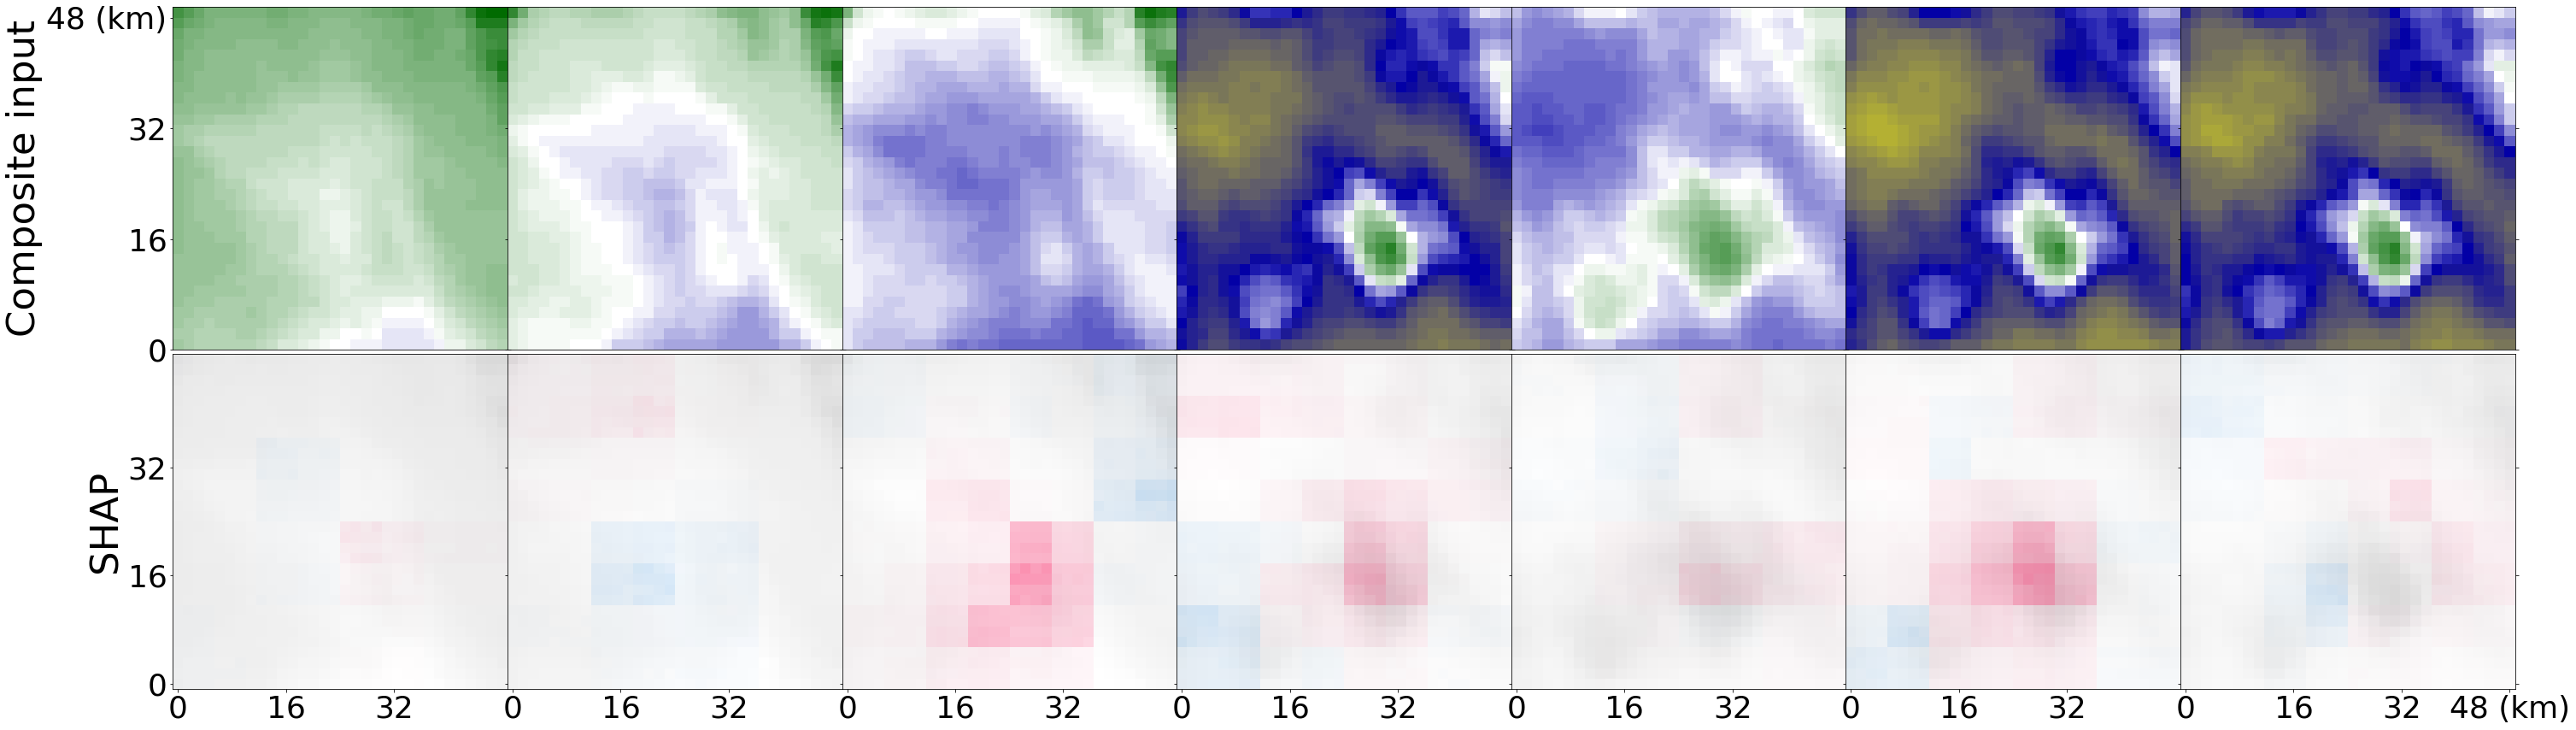

In [214]:
import scipy.io as scio
lead_time = 30
test = scio.loadmat('hits_shap_'+str(lead_time)+'min_best100@10min.mat')
import copy
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(test['shap_values']) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(test['pmm_best_hits_matrix_denorm'],shap_values_pmm)

In [17]:
import scipy.io as scio
scio.savemat('correct_null_shap.mat',{'best_hits_matrix_norm':best_correct_null_matrix_norm[0], 'pmm_best_hits_matrix_denorm':pmm_best_correct_null_matrix_denorm,'shap_values':shap_values})

In [19]:
import scipy.io as scio
scio.savemat('miss_shap.mat',{'best_hits_matrix_norm':worst_miss_matrix_norm[0], 'pmm_best_hits_matrix_denorm':pmm_worst_miss_matrix_denorm,'shap_values':shap_values})

In [34]:
np.shape(shap_values_all)

(100, 32, 32, 7, 5)

In [15]:
import scipy.io as scio
scio.savemat('false_alarm_shap.mat',{'best_hits_matrix_norm':worst_false_alarm_matrix_norm[0], 'pmm_best_hits_matrix_denorm':pmm_worst_false_alarm_matrix_denorm,'shap_values':shap_values})

In [13]:
import scipy.io as scio
scio.savemat('hits_shap.mat',{'best_hits_matrix_norm':best_hits_matrix_norm[0], 'pmm_best_hits_matrix_denorm':pmm_best_hits_matrix_denorm,'shap_values':shap_values})

In [36]:
import scipy.io as scio
test=scio.loadmat('hits_shap.mat')#,{'best_hits_matrix_norm':best_correct_null_matrix_norm[0], 'pmm_best_hits_matrix_denorm':pmm_best_correct_null_matrix_denorm,'shap_values':shap_values})
print(test['shap_values'].shape)

(100, 32, 32, 7)


-0.4307005873364124
0.0043
(32, 32, 7)
pass


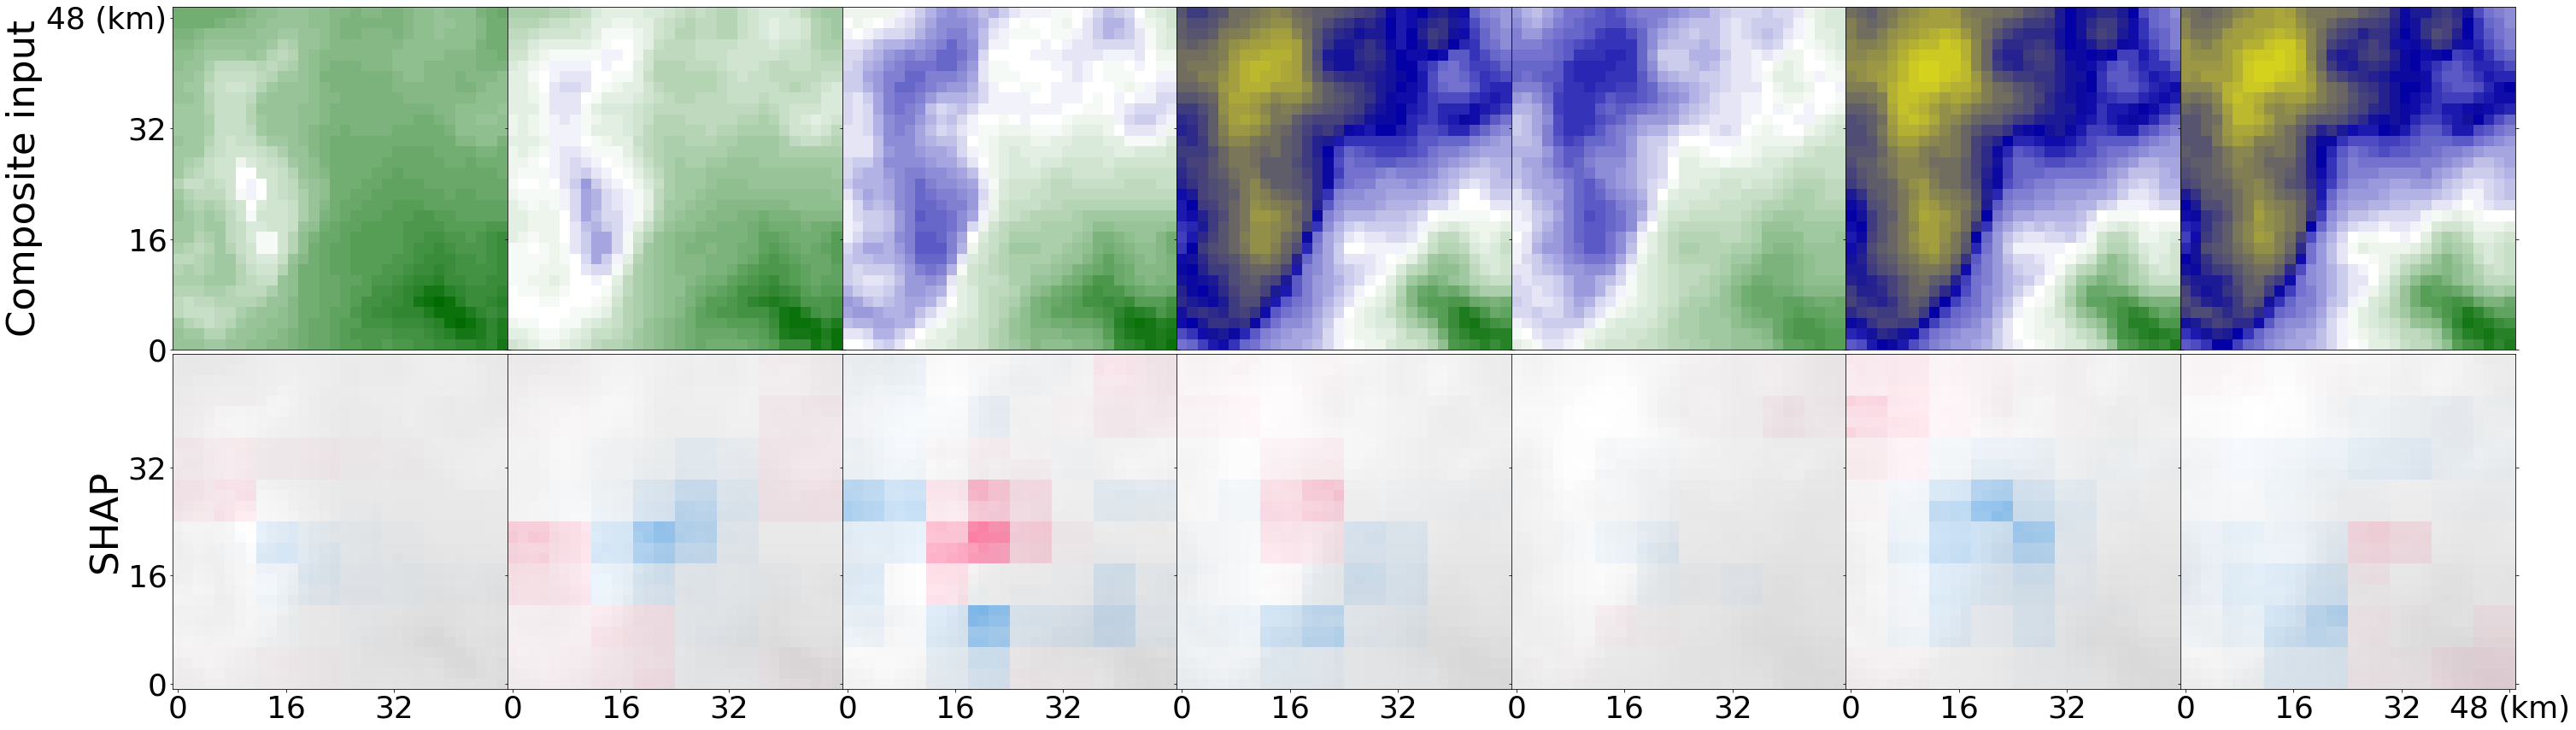

In [212]:
import copy
test=scio.loadmat('miss_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(test['shap_values']) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(test['pmm_best_hits_matrix_denorm'],shap_values_pmm)#[:,:,:,0]

-0.46967438655442095
0.0043
(32, 32, 7)
pass


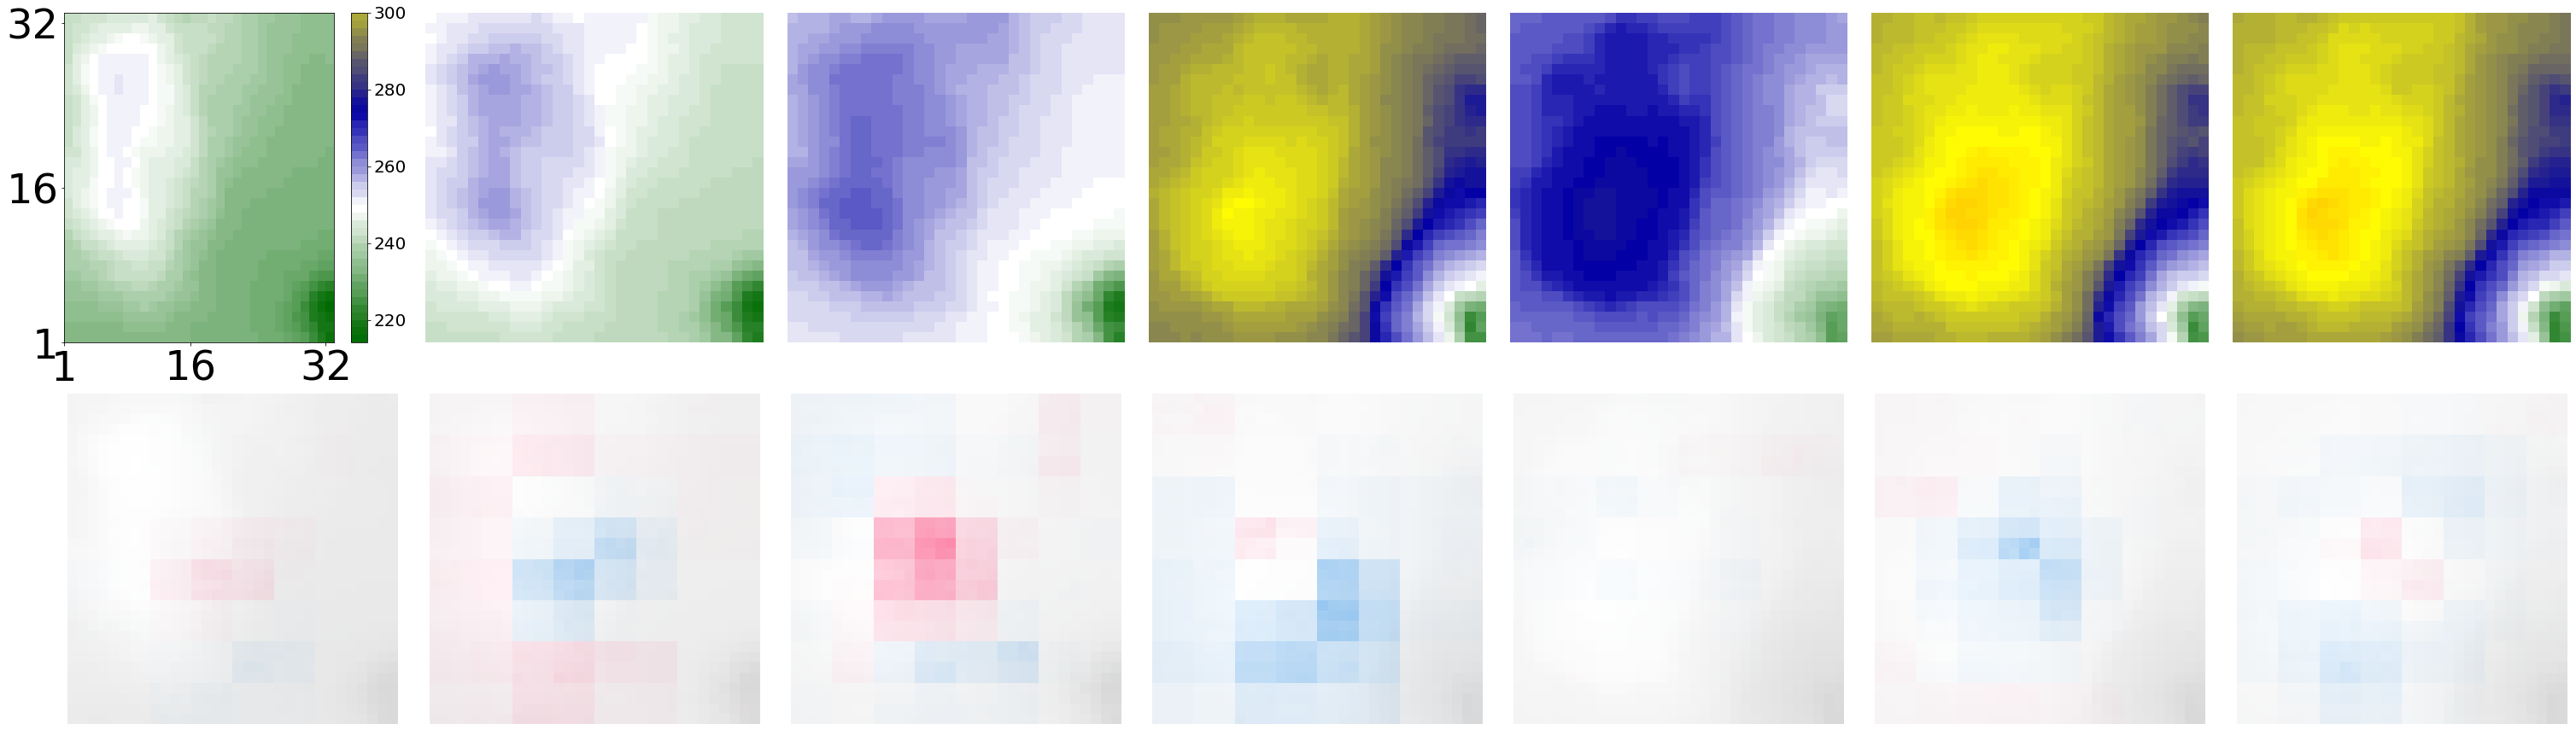

In [74]:
import copy
test=scio.loadmat('correct_null_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(test['shap_values']) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(test['pmm_best_hits_matrix_denorm'],shap_values_pmm)#[:,:,:,0]

0.4722490720208059
0.0043
(32, 32, 7)
pass


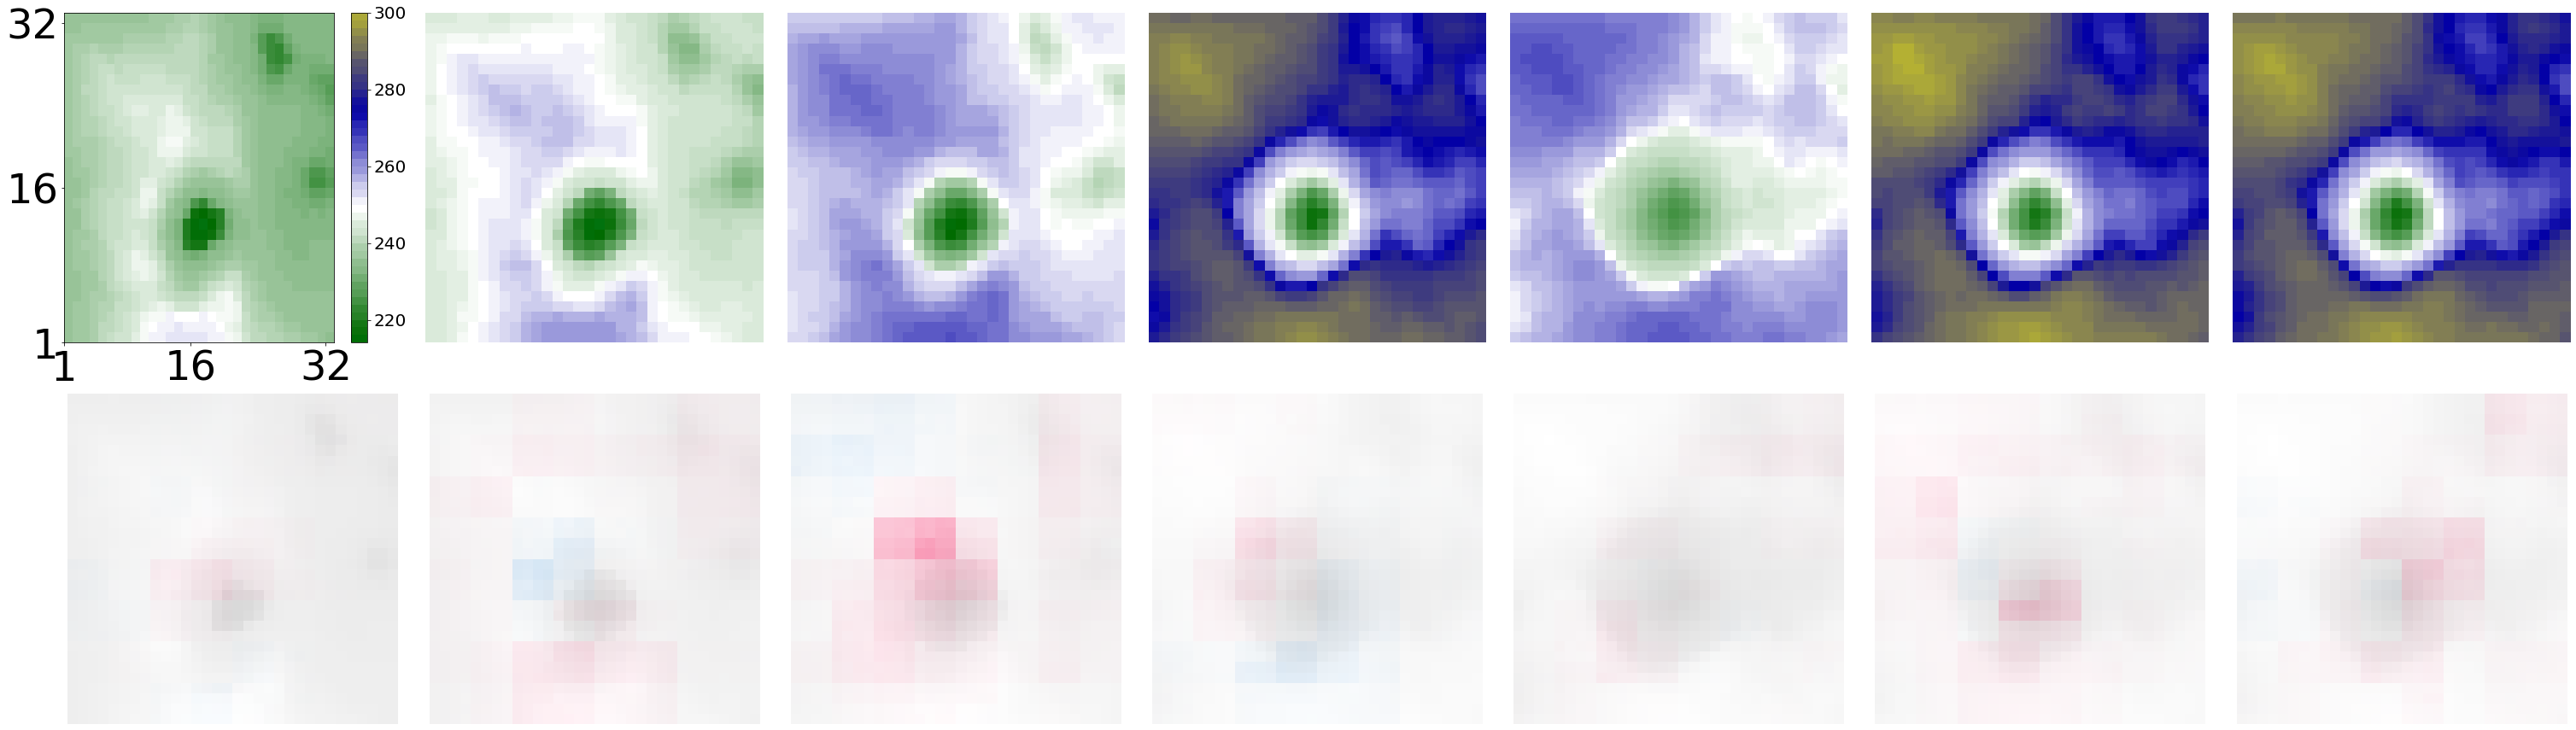

In [73]:
import copy
test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(test['shap_values']) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(test['pmm_best_hits_matrix_denorm'],shap_values_pmm)#[:,:,:,0]

0.4430007035830026
0.0043
(32, 32, 7)
pass


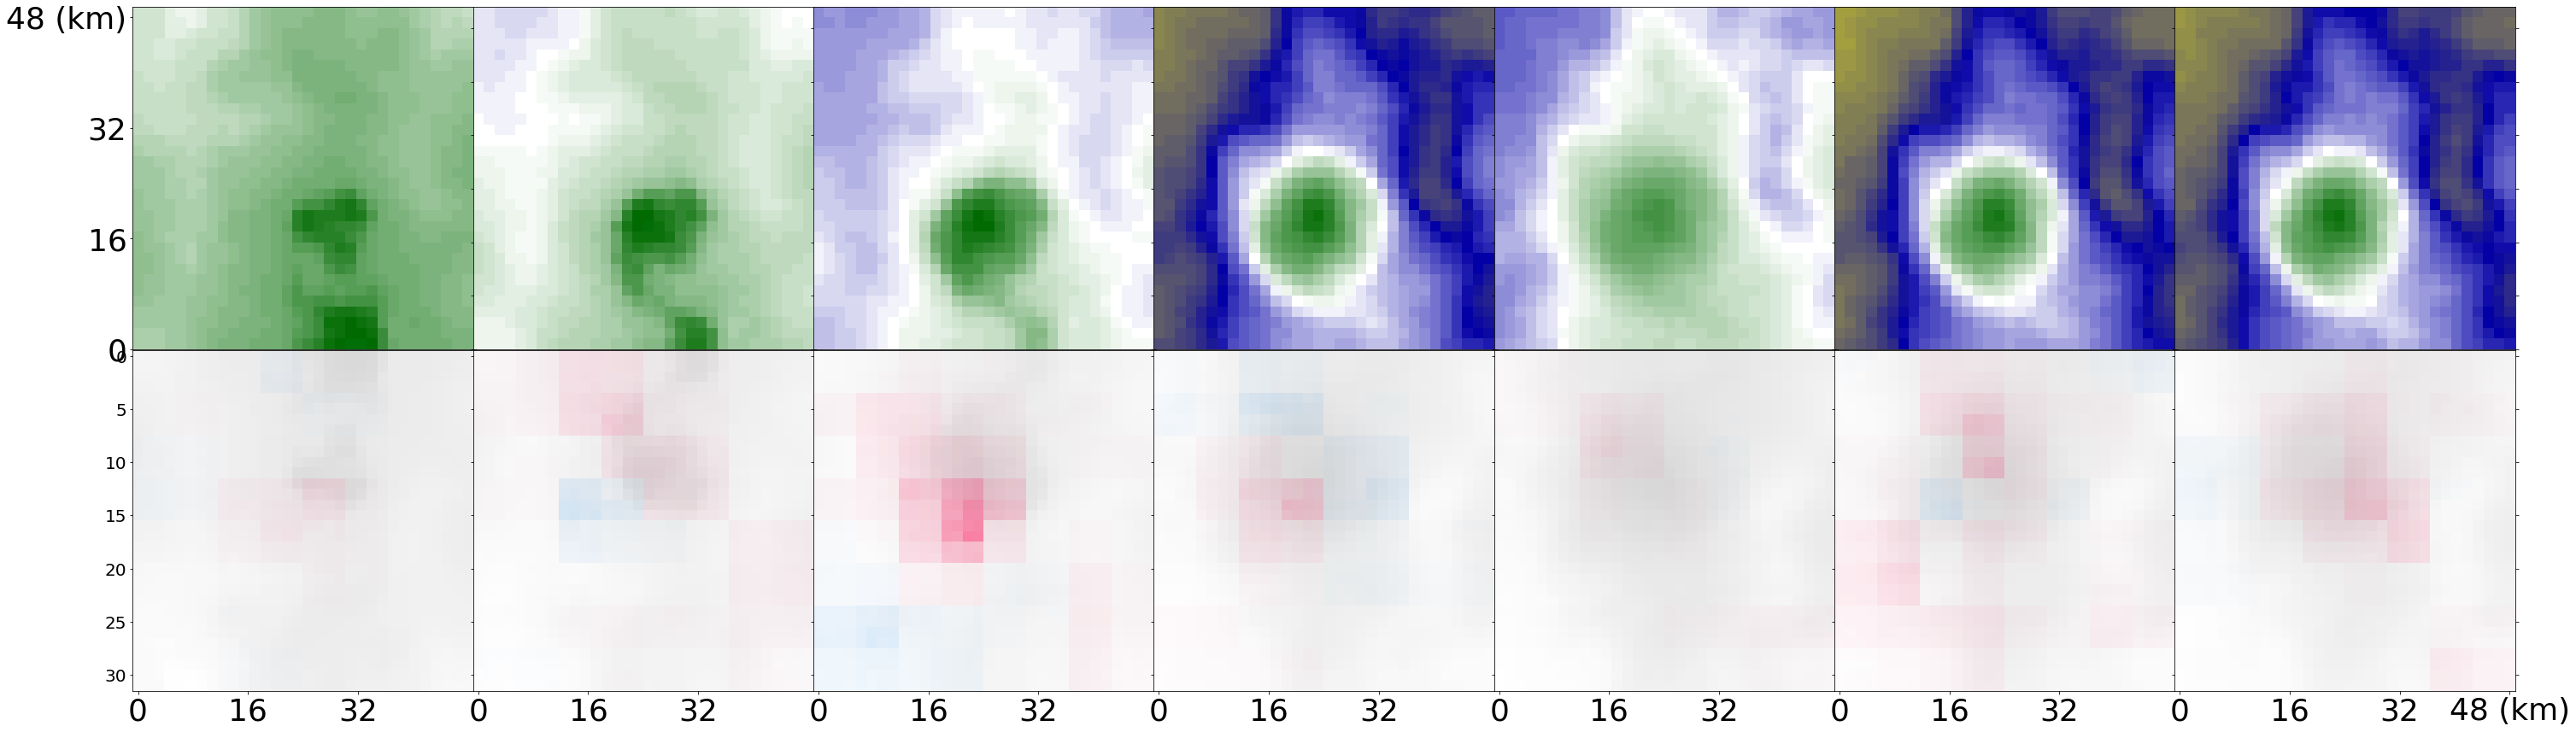

In [95]:
import copy
test=scio.loadmat('false_alarm_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(test['shap_values']) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(test['pmm_best_hits_matrix_denorm'],shap_values_pmm)#[:,:,:,0]

In [14]:
reversed_test = test_scaler.reverse_transform(test_data_mat['test_data_scaled'][test_lead10_all_indices['best_correct_null_indices']][0])
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(reversed_test)



In [15]:
print(np.max(reversed_test,axis=(0,1,2)))
print(np.min(reversed_test,axis=(0,1,2)))
print(np.max(pmm_best_hits_matrix_denorm, axis=(0,1)))
print(np.min(pmm_best_hits_matrix_denorm, axis=(0,1)))

[252.75006 261.7861  268.2141  314.8287  279.07855 320.55817 320.3431 ]
[206.13875 206.59549 206.28543 208.20505 220.70558 209.9041  209.16365]
[251.50119019 259.86309814 265.68518066 310.96658325 276.76971436
 317.56936646 317.05236816]
[216.71517944 217.84753418 219.07865906 222.86608887 227.24555969
 223.91619873 222.1081543 ]


In [61]:
print(np.max(reversed_test,axis=(0,1,2)))
print(np.min(reversed_test,axis=(0,1,2)))
print(np.max(pmm_best_hits_matrix_denorm, axis=(0,1)))
print(np.min(pmm_best_hits_matrix_denorm, axis=(0,1)))

[253.43127 262.37216 268.13852 300.1169  271.03384 305.63492 304.32397]
[205.9384  205.18854 205.43443 205.40228 220.60521 206.64072 206.20439]
[252.16882324 259.93319702 266.18563843 296.23162842 267.07467651
 300.34896851 298.61550903]
[214.01863098 214.29008484 215.0030365  217.00506592 225.21942139
 218.32225037 217.24702454]


In [56]:
transformed_test = np.squeeze(test_scaler.reverse_transform(np.expand_dims(test['pmm_best_hits_matrix_denorm'], axis=0)))
print(np.max(transformed_test, axis=(0,1)))
print(np.min(transformed_test, axis=(0,1)))

[252.16882418 259.93319724 266.18563794 296.23163003 267.07467703
 300.34896905 298.61551029]
[214.01863099 214.29008562 215.00303748 217.00506522 225.2194217
 218.32225056 217.24702521]


In [60]:
import matplotlib
from metpy.plots import colortables
# load
import pickle
with open('scaler_lead_time/'+str(lead_time)+'min/std_scaler.bin', 'rb') as f:
    test_scaler = pickle.load(f)
    
def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]
  print(np.shape(pmm_matrix_denorm))
  print(np.shape(input_times_grad_matrix))
        
  #plot_storm_xai(pmm_matzzrix_denorm, input_times_grad_matrix)
  return input_times_grad_matrix

def plot_storm_xai(values, deviation, shap_values, deviation_2, shap_values_2):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )
  row = 5
  column = 7
  fig, ax = plt.subplots(row, column, figsize=(42, 33))#30)#56, 18)

  # reverse transform from -1~1 to original values
  values = np.squeeze(test_scaler.reverse_transform(np.expand_dims(values, axis=0)))
  values = copy.deepcopy(values)
  values = np.squeeze(values)
  shap_values = copy.deepcopy(shap_values)
  shap_values = np.squeeze(shap_values)
    
  deviation = np.squeeze(deviation)
  deviation_2 = np.squeeze(deviation_2)
  print(np.min(deviation))
  print(np.max(deviation))
  print(np.min(deviation_2))
  print(np.max(deviation_2))
  #shap_values_2 = shap_values
  
  shap_values_2 = copy.deepcopy(shap_values_2)
  shap_values_2 = np.squeeze(shap_values_2)
    
  abs_vals = np.abs(shap_values.sum(-1))
  max_val = 0.0043#np.nanpercentile(abs_vals, 99.9)#0.0043#np.nanpercentile(abs_vals, 99.9)
  print(max_val)

  #input_times_grad_matrix = copy.deepcopy(input_times_grad_matrix)
  #input_times_grad_matrix = np.squeeze(input_times_grad_matrix)
  #abs_vals_gi = np.abs(input_times_grad_matrix.sum(-1))
  #max_val_gi = np.nanpercentile(abs_vals_gi, 99.9)
  #print(max_val_gi)
  ch = [8, 9, 10, 11, 12, 13, 14]
  WV_min = [170, 170, 170, 170, 170, 170, 170]#[210-10, 220-10, 225-15, 220-5, 228-10, 220-5, 220-5]
  WV_max = [350, 350, 350, 350, 350, 350, 350]#[290+10, 300+10, 305+15, 335+5, 308+10, 335+5, 335+5]
  wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[0],WV_max[0])
  max_all = 242
  min_all = -189
  wv_norm_dev, wv_cmap_dev = colortables.get_with_range('WVCIMSS_r',min_all,max_all)
  # Reflectivity
  #ax[0][0].set_title("CH8 BT")
  # add subfigure per subplot
  print(np.shape(values))
  for i in range(row):
        for j in range(column):
            if i == 0: # composite input
                im = ax[i][j].pcolormesh(values[:,:,j], 
                                  cmap=wv_cmap,#'viridis_r',#wv_cmap,#'seismic',
                                  #norm=wv_norm,#None,
                                  vmin=WV_min[0],#210,
                                  vmax=WV_max[0],#250,
                                  shading="flat", edgecolors='None')
            elif i == 1: # deviation from 0.5-probability samples
                im = ax[i][j].pcolormesh(deviation[:,:,j], 
                                  cmap=wv_cmap_dev,#'viridis_r',#wv_cmap,#'seismic',
                                  #norm=wv_norm,#None,
                                  vmin=min_all,#210,
                                  vmax=max_all,#250,
                                  shading="flat", edgecolors='None')
            elif i == 2: # SHAP
                ax[i][j].imshow(values[:,:,j], cmap="gray", alpha=0.15)
                ax[i][j].imshow(shap_values[:,:,j], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
                ax[i][j].invert_yaxis()
            elif i == 3: # deviation from warm bg
                im = ax[i][j].pcolormesh(deviation_2[:,:,j], 
                                  cmap=wv_cmap_dev,#'viridis_r',#wv_cmap,#'seismic',
                                  #norm=wv_norm,#None,
                                  vmin=min_all,#210,
                                  vmax=max_all,#250,
                                  shading="flat", edgecolors='None')
            elif i == 4: # SHAP
                ax[i][j].imshow(values[:,:,j], cmap="gray", alpha=0.15)
                ax[i][j].imshow(shap_values_2[:,:,j], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
                ax[i][j].invert_yaxis()
  for i in range(5):
    for j in range(7):
        #if i == 0:
        #ax[i][j].set_title('CH'+str(ch[j]),fontsize=45)
        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        if j == 0:
            if i == 0:
                ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                ax[i][j].set_xticks((0, 10.33, 20.66))
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
                ax[i][j].set_ylabel('Composite input',fontsize=45)
            else:
                if i == 1 or i == 3:
                    ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                    ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_yticks((0, 10.33, 20.66))
                    ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].set_xticks((0, 10.33, 20.66))
                if i == 4:
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                    ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                    labelbottom = True, bottom = True)
                else: 
                    ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                    labelbottom = False, bottom = False)
                if i == 2 or i== 4:
                    ax[i][j].set_ylabel('SHAP',fontsize=45)
                else:
                    ax[i][j].set_ylabel('Deviation',fontsize=45)
        elif i==4:
                if j == 6:
                    ax[i][j].set_yticks((0, 10.33, 20.66))
                    ax[i][j].set_xticks((0, 10.33, 20.66, 31))
                    ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_yticks((0, 10.33, 20.66))
                    ax[i][j].set_xticks((0, 10.33, 20.66))
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
        else: 
            ax[i][j].set_yticks((0, 10.33, 20.66))
            ax[i][j].tick_params(left = True, right = True , labelleft = False ,
            labelbottom = False, bottom = False)
  ax[1][3].set_title("Baseline: 0.5-probability samples",fontsize=48,y=1.03)
  ax[3][3].set_title("Baseline: Image-max background",fontsize=48,y=1.03)
  #plt.suptitle("Baseline: 0.5-probability samples",y=0.8, fontsize=36)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0, hspace=0.2)
  fig.savefig('SHAP_back.png', dpi=600, format="png")

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)

In [63]:
import matplotlib
from metpy.plots import colortables
# load
import pickle
with open('scaler_lead_time/'+str(lead_time)+'min/std_scaler.bin', 'rb') as f:
    test_scaler = pickle.load(f)
    
def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]
  print(np.shape(pmm_matrix_denorm))
  print(np.shape(input_times_grad_matrix))
        
  #plot_storm_xai(pmm_matzzrix_denorm, input_times_grad_matrix)
  return input_times_grad_matrix

def plot_storm_xai_bg(values, values_2):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )
  row = 2
  column = 7
  fig, ax = plt.subplots(row, column, figsize=(42, 2*6+1.5))#30)#56, 18)

  # reverse transform from -1~1 to original values
  values = np.squeeze(test_scaler.reverse_transform(np.expand_dims(values, axis=0)))
  values = copy.deepcopy(values)
  values = np.squeeze(values)

  values_2 = np.squeeze(test_scaler.reverse_transform(np.expand_dims(values_2, axis=0)))
  values_2 = copy.deepcopy(values_2)
  values_2 = np.squeeze(values_2)


  #input_times_grad_matrix = copy.deepcopy(input_times_grad_matrix)
  #input_times_grad_matrix = np.squeeze(input_times_grad_matrix)
  #abs_vals_gi = np.abs(input_times_grad_matrix.sum(-1))
  #max_val_gi = np.nanpercentile(abs_vals_gi, 99.9)
  #print(max_val_gi)
  ch = [8, 9, 10, 11, 12, 13, 14]
  WV_min = [170, 170, 170, 170, 170, 170, 170]#[210-10, 220-10, 225-15, 220-5, 228-10, 220-5, 220-5]
  WV_max = [350, 350, 350, 350, 350, 350, 350]#[290+10, 300+10, 305+15, 335+5, 308+10, 335+5, 335+5]
  wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[0],WV_max[0])
  max_all = 242
  min_all = -189
  wv_norm_dev, wv_cmap_dev = colortables.get_with_range('WVCIMSS_r',min_all,max_all)
  # Reflectivity
  #ax[0][0].set_title("CH8 BT")
  # add subfigure per subplot
  print(np.shape(values))
  for i in range(row):
        for j in range(column):
            if i == 0: # 0.5-probability samples
                im = ax[i][j].pcolormesh(values[:,:,j], 
                                  cmap=wv_cmap,#'viridis_r',#wv_cmap,#'seismic',
                                  #norm=wv_norm,#None,
                                  vmin=WV_min[0],#210,
                                  vmax=WV_max[0],#250,
                                  shading="flat", edgecolors='None')
            else:
                im = ax[i][j].pcolormesh(values_2[:,:,j], 
                                  cmap=wv_cmap,#'viridis_r',#wv_cmap,#'seismic',
                                  #norm=wv_norm,#None,
                                  vmin=WV_min[0],#210,
                                  vmax=WV_max[0],#250,
                                  shading="flat", edgecolors='None')

  for i in range(2):
    for j in range(7):
        #if i == 0:
        #ax[i][j].set_title('CH'+str(ch[j]),fontsize=45)
        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        if j == 0:
            ax[i][j].set_yticks((0, 10.33, 20.66, 31))
            ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
            ax[i][j].set_xticks((0, 10.33, 20.66))
            if i ==1:
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = True, bottom = True)
            else:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
            ax[i][j].set_ylabel('Composite input',fontsize=45)
        else:
            if j==6:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_xticks((0, 10.33, 20.66, 31))
                ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
            else:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_xticks((0, 10.33, 20.66))
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
            if i == 1:
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
            else:
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = False, bottom = False)
  ax[0][3].set_title("Baseline: 0.5-probability samples",fontsize=48,y=1.03)
  ax[1][3].set_title("Baseline: Image-max background(PMM)",fontsize=48,y=1.03)
  #plt.suptitle("Baseline: 0.5-probability samples",y=0.8, fontsize=36)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0, hspace=0.2)
  fig.savefig('baseline_input.png', dpi=600, format="png")

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)

In [55]:
import matplotlib
from metpy.plots import colortables
# load
import pickle
with open('scaler_lead_time/'+str(lead_time)+'min/std_scaler.bin', 'rb') as f:
    test_scaler = pickle.load(f)
    
def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]
  print(np.shape(pmm_matrix_denorm))
  print(np.shape(input_times_grad_matrix))
        
  #plot_storm_xai(pmm_matzzrix_denorm, input_times_grad_matrix)
  return input_times_grad_matrix

def plot_storm_xai(values, shap_values):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(2, 7, figsize=(42, 12))#56, 18)

  # reverse transform from -1~1 to original values
  mean_bg = np.zeros_like(X[0])
  for j in range(np.shape(mean_bg)[-1]):
      mean_bg[:,:,j]=test_scaler.scale_values["mean"][j]
  values = np.squeeze(test_scaler.reverse_transform(np.expand_dims(values, axis=0))-mean_bg)
  values = copy.deepcopy(values)
  values = np.squeeze(values)
  print(np.max(values,axis=(0,1)))
  shap_values = copy.deepcopy(shap_values)
  # shap_values = np.abs(shap_values)
  shap_values = np.squeeze(shap_values)

  abs_vals = np.abs(shap_values.sum(-1))
  max_val = 0.0043#0.0005#0.0043#np.nanpercentile(abs_vals, 99.9)#0.0043#np.nanpercentile(abs_vals, 99.9)#0.0043#np.nanpercentile(abs_vals, 99.9)
  print(max_val)
  #input_times_grad_matrix = copy.deepcopy(input_times_grad_matrix)
  #input_times_grad_matrix = np.squeeze(input_times_grad_matrix)
  #abs_vals_gi = np.abs(input_times_grad_matrix.sum(-1))
  #max_val_gi = np.nanpercentile(abs_vals_gi, 99.9)
  #print(max_val_gi)
  ch = [8, 9, 10, 11, 12, 13, 14]
  max_all = 80
  WV_min = [-max_all,-max_all,-max_all,-max_all,-max_all,-max_all,-max_all]#[170, 170, 170, 170, 170, 170, 170]#[210-10, 220-10, 225-15, 220-5, 228-10, 220-5, 220-5]
  WV_max = [max_all,max_all,max_all,max_all,max_all,max_all,max_all]#[350, 350, 350, 350, 350, 350, 350]#[290+10, 300+10, 305+15, 335+5, 308+10, 335+5, 335+5]
  wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[0],WV_max[0])
  # Reflectivity
  #ax[0][0].set_title("CH8 BT")
  print(np.shape(values))
  im = ax[0][0].pcolormesh(values[:,:,0], 
                      cmap=wv_cmap,#'viridis_r',#wv_cmap,#'seismic',
                      #norm=wv_norm,#None,
                      vmin=WV_min[0],#210,
                      vmax=WV_max[0],#250,
                      shading="flat", edgecolors='None')
  #cax = divider.append_axes('right', size='5%', pad=0.05)
  #im = ax.imshow(data, cmap='bone')
  #fig.colorbar(im, ax=ax[0][0])
  #ax[0][0].axis('off')
  print("pass")
    
  '''
  cbar = fig.colorbar(im, ax=ax[0][0], boundaries=np.arange(214,301,2))#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
  tick_font_size = 20
  cbar.ax.tick_params(labelsize=tick_font_size)
  cbar.set_ticks(np.arange(220,301,20))
  cbar.set_ticklabels( ('220','240', '260', '280','300')) 
  '''
#  ax[0][0].set_xticks([0,16,31])
  ax[1][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[1][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][0].invert_yaxis()
  #ax[1][0].axis('off')
  #ax[2][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  #ax[2][0].imshow(input_times_grad_matrix[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)  
  #ax[2][0].invert_yaxis()
  #ax[2][0].axis('off')

  # Temperature
  #ax[0][1].set_title("CH9 BT")
  wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[1],WV_max[1])
  im = ax[0][1].pcolormesh((values[:,:,1]), 
                      cmap=wv_cmap,#'seismic',
                      #norm=wv_norm,#None,
                      vmin=WV_min[1],
                      vmax=WV_max[1],
                      shading="flat", edgecolors='None') 
  #ax[0][1].axis('off')
  ax[1][1].imshow(values[:,:,1], cmap="gray", alpha=0.15)
  ax[1][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][1].invert_yaxis()
  #ax[1][1].axis('off')
  #ax[2][1].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  #ax[2][1].imshow(input_times_grad_matrix[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  #ax[2][1].invert_yaxis()
  #ax[2][1].axis('off')

  # Wind barbs
  #image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  #ax[0][2].set_title("CH10 BT")
  wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[2],WV_max[2])
  im = ax[0][2].pcolormesh((values[:,:,2]), 
                      cmap=wv_cmap,#'seismic',
                      #norm=wv_norm,#None,
                      vmin=WV_min[2],
                      vmax=WV_max[2],
                      shading="flat", edgecolors='None')  
  #ax[0][2].axis('off')
  ax[1][2].imshow(values[:,:,2], cmap="gray", alpha=0.15)
  ax[1][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][2].invert_yaxis()
  #ax[1][2].axis('off')
  '''
  ax[2][2].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][2].imshow(input_times_grad_matrix[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][2].invert_yaxis()
  ax[2][2].axis('off')
  '''

  # Wind - v
  #ax[0][3].set_title("CH11 BT")
  wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[3],WV_max[3])
  im = ax[0][3].pcolormesh((values[:,:,3]), 
                      cmap=wv_cmap,#'seismic',
                      #norm=wv_norm,#None,
                      vmin=WV_min[3],
                      vmax=WV_max[3],
                      shading="flat", edgecolors='None')  
  #ax[0][3].axis('off')
  ax[1][3].imshow(values[:,:,3], cmap="gray", alpha=0.15)
  ax[1][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][3].invert_yaxis()
  #ax[1][3].axis('off')
  '''
  ax[2][3].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][3].imshow(input_times_grad_matrix[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][3].invert_yaxis()
  ax[2][3].axis('off')
  '''

  #ax[0][4].set_title("CH12 BT")
  wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[4],WV_max[4])
  im = ax[0][4].pcolormesh((values[:,:,4]),
                      cmap=wv_cmap,#'seismic',
                      #norm=wv_norm,#None,
                      vmin=WV_min[4],
                      vmax=WV_max[4],
                      shading="flat", edgecolors='None')  
  #ax[0][4].axis('off')
  ax[1][4].imshow(values[:,:,4], cmap="gray", alpha=0.15)
  ax[1][4].imshow(shap_values[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][4].invert_yaxis()
  #ax[1][4].axis('off')
  '''
  ax[2][4].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][4].imshow(input_times_grad_matrix[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][4].invert_yaxis()
  ax[2][4].axis('off')
  '''

  #ax[0][5].set_title("CH13 BT")
  wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[5],WV_max[5])
  im = ax[0][5].pcolormesh((values[:,:,5]), 
                      cmap=wv_cmap,#'seismic',
                      #norm=wv_norm,#None,
                      vmin=WV_min[5],
                      vmax=WV_max[5],
                      shading="flat", edgecolors='None')  
  #ax[0][5].axis('off')
  ax[1][5].imshow(values[:,:,5], cmap="gray", alpha=0.15)
  ax[1][5].imshow(shap_values[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][5].invert_yaxis()
  #ax[1][5].axis('off')
  '''
  ax[2][5].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][5].imshow(input_times_grad_matrix[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][5].invert_yaxis()
  ax[2][5].axis('off')
  '''

  #ax[0][6].set_title("CH14 BT")
  wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[6],WV_max[6])
  im = ax[0][6].pcolormesh((values[:,:,6]),
                      cmap=wv_cmap,#'seismic',
                      #norm=wv_norm,#None,
                      vmin=WV_min[6],
                      vmax=WV_max[6],
                      shading="flat", edgecolors='None')  
#  cbar = fig.colorbar(im, ax=ax[0][6])
  #cbar.ax.tick_params(labelsize=36)
  #ax[0][6].set_xticks((0, 15, 31))
  #ax[0][6].set_xticklabels(('1', '16', '32'), fontsize=48)
  #ax[0][6].set_yticks((0, 15, 31))
  #ax[0][6].set_yticklabels(('1', '16', '32'), fontsize=48)
  #ax[0][6].axis('off')
  ax[1][6].imshow(values[:,:,6], cmap="gray", alpha=0.15)
  print(np.max(values[:,:,6]))
  im = ax[1][6].imshow(values[:,:,6], cmap=colors.red_transparent_blue, vmin=-np.max(values[:,:,6]), vmax=np.max(values[:,:,6]))  
  #im = ax[1][6].imshow(shap_values[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][6].invert_yaxis()
  #cbar = fig.colorbar(im, ax=ax[1][6])
  #cbar.ax.tick_params(labelsize=36)
  #ax[1][6].axis('off')
  '''
  ax[2][6].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  im = ax[2][6].imshow(input_times_grad_matrix[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  #cbar = fig.colorbar(im, ax=ax[2][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[2][6].invert_yaxis()
  ax[2][6].axis('off')
  '''
  for i in range(2):
    for j in range(7):
        #if i == 0:
        #ax[i][j].set_title('CH'+str(ch[j]),fontsize=45)
        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        if j == 0:
            if i==1:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].set_xticks((0, 10.33, 20.66))
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = True, bottom = True)
                ax[i][j].set_ylabel('SHAP',fontsize=45)
            else:
                ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
                ax[i][j].set_ylabel('Composite input',fontsize=45)
        else:
            if i==1:
                if j == 6:
                    ax[i][j].set_yticks((0, 10.33, 20.66))
                    ax[i][j].set_xticks((0, 10.33, 20.66, 31))
                    ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_yticks((0, 10.33, 20.66))
                    ax[i][j].set_xticks((0, 10.33, 20.66))
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
            else: 
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = False, bottom = False)

  plt.tight_layout()
  plt.subplots_adjust(wspace=0, hspace=0)

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)

In [7]:
import copy
test=scio.loadmat('hits_shap_10min_best100@10min.mat')
print(np.shape(test['shap_values']))
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])

(100, 32, 32, 7)


0.4722490720208059
0.0043
(32, 32, 7)
pass


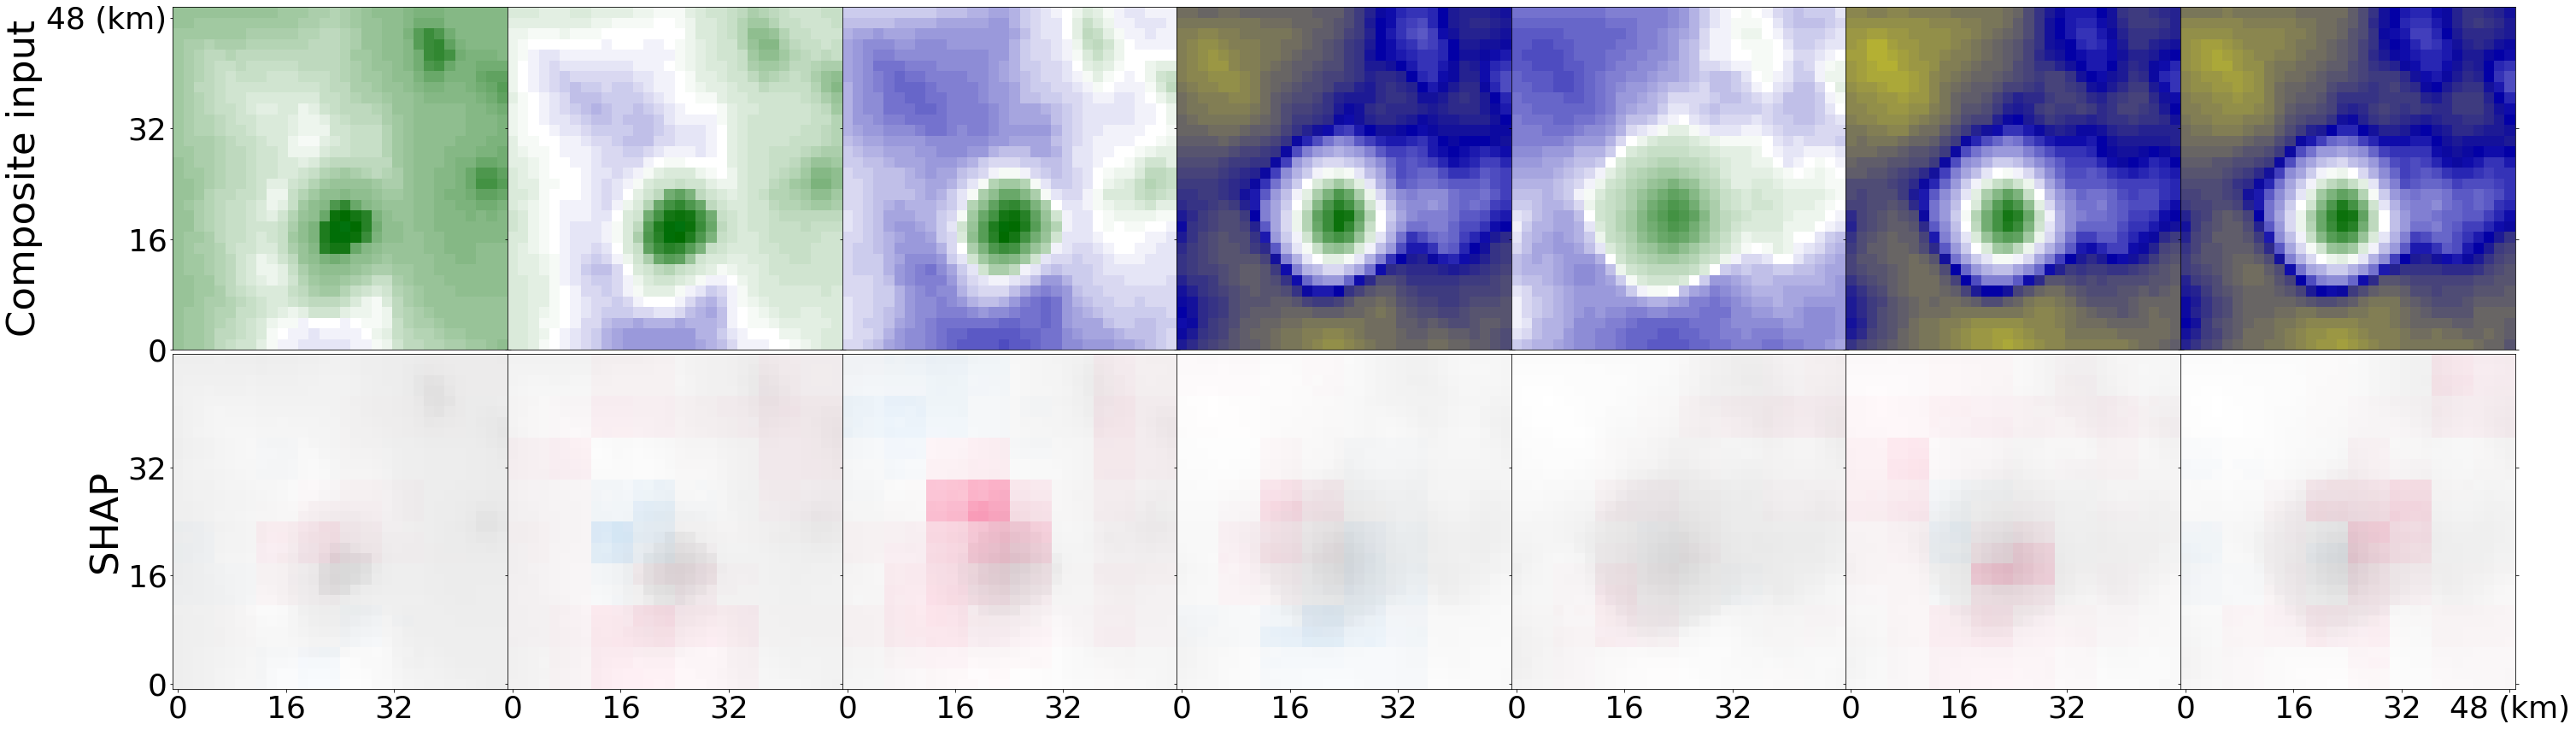

In [137]:
import copy
test=scio.loadmat('hits_shap.mat')
#shap_values_pmm = utils.run_pmm_many_variables(np.array(shap_values)[0])
shap_values_pmm = utils.run_pmm_many_variables(test['shap_values']) #.values
print(np.sum(shap_values_pmm))
#print(np.shape(shap_values_pmm))
plot_storm_xai(test['pmm_best_hits_matrix_denorm'],shap_values_pmm)
plt.savefig('plots/SHAP_hit.png')
#plt.savefig('plots/SHAP_title.png')

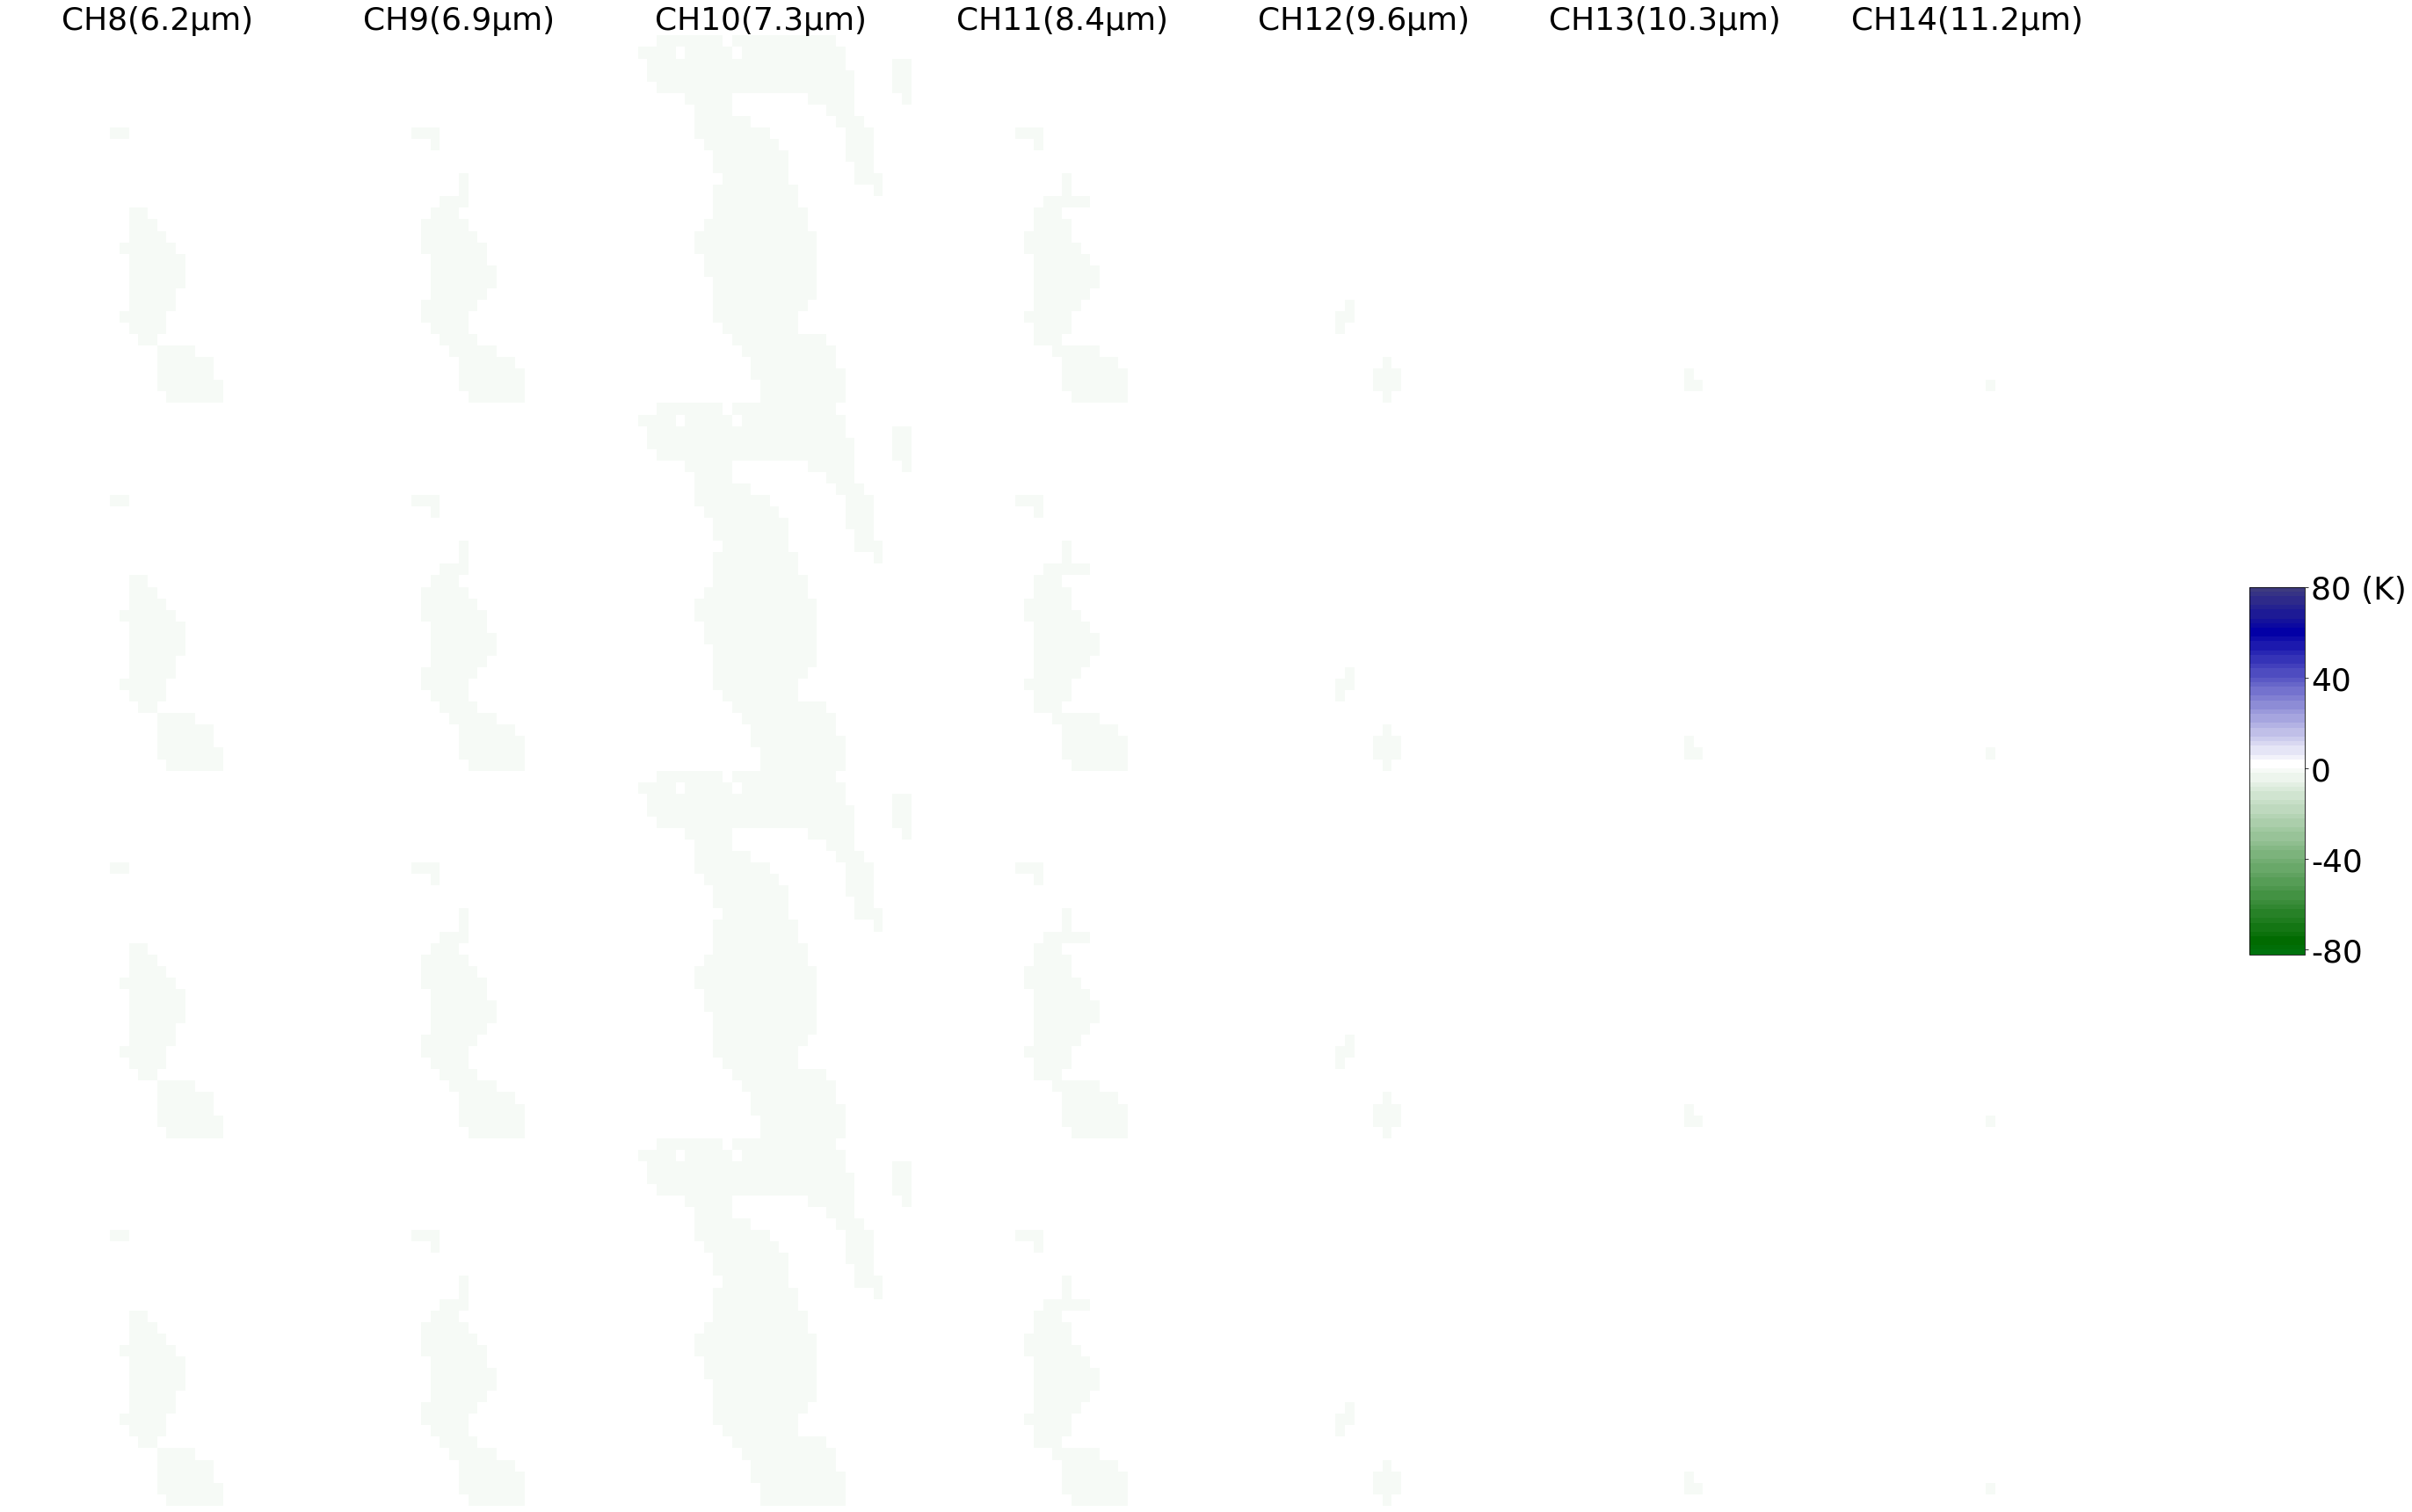

In [85]:
from metpy.plots import colortables
import matplotlib as mpl
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
vmin_all = 160
vmax_all = 410
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
WV_min = [170, 170, 170, -189, 170, 170, 170]#[210-10, 220-10, 225-15, 220-5, 228-10, 220-5, 220-5]
WV_max = [350, 350, 350, 242, 350, 350, 350]
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[3],WV_max[3])
        if i == 0 or i == 1:
            a = ax[i][6 - j].pcolormesh(np.squeeze(best_hits_matrix_norm[0][0,:,:,j]), \
                                      cmap=wv_cmap, vmin=WV_min[3], vmax=WV_max[3])#265
        #if i == 3:
        #    a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
        #                              cmap=wv_cmap, norm=wv_norm, N=500)
        #else:
        else:
            a = ax[i][6 - j].pcolormesh(np.squeeze(best_hits_matrix_norm[0][0,:,:,j]),\
                                      cmap=wv_cmap, vmin=WV_min[3], vmax=WV_max[3])
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        '''
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        '''
        ax[i][j].axis('off')
        #cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        #tick_font_size = 20
        #cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="right",cmap = wv_cmap, shrink=0.25,  boundaries=np.arange(-82,82,2), aspect=6.66)#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 36
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(-80,81,40))
cbar.set_ticklabels( ('-80', '-40','0', '40','80 (K)')) 

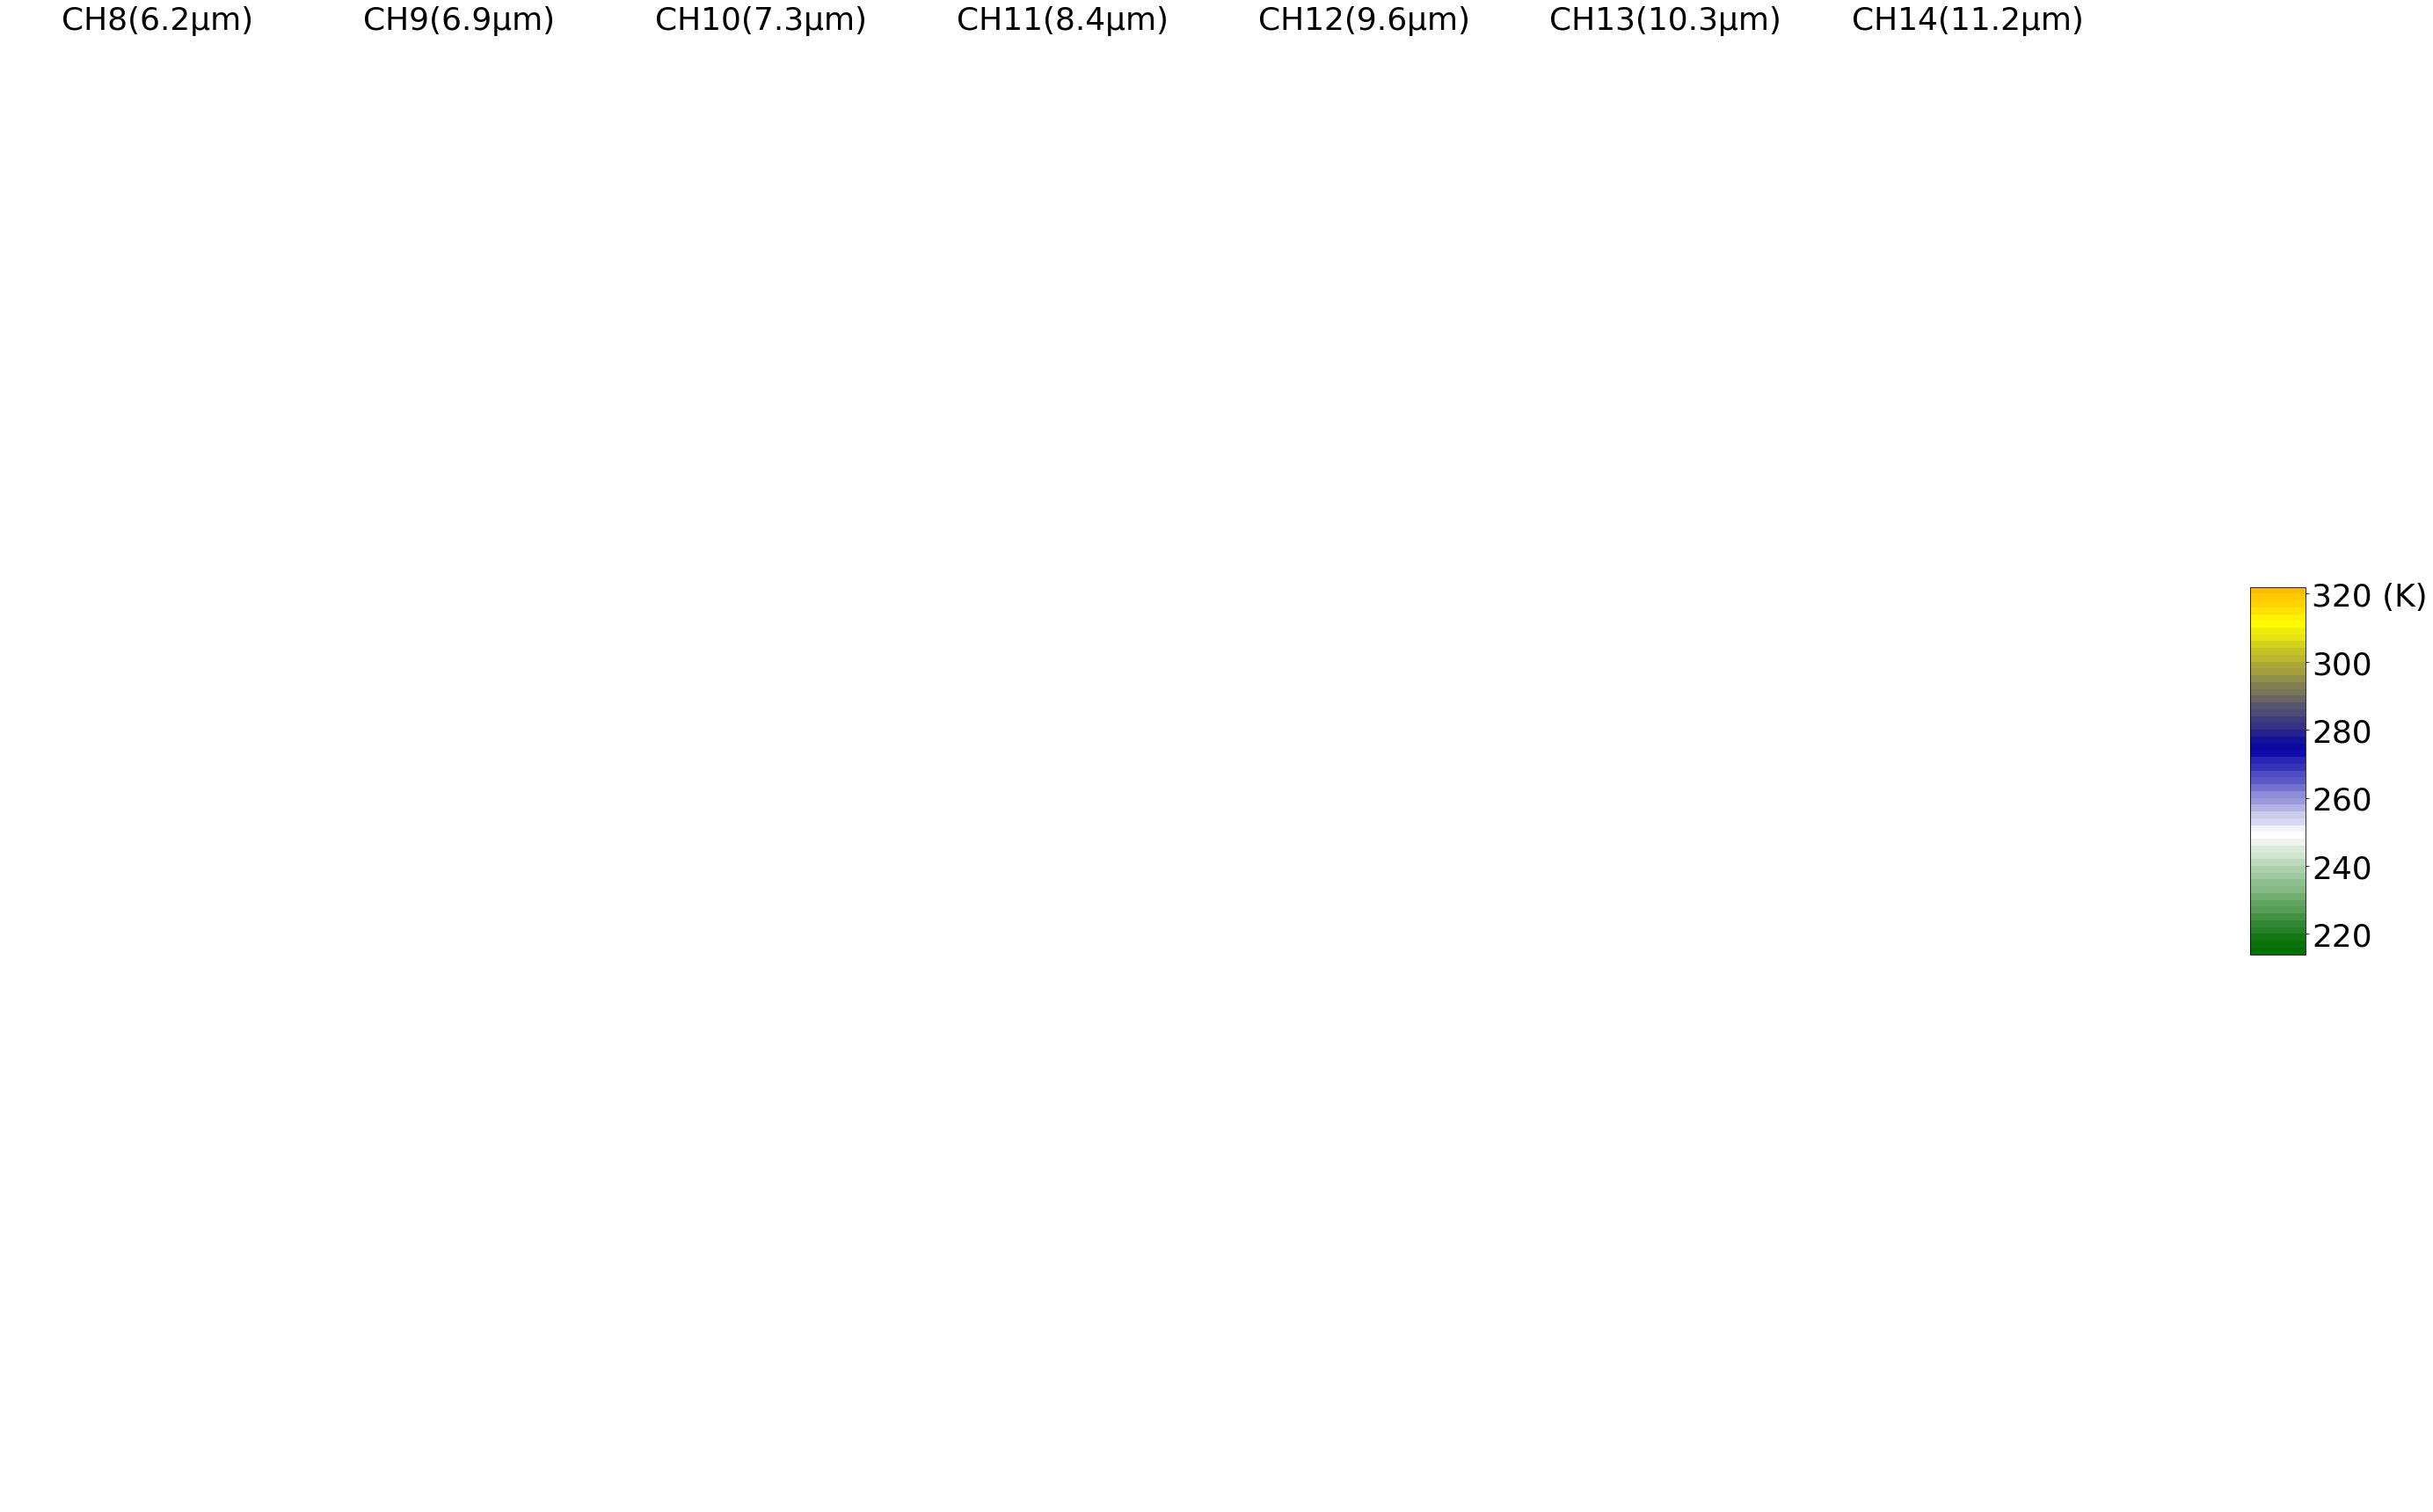

In [149]:
from metpy.plots import colortables
import matplotlib as mpl
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
vmin_all = 160
vmax_all = 410
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
WV_min = [170, 170, 170, 170, 170, 170, 170]#[210-10, 220-10, 225-15, 220-5, 228-10, 220-5, 220-5]
WV_max = [350, 350, 350, 350, 350, 350, 350]
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[3],WV_max[3])
        if i == 0 or i == 1:
            a = ax[i][6 - j].pcolormesh(np.squeeze(best_hits_matrix_norm[0][0,:,:,j]), \
                                      cmap=wv_cmap, vmin=WV_min[3], vmax=WV_max[3])#265
        #if i == 3:
        #    a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
        #                              cmap=wv_cmap, norm=wv_norm, N=500)
        #else:
        else:
            a = ax[i][6 - j].pcolormesh(np.squeeze(best_hits_matrix_norm[0][0,:,:,j]),\
                                      cmap=wv_cmap, vmin=WV_min[3], vmax=WV_max[3])
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        '''
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        '''
        ax[i][j].axis('off')
        #cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        #tick_font_size = 20
        #cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="right",cmap = wv_cmap, shrink=0.25,  boundaries=np.arange(214,323,2), aspect=6.66)#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 36
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(220,321,20))
cbar.set_ticklabels( ('220','240', '260', '280','300', '320 (K)')) 

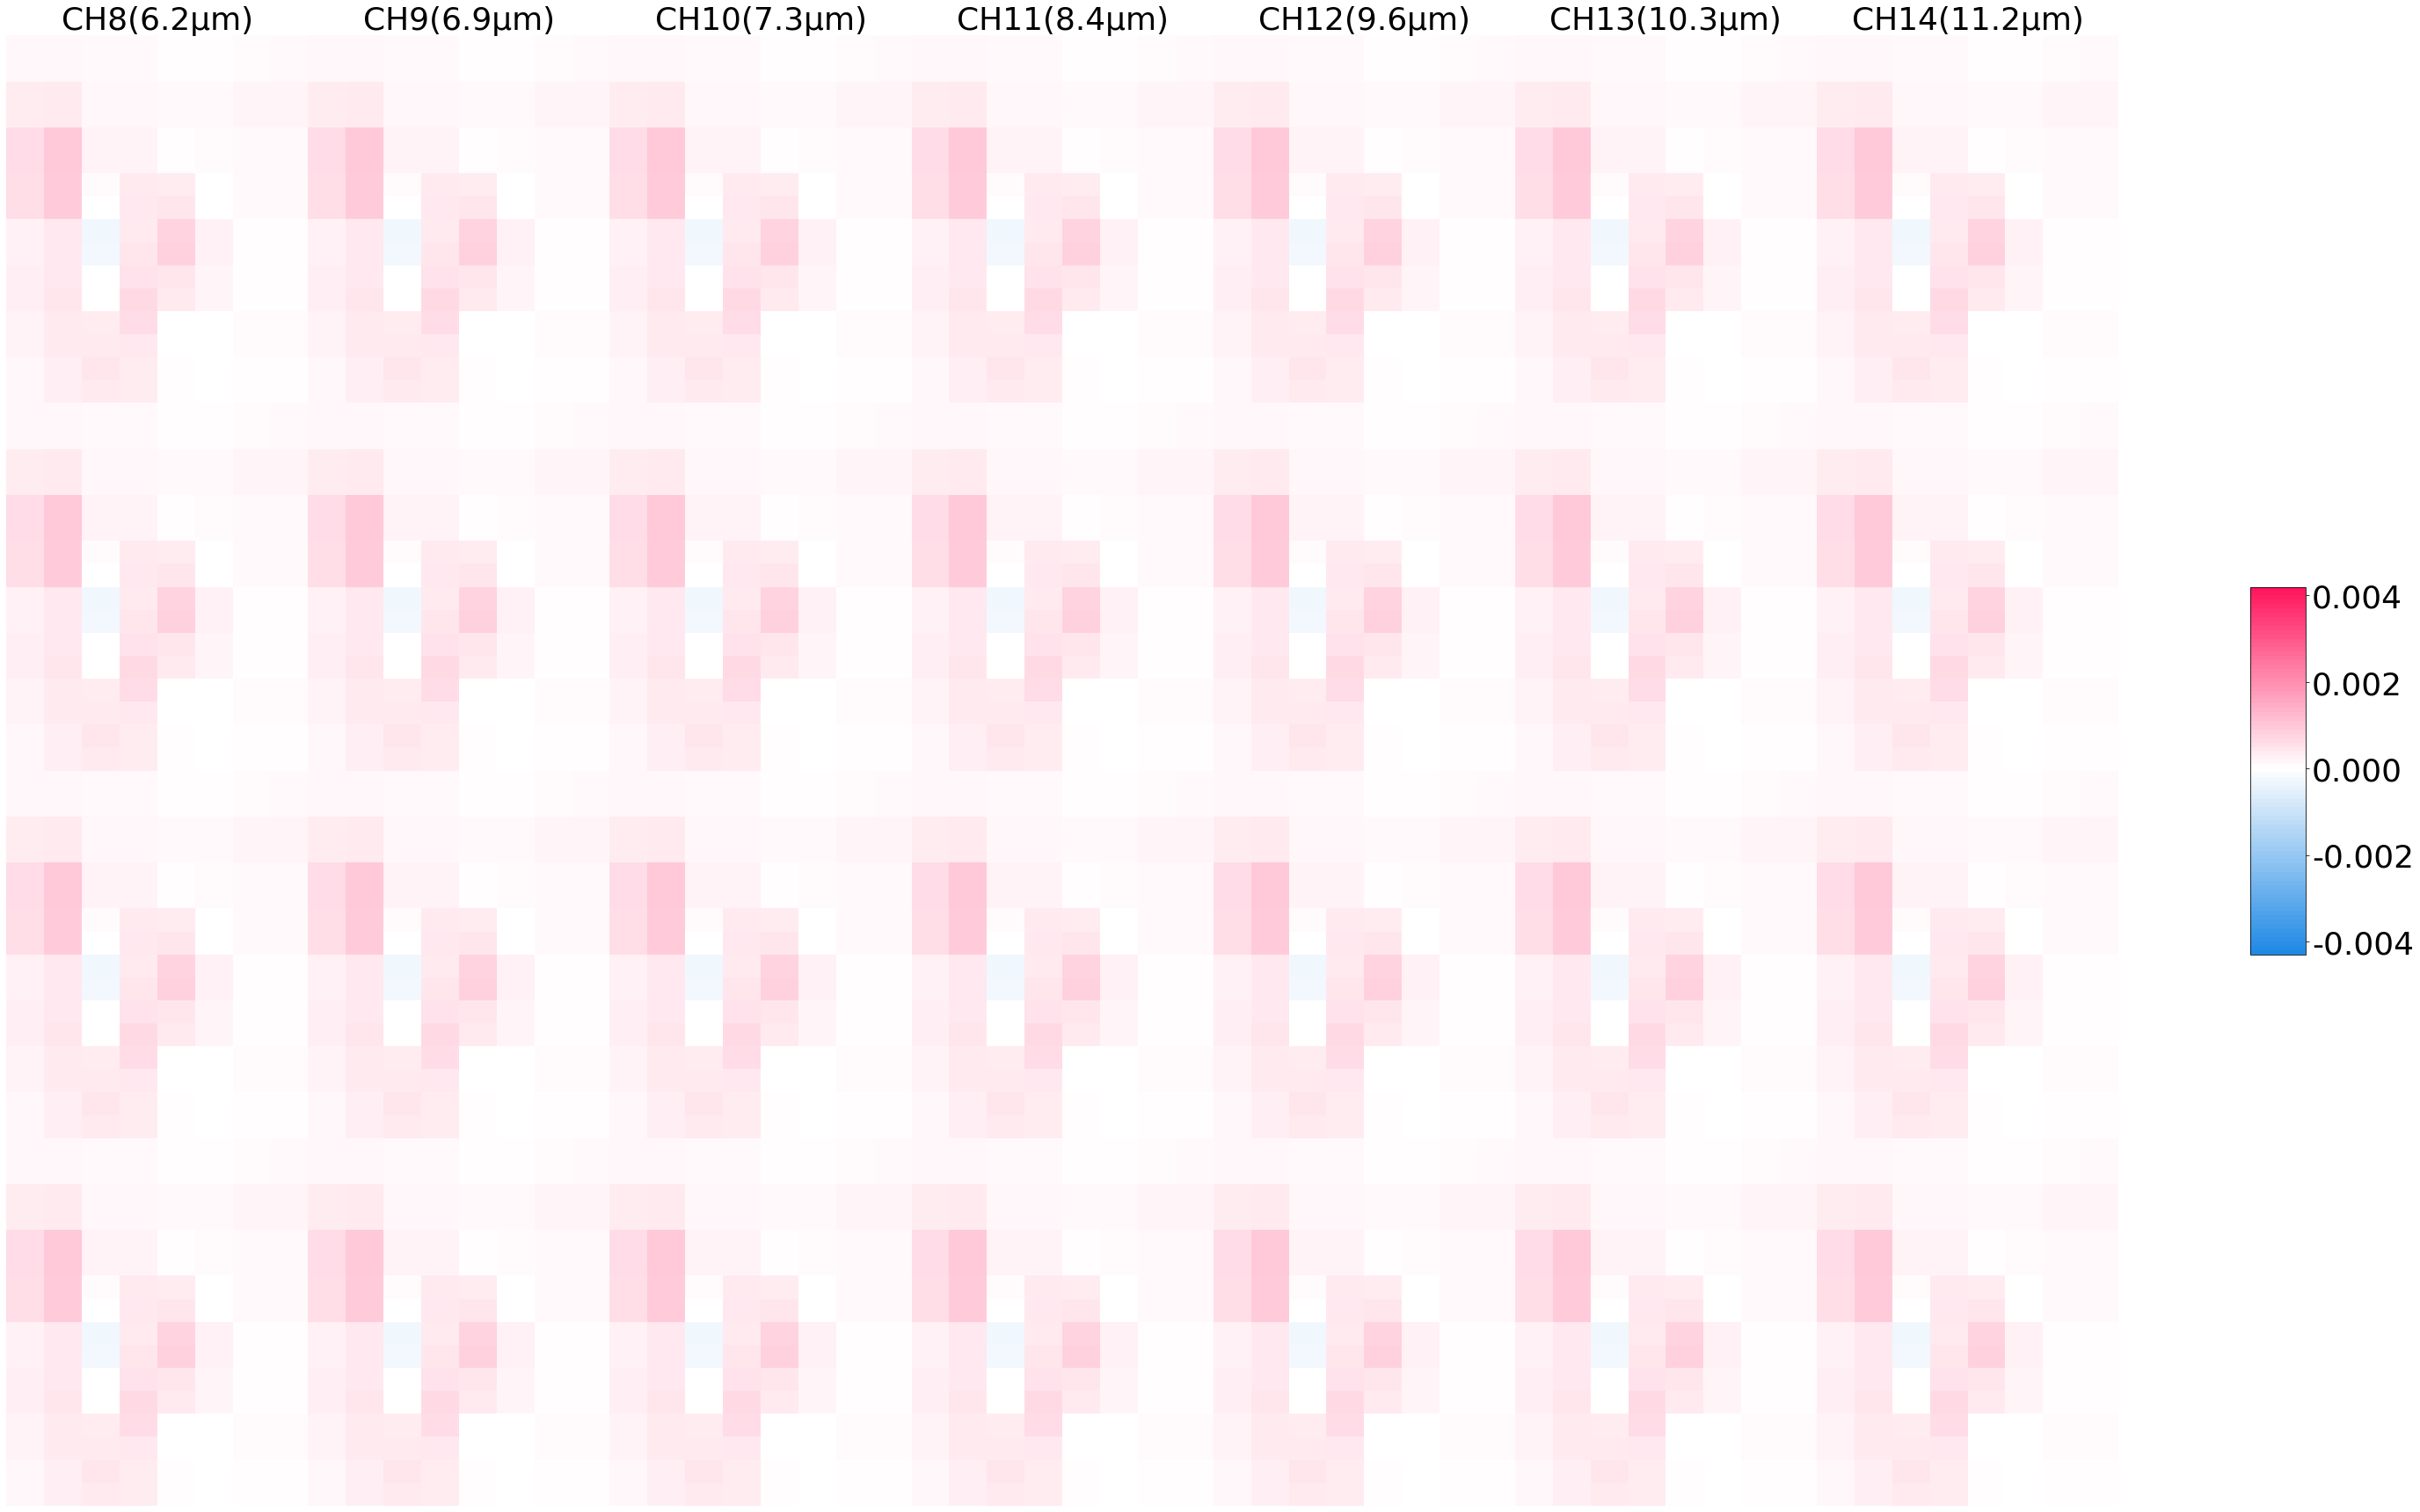

In [9]:
from metpy.plots import colortables
from shap.plots import colors
import matplotlib as mpl
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
vmin_all = 160
vmax_all = 410
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
WV_min = [170, 170, 170, 170, 170, 170, 170]#[210-10, 220-10, 225-15, 220-5, 228-10, 220-5, 220-5]
WV_max = [350, 350, 350, 350, 350, 350, 350]
max_val = 0.0043
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[3],WV_max[3])
        if i == 0 or i == 1:
            a = ax[i][6 - j].pcolormesh(test['shap_values'][0,:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)#265
        #if i == 3:
        #    a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
        #                              cmap=wv_cmap, norm=wv_norm, N=500)
        #else:
        else:
            a = ax[i][6 - j].pcolormesh(test['shap_values'][0,:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        '''
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        '''
        ax[i][j].axis('off')
        #cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        #tick_font_size = 20
        #cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="right",cmap = colors.red_transparent_blue, shrink=0.25,  boundaries=np.arange(-0.0043,0.0043,0.0001), aspect=6.66)#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 36
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(-0.004,0.0043,0.002))
cbar.set_ticklabels( ('-0.004','-0.002', '0.000', '0.002','0.004')) 

In [142]:
import matplotlib

def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  print('ok')
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]

  plot_storm_xai(pmm_matrix_denorm, input_times_grad_matrix)

def plot_storm_xai(values, shap_values, input_times_grad_matrix):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(3, 7, figsize=(42, 18))#56, 18)

  values = copy.deepcopy(values)
  values = np.squeeze(values)
  shap_values = copy.deepcopy(shap_values)
  # shap_values = np.abs(shap_values)
  shap_values = np.squeeze(shap_values)

  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)
  
  input_times_grad_matrix = copy.deepcopy(input_times_grad_matrix)
  input_times_grad_matrix = np.squeeze(input_times_grad_matrix)
  abs_vals_gi = np.abs(input_times_grad_matrix.sum(-1))
  max_val_gi = np.nanpercentile(abs_vals_gi, 99.9)

  # Reflectivity
  #ax[0][0].set_title("CH8 BT")
  im = ax[0][0].pcolormesh((1-values[:,:,0])*df.loc[0,"range"]+df.loc[0,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[0,"min"],
                      vmax=df.loc[0,"max"],
                      shading="flat", edgecolors='None')
  cbar = fig.colorbar(im, ax=ax[0][0])
  cbar.ax.tick_params(labelsize=36)
  #cax = divider.append_axes('right', size='5%', pad=0.05)
  #im = ax.imshow(data, cmap='bone')
  #fig.colorbar(im, ax=ax[0][0])
  ax[0][0].axis('off')
  ax[1][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[1][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][0].invert_yaxis()
  ax[1][0].axis('off')
  ax[2][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][0].imshow(input_times_grad_matrix[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)  
  ax[2][0].invert_yaxis()
  ax[2][0].axis('off')

  # Temperature
  #ax[0][1].set_title("CH9 BT")
  im = ax[0][1].pcolormesh((1-values[:,:,1])*df.loc[1,"range"]+df.loc[1,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[1,"min"],
                      vmax=df.loc[1,"max"],
                      shading="flat", edgecolors='None') 
  cbar = fig.colorbar(im, ax=ax[0][1])
  cbar.ax.tick_params(labelsize=36)
  ax[0][1].axis('off')
  ax[1][1].imshow(values[:,:,1], cmap="gray", alpha=0.15)
  ax[1][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][1].invert_yaxis()
  ax[1][1].axis('off')
  ax[2][1].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][1].imshow(input_times_grad_matrix[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  ax[2][1].invert_yaxis()
  ax[2][1].axis('off')

  # Wind barbs
  #image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  #ax[0][2].set_title("CH10 BT")
  im = ax[0][2].pcolormesh((1-values[:,:,2])*df.loc[2,"range"]+df.loc[2,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[2,"min"],
                      vmax=df.loc[2,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][2])
  cbar.ax.tick_params(labelsize=36)
  ax[0][2].axis('off')
  ax[1][2].imshow(values[:,:,2], cmap="gray", alpha=0.15)
  ax[1][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][2].invert_yaxis()
  ax[1][2].axis('off')
  ax[2][2].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][2].imshow(input_times_grad_matrix[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][2].invert_yaxis()
  ax[2][2].axis('off')

  # Wind - v
  #ax[0][3].set_title("CH11 BT")
  im = ax[0][3].pcolormesh((1-values[:,:,3])*df.loc[3,"range"]+df.loc[3,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[3,"min"],
                      vmax=df.loc[3,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][3])
  cbar.ax.tick_params(labelsize=36)
  ax[0][3].axis('off')
  ax[1][3].imshow(values[:,:,3], cmap="gray", alpha=0.15)
  ax[1][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][3].invert_yaxis()
  ax[1][3].axis('off')
  ax[2][3].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][3].imshow(input_times_grad_matrix[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][3].invert_yaxis()
  ax[2][3].axis('off')

  #ax[0][4].set_title("CH12 BT")
  im = ax[0][4].pcolormesh((1-values[:,:,4])*df.loc[4,"range"]+df.loc[4,"min"],
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[4,"min"],
                      vmax=df.loc[4,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][4])
  cbar.ax.tick_params(labelsize=36)
  ax[0][4].axis('off')
  ax[1][4].imshow(values[:,:,4], cmap="gray", alpha=0.15)
  ax[1][4].imshow(shap_values[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][4].invert_yaxis()
  ax[1][4].axis('off')
  ax[2][4].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][4].imshow(input_times_grad_matrix[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][4].invert_yaxis()
  ax[2][4].axis('off')

  #ax[0][5].set_title("CH13 BT")
  im = ax[0][5].pcolormesh((1-values[:,:,5])*df.loc[5,"range"]+df.loc[5,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[5,"min"],
                      vmax=df.loc[5,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][5])
  cbar.ax.tick_params(labelsize=36)
  ax[0][5].axis('off')
  ax[1][5].imshow(values[:,:,5], cmap="gray", alpha=0.15)
  ax[1][5].imshow(shap_values[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][5].invert_yaxis()
  ax[1][5].axis('off')
  ax[2][5].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][5].imshow(input_times_grad_matrix[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][5].invert_yaxis()
  ax[2][5].axis('off')

  #ax[0][6].set_title("CH14 BT")
  im = ax[0][6].pcolormesh((1-values[:,:,6])*df.loc[6,"range"]+df.loc[6,"min"],
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[6,"min"],
                      vmax=df.loc[6,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][6])
  cbar.ax.tick_params(labelsize=36)
  ax[0][6].axis('off')
  ax[1][6].imshow(values[:,:,6], cmap="gray", alpha=0.15)
  im = ax[1][6].imshow(shap_values[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][6].invert_yaxis()
  #cbar = fig.colorbar(im, ax=ax[1][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[1][6].axis('off')
  ax[2][6].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][6].imshow(input_times_grad_matrix[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  #cbar = fig.colorbar(im, ax=ax[2][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[2][6].invert_yaxis()
  ax[2][6].axis('off')

  plt.tight_layout()

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)

In [6]:
#def main():
seed_everything(4835)
My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC/'#GOESR_HRRR_PC/'
test_dir = My_dir+'longer_test/'
onlyfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

config_file = open('/glade/work/fanda/optimization/benchmark_config_default.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
print(config["dtype"])
# load data serial
logging.info("Split training and validation data")
train = []
label = []
test = []
test_label = []
lat_1 = []
lon_1 = []
date_1 = []
Type_1 = []
benchmark_data = dict()
# load data serial
benchmark_data["config"] = config
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(My_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
all_images = np.concatenate(train).astype(config["dtype"])
all_labels = np.concatenate(label).astype(config["dtype"])
all_images = np.moveaxis(all_images,1,-1)
delete_row =[]
for i in range(len(all_labels)):
    if np.sum(np.isnan(all_images[i,:,:,:]))>0:
        delete_row.append(i)
all_images = np.delete(all_images, delete_row, 0)
all_labels = np.delete(all_labels, delete_row, 0)
delete_row =[]
for file in testfiles:
    processed_file = nc.Dataset(os.path.join(test_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    test.append(processed_file.variables['predictor'])
    test_label.append(processed_file.variables['label'])
    lat_1.append(processed_file.variables['lat_0'])
    lon_1.append(processed_file.variables['lon_0'])
    date_1.append(processed_file.variables['date'])
    Type_1.append(processed_file.variables['Type'])
test_images = np.concatenate(test).astype(config["dtype"])
test_labels = np.concatenate(test_label).astype(config["dtype"])
lat_0 = np.concatenate(lat_1).astype(config["dtype"])
lon_0 = np.concatenate(lon_1).astype(config["dtype"])
date_0 = np.concatenate(date_1).astype(config["dtype"])
Type_0 = np.concatenate(Type_1).astype(config["dtype"])
test_images = np.moveaxis(test_images,1,-1)
for i in range(len(test_labels)):
    if np.sum(np.isnan(test_images[i,:,:,:]))>0:
        delete_row.append(i)
test_images = np.delete(test_images, delete_row, 0)
test_labels = np.delete(test_labels, delete_row, 0)
lat_0= np.delete(lat_0, delete_row, 0)
lon_0= np.delete(lon_0, delete_row, 0)
date_0= np.delete(date_0, delete_row, 0)
Type_0= np.delete(Type_0, delete_row, 0)
print(np.shape(all_images))
print(np.shape(test_images))
num = np.shape(all_images)[0]
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]
#config_file = open('/glade/work/fanda/optimization/benchmark_config_default.yml',"r")
#config = yaml.load(config_file, Loader=yaml.Loader)
train_val_split = 40000#25000
num_ch = np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,:].astype(config["dtype"])
#test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
scaler = MinMaxScaler2D()
train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = 1.0 - scaler.transform(test_data[:,:,:,num_ch])
print(np.shape(train_data))
print(np.shape(test_data))

float32
(56647, 32, 32, 57)
(6130, 32, 32, 141)
(40000, 32, 32, 7)
(6130, 32, 32, 141)


In [4]:
print(np.shape(test_data))

(13747, 32, 32, 57)


In [7]:
test_data_scaled=test_data
for i in range(19):
    test_data_scaled[:,:,:,np.arange(i*7,(i+1)*7)]=1.0 - scaler.transform(test_data[:,:,:,np.arange(i*7,(i+1)*7)])

In [205]:
shuffler2

array([ 8417,  7913, 11449, ...,  1679,  7752, 11533])

In [105]:
scaler.scale_values.loc[0,"min"]

min         max       range
0  196.240356  256.515930   60.275574
1  192.958588  266.010223   73.051636
2  193.739899  273.079498   79.339600
3  191.657227  319.518921  127.861694
4  214.358093  281.906372   67.548279
5  191.948639  325.856934  133.908295
6  191.283997  326.021210  134.737213

In [99]:
scaler.scale_values.to_pickle("minmax_value.h5")

In [101]:
df = pd.read_pickle("minmax_value.h5")

In [104]:
df.loc[0,"min"]

196.2403564453125

In [166]:
binary_preds
preds
test_labels

(3781,)

In [176]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 49.0
latS = 33.0
lonW = -90.0
lonE = -105.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'dodgerblue', 1:'red'}#, 2:'red', 3:'black'}

In [184]:
preds

array([0.9867133 , 0.66981226, 0.83119214, ..., 0.76482046, 0.8129695 ,
       0.81609416], dtype=float32)

Text(0.5, 1.0, 'CI/no-CI observations, Great Plain 6/27-6/30/2020')

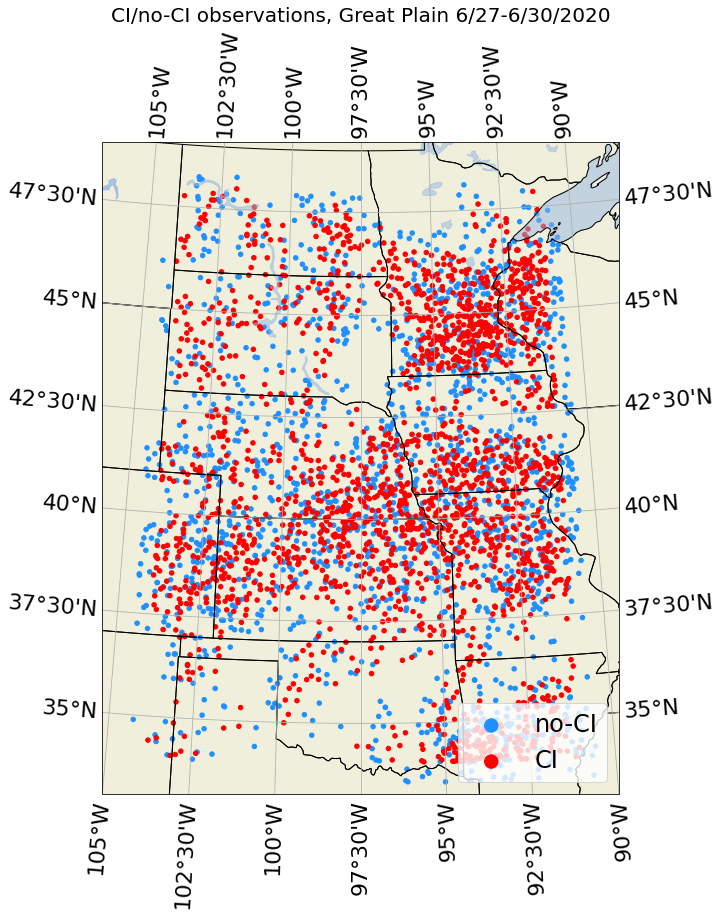

In [182]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(2):
    color=pd.DataFrame()
    color['color'] = test_label[test_label==i]
    ax.scatter(lon_0[test_label == i]-360,
               lat_0[test_label == i],
               c=color['color'].map(colors),
               s=20, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=3, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

In [78]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))
'''
for i in range(2):
    color=pd.DataFrame()
    color['color'] = test_label[test_label==i]
    ax.scatter(lon_0[test_label == i]-360,
               lat_0[test_label == i],
               c=color['color'].map(colors),
               s=20, transform=ccrs.PlateCarree())
'''
im = ax.scatter(lon_0-360, lat_0, c=preds, s=50, marker="s", cmap='Greens',transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax)
    
plt.legend(colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=3, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

NameError: name 'ccrs' is not defined

In [65]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 36.0
latS = 33.0
lonW = -95.0
lonE = -98.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'red', 1:'black'} #{0:'dodgerblue', 1:'red'}#, 2:'red', 3:'black'}

In [56]:
from datetime import datetime,timedelta
date_time=[]
for i in range(len(date_0)):
    date_time.append(datetime.fromtimestamp(date_0[i]))

In [57]:
date_start = datetime(2020, 7, 22, 3, 0)

date_end = datetime(2020, 7, 22, 4, 0)

index = []
for i in range(len(date_time)):
    if(date_time[i]>date_start and date_time[i]<date_end):
        index.append(i)

In [233]:
l

Text(0.5, 1.0, 'CI/no-CI observations, Great Plain 6/27-6/30/2020')

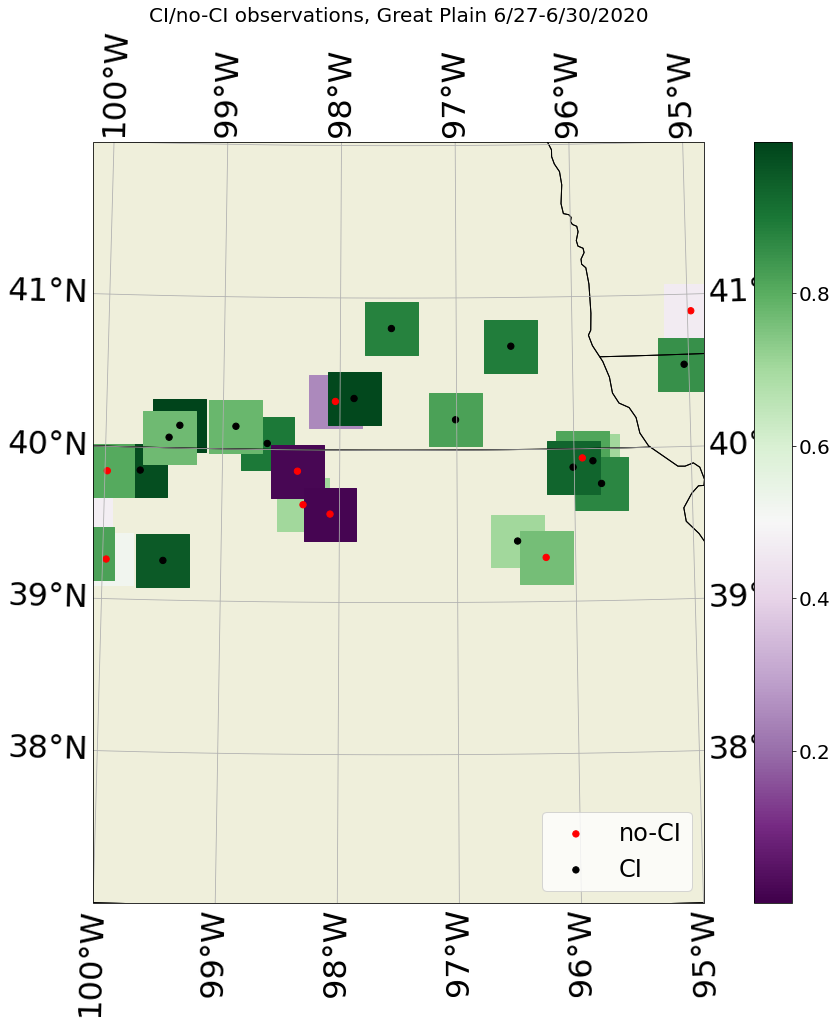

In [ ]:

%matplotlib inline
plt.rcParams['font.size'] = '32'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 14))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

l = []
im = ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=2800, marker="s", cmap='PRGn',transform=ccrs.PlateCarree(),label='_nolegend_')
plt.colorbar(im,ax=ax)
for i in range(2):
    color=pd.DataFrame()
    selected_label=test_label[index]
    index_2 = selected_label==i
    color['color'] = selected_label[index_2]
    l.append(ax.scatter(lon_0[index][index_2]-360,
               lat_0[index][index_2],
               c=color['color'].map(colors),
               s=40, transform=ccrs.PlateCarree()))

plt.legend((l[0],l[1]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

In [338]:
np.array((lon_0[index]-360, lat_0[index])).T.shape

(61, 2)

In [325]:
np.hstack(1,2)

TypeError: _vhstack_dispatcher() takes 1 positional argument but 2 were given

In [153]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 36.5
latS = 33.0
lonW = -95.0
lonE = -98.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'red', 1:'blue'} 

In [120]:
color['color'].map(colors)

0    blue
1    blue
2    blue
3    blue
4     red
5    blue
6    blue
7     red
Name: color, dtype: object

In [133]:
selected_label==selected_preds 

masked_array(data=[False,  True,  True, False,  True,  True,  True,  True,
                   False,  True,  True, False,  True, False,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                   False,  True,  True,  True, False,  True,  True,  True,
                    True,  True,  True,  True,  True, False,  True],
             mask=False,
       fill_value=True)

In [134]:
selected_label[selected_label==selected_preds ]

masked_array(data=[1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
                   0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
                   1., 1., 0.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [154]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

plt.rcParams['font.size'] = '28'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(10, 15))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([-98, -97, -96, -95])
gl.ylocator = mticker.FixedLocator([34, 35, 36])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))
lines = []
a1 = ax.scatter(lon_0[index]-360, lat_0[index], c=-preds[index]*np.log(preds[index]), s=4500, marker="s", cmap='Greys',transform=ccrs.PlateCarree(),label='_nolegend_')
lines.append(a1)
#
for i in range(2):
    color=pd.DataFrame()
    selected_label=test_label[index]
    selected_preds=binary_preds[index]
    if i == 0:
        index_2 = selected_label==selected_preds 
        color['color'] = np.ones(np.sum(index_2))
    else:
        index_2 = selected_label==(1-selected_preds)
        color['color'] = np.zeros(np.sum(index_2))
    #color['color'] = selected_label[index_2]
    a = ax.scatter(lon_0[index][index_2]-360,
               lat_0[index][index_2],
               c=color['color'].map(colors),
               s=350, transform=ccrs.PlateCarree(), edgecolors='k')
    lines.append(a)
plt.colorbar(lines[0],ax=ax,fraction=0.0518, pad=0.2)
plt.legend((lines[1],lines[2]),colors.values(), labels=["Correct", "Incorrect"], fontsize=24, markerscale=1, loc="lower right")
timetext = plt.title("CI/no-CI observations, Great Plain 7/27-7/30/2020", fontsize=32)


def animate(i, lon_0, lat_0, preds, lines):
    date_start = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*i)
    date_end = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*(i+1))
    index = []
    for i in range(len(date_time)):
        if(date_time[i]>date_start and date_time[i]<date_end):
            index.append(i)
    '''
    lines.append(ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=2800, marker="s", cmap='PRGn',transform=ccrs.PlateCarree(),label='_nolegend_'))
    plt.colorbar(lines[0],ax=ax)
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        lines.append(ax.scatter(lon_0[index][index_2]-360,
                   lat_0[index][index_2],
                   c=color['color'].map(colors),
                   s=40, transform=ccrs.PlateCarree()))
    plt.legend((lines[1],lines[2]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
    plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)
    '''
    lines[0].set_offsets(np.array((lon_0[index]-360, lat_0[index])).T)
    lines[0].set_array(-preds[index]*np.log(preds[index]))
    
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        selected_preds=binary_preds[index]
        if i == 0:
            index_2 = selected_label==selected_preds        
        else:
            index_2 = selected_label==(1-selected_preds)
        color['color'] = selected_label[index_2]
        #lines[i+1].set_array(color['color'].map(colors))#,
        lines[i+1].set_offsets(np.array((lon_0[index][index_2]-360, lat_0[index][index_2])).T)
                   #c=color['color'].map(colors),
                   #s=40, transform=ccrs.PlateCarree()))
    timetext.set_text(str(date_start)[5:]+" — "+str(date_end)[-8:])
    return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(8),
                    interval=2000, fargs=(lon_0, lat_0, preds, lines), repeat=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
#f = "animation.mp4" 
#writervideo = FFMpegWriter(fps=60) 

ani.save("plots/Uncertainty_animation.gif", writer='imagemagick')
#ani.save('test.gif')
#plt.show()
#plt.close()

<IPython.core.display.Javascript object>

In [145]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 36.5
latS = 33.0
lonW = -95.0
lonE = -98.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'white', 1:'black'} 

In [146]:
import matplotlib.pyplot as plt
import matplotlib.colors as pycolors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = pycolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greens')
new_cmap = truncate_colormap(cmap, 0, 0.8)

In [122]:
color['color'].map(colors)

0     red
1     red
2     red
3     red
4     red
5     red
6     red
7     red
8     red
9     red
10    red
11    red
12    red
13    red
14    red
15    red
16    red
17    red
18    red
19    red
20    red
21    red
Name: color, dtype: object

In [147]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(10, 15))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([-98, -97, -96, -95])
gl.ylocator = mticker.FixedLocator([34, 35, 36])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))
lines = []
a1 = ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=4500, marker="s", cmap=new_cmap,transform=ccrs.PlateCarree(),label='_nolegend_')
lines.append(a1)
#
for i in range(2):
    color=pd.DataFrame()
    selected_label=test_label[index]
    index_2 = selected_label==i
    color['color'] = selected_label[index_2]
    a = ax.scatter(lon_0[index][index_2]-360,
               lat_0[index][index_2],
               c=color['color'].map(colors), edgecolors='k',
               s=350, transform=ccrs.PlateCarree())
    lines.append(a)
plt.colorbar(lines[0],ax=ax,fraction=0.0518, pad=0.2)
plt.legend((lines[1],lines[2]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
timetext = plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=32)


def animate(i, lon_0, lat_0, preds, lines):
    date_start = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*i)
    date_end = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*(i+1))
    index = []
    for i in range(len(date_time)):
        if(date_time[i]>date_start and date_time[i]<date_end):
            index.append(i)
    '''
    lines.append(ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=2800, marker="s", cmap='PRGn',transform=ccrs.PlateCarree(),label='_nolegend_'))
    plt.colorbar(lines[0],ax=ax)
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        lines.append(ax.scatter(lon_0[index][index_2]-360,
                   lat_0[index][index_2],
                   c=color['color'].map(colors),
                   s=40, transform=ccrs.PlateCarree()))
    plt.legend((lines[1],lines[2]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
    plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)
    '''
    lines[0].set_offsets(np.array((lon_0[index]-360, lat_0[index])).T)
    lines[0].set_array(preds[index])
    
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        #lines[i+1].set_array(color['color'].map(colors))#,
        lines[i+1].set_offsets(np.array((lon_0[index][index_2]-360, lat_0[index][index_2])).T)
                   #c=color['color'].map(colors),
                   #s=40, transform=ccrs.PlateCarree()))
    timetext.set_text(str(date_start)[5:]+" — "+str(date_end)[-8:])
    return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(8),
                    interval=2000, fargs=(lon_0, lat_0, preds, lines), repeat=True)
from IPython.display import HTML
HTML(ani.to_jshtml())
#ani.save("plots/Performance_animation.gif", writer='imagemagick')

<IPython.core.display.Javascript object>

In [151]:
    i = 1
    date_start = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*i)
    date_end = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*(i+1))
    index = []
    for i in range(len(date_time)):
        if(date_time[i]>date_start and date_time[i]<date_end):
            index.append(i)
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        print(np.array((lon_0[index][index_2], lat_0[index][index_2])).T)
        print(preds[index][index_2])

[[ -97.01   38.02]
 [-103.78   38.93]
 [-104.47   43.42]
 [ -94.11   37.29]
 [ -97.61   35.86]
 [ -97.97   38.02]
 [-102.47   44.17]
 [-104.13   39.71]
 [ -97.39   35.82]
 [ -96.43   36.3 ]
 [ -95.07   37.77]
 [ -98.65   34.83]
 [-100.49   44.14]
 [ -98.65   35.31]
 [ -99.25   36.63]]
[3.6738902e-02 3.5272956e-06 7.7791341e-02 5.6578975e-02 7.1378022e-01
 1.4334278e-01 3.1157397e-02 3.0715019e-01 5.5106634e-01 1.5606333e-02
 4.6328819e-01 5.9752469e-03 4.6846010e-03 7.1673002e-03 7.1942598e-02]
[[ -94.59   37.29]
 [ -98.77   36.15]
 [ -91.47   43.16]
 [-102.95   43.69]
 [ -98.09   36.34]
 [ -97.49   38.02]
 [-103.99   43.9 ]
 [-103.9    43.82]
 [ -96.91   35.82]
 [-103.51   44.2 ]
 [ -95.34   38.44]
 [ -99.13   35.31]
 [ -92.97   37.68]
 [-103.65   40.19]]
[0.8525863  0.99547416 0.9992034  0.93070865 0.95269024 0.9260094
 0.8854356  0.85927474 0.6411229  0.79916304 0.93605775 0.989031
 0.97400767 0.6777331 ]


In [274]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>